In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorly as tl
import string
import scipy
import itertools
import torch as tn
import cProfile
import pstats
import opt_einsum as oe
from mpl_toolkits.mplot3d import Axes3D
import ast

In [5]:
# Profiling function
def profile_f(f, loc, print=True, save=True):
    profiler = cProfile.Profile()
    profiler.enable()
    f()
    profiler.disable()
    
    if save:
        profiler.dump_stats(loc)

    if print:
        # Print profiling results
        stats = pstats.Stats(profiler)
        stats.strip_dirs()
        stats.sort_stats('cumulative')
        stats.print_stats()

In [6]:
# Pg 460 - Tensor Decompositions and Applications by TAMARA G. KOLDA AND BRETT W BADER
X1 = np.arange(12).reshape(4, 3).T + 1
X2 = np.arange(13, 25).reshape(4, 3).T
X = np.zeros((3, 4, 2))
X[:, :, 0] = X1; X[:, :, 1] = X2

In [7]:
X

array([[[ 1., 13.],
        [ 4., 16.],
        [ 7., 19.],
        [10., 22.]],

       [[ 2., 14.],
        [ 5., 17.],
        [ 8., 20.],
        [11., 23.]],

       [[ 3., 15.],
        [ 6., 18.],
        [ 9., 21.],
        [12., 24.]]])

# Linear Algebra operations

## RQ decomposition

In [8]:
def rq(A):
    q1, r1 = np.linalg.qr(A[::-1, :].T)
    return (r1.T)[::-1, ::-1], (q1.T)[::-1, :]

## Random algorithms

In [9]:
# Randomized SVD
# Algorithm 1
def rand_svd_1(X, rk, oversampling=5):
    """
    Returns low rank approximation of matrix X
    """
    n, m = X.shape
    phi = np.random.randn(m, rk+oversampling)
    Y = X @ phi
    q, r = np.linalg.qr(Y)
    return q @ q.T @ X

# Algorithm 2
def rand_svd_2(X, rk, t, oversampling=5):
    """
    2 way randomization algorithm to return low rank approximation of X
    """
    n, m = X.shape
    phi = np.random.randn(m, rk); omega = np.random.randn(t, n)
    Y = X @ phi; Z = omega @ X
    q, r = np.linalg.qr(omega @ X @ phi)
    return (Y @ np.linalg.inv(r))@(q.T @ Z)


In [10]:
tr = 91
X = np.random.randn(1000, 100)
u, s, v = np.linalg.svd(X)
u = u[:, :tr]; s = s[:tr]; v = v[:tr, :]
Xrec = u @ np.diag(s) @ v
Xrecrand1 = rand_svd_1(X, tr, 10)
Xrecrand2 = rand_svd_2(X, tr, tr+1, 10)
print(np.linalg.norm(X - Xrec))
print(np.linalg.norm(X - Xrecrand1))
print(np.linalg.norm(X - Xrecrand2))

69.5761546980538
3.199392109904355e-12
601.8555082273452


# Matricization/Unfolding

In [11]:
def unfold(t, mode):
    return np.reshape(np.moveaxis(t, mode-1, 0), (t.shape[mode-1], -1))

def fold(mat, mode, shape):
    intshape = shape[mode-1:mode] + shape[:mode-1] + shape[mode:]
    t = np.reshape(mat, tuple(intshape))
    t = np.moveaxis(t, 0, mode-1)
    return t

# n-mode product of tensors

In [12]:
U = np.reshape(np.arange(1, 7), (3, 2)).T

In [13]:
def naivenmode(tens, mat, mode):
    assert tens.shape[mode-1] == mat.shape[1], "Shapes incompatible"
    newshape = list(tens.shape); newshape[mode-1] = mat.shape[0]
    newtens = np.zeros(tuple(newshape))
    slicing = [slice(None)] * 3
    for i in range(newtens.shape[0]):
        if mode != 1: slicing[0] = i
        else: elem = i
        for j in range(newtens.shape[1]):
            if mode != 2: slicing[1] = j
            else: elem = j
            for k in range(newtens.shape[2]):
                if mode != 3: slicing[2] = k
                else: elem = k
                newtens[i, j, k] = np.dot(tens[tuple(slicing)], mat[elem, :])
    return newtens


# naivenmode(X, U, 1)

In [14]:
def n_mode_prod(t, mat, mode):
    newshape = list(t.shape); newshape[mode-1] = mat.shape[0]
    ttmp = unfold(t, mode)
    print(ttmp.shape)
    ttmp = np.dot(mat, ttmp)
    return fold(ttmp, mode, newshape)

# tenn = np.random.randn(4, 5, 6)
# mat1 = np.random.randn(4, 5)
# n_mode_prod(tenn, mat1, 2).shape

In [15]:
def nmode(t, mats, modes):
    modes = np.array(modes) - 1
    letters = list(string.ascii_letters)
    sh = t.shape
    dim = len(sh)
    lenmode = len(modes)
    tenchr = np.array(letters[:dim])
    modepr = tenchr[modes]
    modepos = letters[dim:dim+lenmode]
    matind = [',' + a + b for a, b in zip(list(modepos), list(modepr))]
    tenpr = tenchr.copy()
    tenchr[modes] = modepos
    fstr = ''.join(list(tenpr) + matind + ['->'] + list(tenchr))
    return np.einsum(fstr, t, *mats)

# tenn = np.random.randn(4, 5, 6)
# mat1 = np.random.randn(4, 5); mat2 = np.random.randn(4, 6)
# print(np.linalg.norm(nmode(tenn, [mat1, mat2], [2, 3]) - n_mode_prod(n_mode_prod(tenn, mat1, 2), mat2, 3)))

# Matrix products - Kronecker, Khatri-Rao, and Hadamard

In [16]:
def kronecker_prod(A, B):
    if np.ndim(A) == 1: A = A[:, np.newaxis]
    if np.ndim(B) == 1: B = B[:, np.newaxis]
    i, j = A.shape; k, l = B.shape
    res = np.zeros((i*k, j*l))
    for s in range(i):
        for t in range(j):
            res[s*k:s*k+k, t*l:t*l+l] = A[s, t]*B
    return res

# tmp1 = np.random.randn(2); tmp2 =  np.random.randn(5)
# kronecker_prod(tmp1, tmp2)

In [17]:
def kronecker_prod2(A, B):
    if np.ndim(A) == 1: A = A[:, np.newaxis]
    if np.ndim(B) == 1: B = B[:, np.newaxis]
    i, j = A.shape; k, l = B.shape
    res = np.reshape(np.array([B]*(i*j)), (i, j, k, l))
    res = res * A[:, :, np.newaxis, np.newaxis]
    return np.reshape(np.transpose(res, (0, 2, 1, 3)), (i*k, j*l))

# tmp1 = np.random.randn(2); tmp2 =  np.random.randn(5)
# kronecker_prod(tmp1, tmp2) - kronecker_prod2(tmp1, tmp2)

In [18]:
def khatri_rao_prod(A, B):
    if np.ndim(A) == 1: A = A[:, np.newaxis]
    if np.ndim(B) == 1: B = B[:, np.newaxis]
    i, j = A.shape; k, l = B.shape
    assert j == l, "Number of columns of A should be equal to number of columns in B"
    res = np.zeros((i*k, j))
    for s in range(j):
        res[:, s] = kronecker_prod(A[:, s], B[:, s])[:, 0]

    return res

# tmp1 = np.random.randn(2, 4); tmp2 =  np.random.randn(5, 4)
# khatri_rao_prod(tmp1, tmp2)

In [19]:
def multi(f, listt):
    res = listt[0]
    for i in range(1, len(listt)):
        res = f(res, listt[i])
    return res

# tmp1 = np.random.randn(2, 4); tmp2 =  np.random.randn(5, 4); tmp3 =  np.random.randn(6, 4); tmp4 =  np.random.randn(3, 4)
# multi(kronecker_prod, [tmp1, tmp2, tmp3, tmp4]).shape

In [20]:
# testing the implementation against established implementation

tmp1 = np.random.randn(2, 4); tmp2 =  np.random.randn(5, 4)

# tl.tenalg.kronecker([tmp1, tmp2]) - kronecker_prod(tmp1, tmp2)
# tl.tenalg.khatri_rao([tmp1, tmp2]) - khatri_rao_prod(tmp1, tmp2)

In [21]:
# testing few properties Pg. 462 (2.2) - Tensor Decompositions and Applications by TAMARA G. KOLDA AND BRETT W BADER
tmp1 = np.reshape(np.arange(1, 5), (2, 2))
tmp2 = np.reshape(np.arange(1, 5), (2, 2)) + np.ceil(np.random.randn(1) * 10)
tmp3 = np.reshape(np.arange(1, 5), (2, 2)) + np.ceil(np.random.randn(1) * 10)
tmp4 = np.reshape(np.arange(1, 5), (2, 2)) + np.ceil(np.random.randn(1) * 10)

# (1)
print("(1) ", np.array_equal(kronecker_prod(tmp1, tmp2) @ kronecker_prod(tmp3, tmp4), kronecker_prod(tmp1@tmp3, tmp2@tmp4)))

# (2)
# print(np.array_equal(np.linalg.pinv(kronecker_prod(tmp1, tmp2)), kronecker_prod(np.linalg.pinv(tmp1), np.linalg.pinv(tmp2))))
print("(2) ", np.allclose(np.linalg.pinv(kronecker_prod(tmp1, tmp2)), kronecker_prod(np.linalg.pinv(tmp1), np.linalg.pinv(tmp2)), atol=1e-14))

# (3)
print("(3)   -")

# (4)
print("(4) ", np.array_equal(khatri_rao_prod(tmp1, tmp2).T @ khatri_rao_prod(tmp1, tmp2), (tmp1.T @ tmp1) * (tmp2.T @ tmp2)))

# (5)
# print(np.array_equal(np.linalg.pinv(khatri_rao_prod(tmp1, tmp2)), np.linalg.pinv((tmp1.T @ tmp1) * (tmp2.T @ tmp2)) @ khatri_rao_prod(tmp1, tmp2).T))
print("(5) ", np.allclose(np.linalg.pinv(khatri_rao_prod(tmp1, tmp2)), np.linalg.pinv((tmp1.T @ tmp1) * (tmp2.T @ tmp2)) @ khatri_rao_prod(tmp1, tmp2).T, atol=1e-14))

(1)  True
(2)  True
(3)   -
(4)  True
(5)  True


# Generalized outer product

In [22]:
def outerprod(tensors):
    for i, tensor in enumerate(tensors):
        if i:
            shape = np.shape(tensor)
            s1 = len(shape)
            shape_1 = shape_res + (1,) * s1
            shape_2 = (1,) * sres + shape
            res = np.reshape(res, shape_1) * np.reshape(tensor, shape_2)
        else:
            res = tensor
        shape_res = np.shape(res)
        sres = len(shape_res)
    return res

# z1, z2, z3 = (np.random.randn(3, 7), np.random.randn(2, 3), np.random.randn(4, 3))
# outerprod([z1, z2]) - np.einsum('ij,kl->ijkl', z1, z2)

# CP ALS Decomposition

In [23]:
def initializecp(t, rank, init='random'):
    initvals = []
    dim = np.ndim(t)
    for i in range(dim):
        m = unfold(t, i+1)
        if init == 'random': u = np.random.randn(m.shape[0], rank)
        elif init == 'svd': u, s, v = np.linalg.svd(m); u = u[:, :rank]
        initvals.append(u)

    # print([mat.shape for mat in initvals])
    return initvals

In [24]:
def cpreconstruction(lb, cpmat):
    shape = tuple([mat.shape[0] for mat in cpmat])
    res = np.zeros(shape)
    for i in range(len(lb)):
        res += outerprod([lb[i]]+[mat[:, i] for mat in cpmat])
    return res

In [25]:
def cpdecomposition(t, rank, init='random', maxiters=50, tol = 1e-3):
    cpmat = initializecp(t, rank, init)
    matlist = cpmat.copy()
    dim = np.ndim(t)
    i=0; check = tol+1
    while i <= maxiters and check >= tol:
        for n in range(dim):
            Xn = unfold(t, n+1)
            matlist.pop(n)
            vlist = [mat.T @ mat for mat in matlist]
            v = multi(lambda x, y: x*y, vlist)
            # print(Xn.shape, multi(khatri_rao_prod, matlist).shape, np.linalg.pinv(v).shape)
            An = Xn@multi(khatri_rao_prod, matlist[::-1])@np.linalg.pinv(v)
            lb = np.sqrt(np.sum(np.square(An), axis=0))
            An = np.divide(An, lb)
            cpmat[n] = An
            matlist = cpmat.copy()
        check = np.linalg.norm(t - cpreconstruction(lb, cpmat))/np.linalg.norm(t)
        i += 1
    return lb, cpmat

# tmp1 = np.random.randn(10); tmp2 = np.random.randn(19, 10); tmp3 = np.random.randn(13, 10); tmp4 = np.random.randn(14, 10)
# intmp = cpreconstruction(tmp1, [tmp2, tmp3, tmp4])


# l1, intmp1 = cpdecomposition(intmp, rank=10, init='random', maxiters=50)

In [26]:
tmp1 = np.random.randn(10); tmp2 = np.random.randn(19, 10); tmp3 = np.random.randn(13, 10); tmp4 = np.random.randn(14, 10)
intmp = cpreconstruction(tmp1, [tmp2, tmp3, tmp4])


l1, intmp1 = cpdecomposition(intmp, rank=12, init='svd', maxiters=1000, tol=1e-8)
# l1, intmp1 = tl.decomposition.parafac(intmp, rank=10, init='svd')
f = cpreconstruction(l1, intmp1)
print(np.linalg.norm(f - intmp)/np.linalg.norm(intmp))
# from tensorly.decomposition import parafac
# sda = tl.randn((23, 14, 35))

# # weight, factors = parafac(sda, 5)
# wt, f = cpdecomposition(sda, 5, maxiters=50)


# print(f[1])
# print(weight, wt)

# for i in range(1, 2):
#     weight, factors = parafac(sda, i)
#     recon = tl.cp_to_tensor((weight, factors))
#     # print(i, " ", np.linalg.norm(recon - sda))

0.9165965526776598


## Operations on CP decomposition

In [27]:
# Build X with factor matrices
nd = 3

Rx = 10
lx = np.random.randn(Rx)
matx = [np.random.randn(2, Rx) for i in range(nd)]

Ry = 12
ly = np.random.randn(Ry)
maty = [np.random.randn(2, Ry) for i in range(nd)]

X = tl.cp_to_tensor(cp_tensor=(lx, matx))
Y = tl.cp_to_tensor(cp_tensor=(ly, maty))

# # Tensor addition
# Z = X + Y
# Zrec = np.zeros_like(Z)
# for i in range(matx[0].shape[1]):
#     lstmp = [lx[i]] + [mat[:, i] for mat in matx]
#     Zrec += outerprod(lstmp)

# for i in range(maty[0].shape[1]):
#     lstmp = [ly[i]] + [mat[:, i] for mat in maty]
#     Zrec += outerprod(lstmp)


# # Tensor element-wise multiplication
# Z = X * Y
# matz = []; lz = np.zeros((matx[0].shape[1]*maty[0].shape[1]))
# for i in range(len(matx)):
#     tmp = np.zeros((matx[i].shape[0], matx[i].shape[1]*maty[i].shape[1]))
#     for j in range(matx[i].shape[1]):
#         for k in range(maty[i].shape[1]):
#             if not i: lz[j*maty[i].shape[1] + k] = (lx[j]*ly[k])
#             tmp[:, j*maty[i].shape[1] + k] = matx[i][:, j]*maty[i][:, k]
#     matz.append(tmp)
# Zrec = tl.cp_to_tensor((lz, matz))


# # Kronecker outer product
# Z = outerprod([X, Y])
# Zrec = np.zeros_like(Z)
# for i in range(matx[0].shape[1]):
#     ls1 = [lx[i]] + [mat[:, i] for mat in matx]
#     tmpx = outerprod(ls1)
#     for j in range(maty[0].shape[1]):
#         ls2 = [ly[j]] + [mat[:, j] for mat in maty]
#         Zrec += outerprod([tmpx, outerprod(ls2)])



# print(np.linalg.norm(Z - Zrec))

# Tucker Decomposition

In [28]:
def tuckerhosvd(X, ranks: list):
    assert len(ranks) == np.ndim(X), "Number of ranks should match the dimension of the tensor X"
    N = np.ndim(X)
    alist = []
    for i in range(N):
        u, s, v = np.linalg.svd(unfold(X, i+1))
        alist.append(u[:, :ranks[i]])
    G = X
    for i, A in enumerate(alist):
        G = n_mode_prod(G, A.T, i+1)

    return G, alist

In [29]:
def tuckerhooi(X, ranks: list, maxiters=50):
    assert len(ranks) == np.ndim(X), "Number of ranks should match the dimension of the tensor X"
    N = np.ndim(X)
    alist = []; modearray = np.arange(N)
    for i in range(N):
        u, s, v = np.linalg.svd(unfold(X, i+1))
        alist.append(u[:, :ranks[i]])
    k=0
    while k <= maxiters:
        for j in range(N):
            tmplist = alist.copy()
            tmplist.pop(j)
            Y = X
            for i, A in zip(list(modearray[:j])+list(modearray[j+1:]), tmplist):
                Y = n_mode_prod(Y, A.T, i+1)
            alist[j] = np.linalg.svd(unfold(Y, j+1))[0][:, :ranks[j]]

        k += 1

    G = X
    for i, A in enumerate(alist):
        G = n_mode_prod(G, A.T, i+1)

    return G, alist

In [30]:
def tuckerrec(core, factors):
    for i, mat in enumerate(factors):
        core = n_mode_prod(core, mat, i+1)
    return core

In [31]:
# test

tmpcore = np.random.randn(4, 5, 3); tmp1 = np.random.randn(7, 4); tmp2 = np.random.randn(5, 5); tmp3 = np.random.randn(5, 3)
X = tuckerrec(tmpcore, [tmp1, tmp2, tmp3])
c, f = tuckerhosvd(X, ranks=[7, 5, 5])
# c, f = tuckerhooi(X, ranks=[7, 5, 5])
res = tuckerrec(c, f)
print(np.linalg.norm(X - res)/np.linalg.norm(X))

(4, 15)
(5, 21)
(3, 35)
(7, 25)
(5, 35)
(5, 35)
(7, 25)
(5, 35)
(5, 35)
1.1324889634988612e-15


# Tensor Trains

In [32]:
def eps_to_rank(s, eps):
    l = (np.sqrt(np.cumsum(np.square(s[::-1])))[::-1]) <= eps
    res = np.argmax(l)
    if res == 0 and l[0] == False: return s.shape[0]
    else: return res

In [33]:
def ttsvd(t, rank='default', eps=1e-14):
    norm = np.linalg.norm(t)
    tshape = t.shape
    dim = len(tshape)
    if rank == 'default': rank = [1] + [np.inf for _ in range(dim-1)] + [1]

    C = t

    factors = []
    assert len(rank) == dim + 1, "Rank is not compatible with tensor shape"
    assert rank[0] == 1 and rank[-1] == 1, "First and last entry of the rank should be equal to 1"

    for k in range(dim - 1):
        C = np.reshape(C, (int(rank[k] * tshape[k]), -1))
        nr, nc = C.shape
        U, S, V = np.linalg.svd(C)
        rkp1 = min(nr, nc, rank[k+1], eps_to_rank(S, eps*norm/(dim-1)**0.5))
        U = U[:, :rkp1]; S = S[:rkp1]; V = V[:rkp1, :]
        rank[k+1] = rkp1
        factors.append(np.reshape(U, (rank[k], tshape[k], rank[k+1])))
        C = np.reshape(S, (-1, 1)) * V

    # Final core
    r, d = C.shape
    factors.append(np.reshape(C, (r, d, 1)))

    return factors

In [34]:
def ttrec(factors):
    shape = [f.shape[1] for f in factors]
    res = factors[0].reshape((shape[0], -1))
    for i, f in enumerate(factors[1:]):
        rkm1, _, rkp1 = f.shape
        f = f.reshape((rkm1, -1))
        res = np.dot(res, f)
        res = res.reshape((-1, rkp1))
    return res.reshape(shape)

In [35]:
def ttrec2(factors):
    letters = string.ascii_letters
    pr = []; ps = []; dim = len(factors)
    for i in range(dim):
        tmp = letters[2*i:2*i + 3]
        if i == dim-1: pr.append(tmp)
        else: pr.append(tmp + ',' )
        ps.append(tmp[1])
    fstr = ''.join(pr + ['->'] + ps)
    return(np.einsum(fstr, *factors))

In [36]:
def naivettrec(factors):
    tshape = tuple([f.shape[1] for f in factors])
    res = np.zeros(tshape)
    for i in range(tshape[0]):
        for j in range(tshape[1]):
            for k in range(tshape[2]):
                res[i, j, k] = (factors[0][:, i, :]@factors[1][:, j, :]@factors[2][:, k, :])[0]
    return res

In [37]:
# Create a tensor
tmp1 = np.random.rand(1, 5, 5); tmp2 = np.random.rand(5, 3, 8); tmp3 = np.random.rand(8, 7, 1)

X = ttrec([tmp1, tmp2, tmp3])

# Perform Tucker train decomposition
factors = ttsvd(X, rank='default', eps=1e-8)

print([mat.shape for mat in factors])

for _ in range(1000):
    # res = np.einsum('ijk,klm,mno->jln', *factors)
    # res = tl.tt_to_tensor(factors)
    # res = ttrec(factors)
    res = ttrec2(factors)

check = np.linalg.norm(X - res)
perr = np.linalg.norm(X)*1e-8
print(check)
print(check <= perr)

[(1, 5, 5), (5, 3, 7), (7, 7, 1)]
3.014904605523881e-14
True


## TT operations

In [38]:
def tt_zeros(size, rank):
    d = len(size)
    assert d + 1 == len(rank), "Rank and size are incompatible"
    factors = [None]*d
    for i in range(d):
        factors[i] = np.zeros(rank[i:i+1]+size[i:i+1]+rank[i+1:i+2])
    return factors

# def tt_ones(size, rank):
#     d = len(size)
#     assert d + 1 == len(rank), "Rank and size are incompatible"
#     factors = [None]*d
#     for i in range(d):
#         factors[i] = np.ones(rank[i:i+1]+size[i:i+1]+rank[i+1:i+2])
#     return factors

def rand_tt(size, rank):
    d = len(size)
    assert d + 1 == len(rank), "Rank and size are incompatible"
    factors = [None]*d
    for i in range(d):
        factors[i] = np.random.randn(rank[i], size[i], rank[i+1])
    return factors


def tt_add2(factorsx, factorsy):
    dim = len(factorsx)
    factorsz = []
    for i, (matx, maty) in enumerate(zip(factorsx, factorsy)):
        sx = matx.shape; sy = maty.shape
        if i == 0:
            tmp = np.concatenate([matx, maty], axis=-1)
        elif i == dim-1:
            tmp = np.concatenate([matx, maty], axis=0)
        else:
            tmp1 = np.concatenate([matx, np.zeros(sx[:2]+sy[-1:])], axis=-1)
            tmp2 = np.concatenate([np.zeros(sy[:2]+sx[-1:]), maty], axis=-1)
            tmp = np.concatenate([tmp1, tmp2], axis=0)

        factorsz.append(tmp)
    return factorsz

def tt_add(factorsx, factorsy):
    dim = len(factorsx)
    factorsz = []
    for i, (matx, maty) in enumerate(zip(factorsx, factorsy)):
        sx = matx.shape; sy = maty.shape
        if i == 0:
            tmp = np.concatenate([matx, maty], axis=-1)
        elif i == dim-1:
            tmp = np.concatenate([matx, maty], axis=0)
        else:
            tmp = np.zeros([sx[0]+sy[0], sx[1], sx[-1]+sy[-1]])
            tmp[:sx[0], :, :sx[-1]] = factorsx[i]
            tmp[sx[0]:, :, sx[-1]:] = factorsy[i]
        factorsz.append(tmp)
    return factorsz


def tt_multiply(factorsx, factorsy):
    factorsz = []
    for matx, maty in zip(factorsx, factorsy):
        sx = matx.shape; sy = maty.shape
        tmp = np.zeros((sx[0]*sy[0], sx[1], sx[2]*sy[2]))
        for j in range(sx[1]):
            tmp[:, j, :] = kronecker_prod(matx[:, j, :], maty[:, j, :])
        factorsz.append(tmp)

    return factorsz

In [39]:
# def tt_multiply(factorsx, factorsy):
#     factorsz = []
#     for matx, maty in zip(factorsx, factorsy):
#         sx = matx.shape; sy = maty.shape
#         assert sx[1] == sy[1], "Mode sizes should be the same"
#         tmp2 = khatri_rao_prod(np.transpose(matx, [2, 0, 1]).reshape((-1, sx[1])), np.transpose(maty, [2, 0, 1]).reshape((-1, sy[1])))
#         tmp2 = np.transpose(tmp2.reshape((sx[2]*sy[2], sx[0]*sy[0], sx[1])), [1, 2, 0])


#         tmp = np.zeros((sx[0]*sy[0], sx[1], sx[2]*sy[2]))
#         for j in range(sx[1]):
#             tmp[:, j, :] = kronecker_prod(matx[:, j, :], maty[:, j, :])
#         factorsz.append(tmp)

#         print("Hey", np.linalg.norm(tmp - tmp2))
#         factorsz.append(tmp)

#     return factorsz

In [40]:
# Done using existing implementation
# Create a tensor
s = [2, 1, 2]
rx = [1, 2, 6, 1]
ry = [1, 7, 3, 1]

factorsx = rand_tt(s, rx)
factorsy = rand_tt(s, ry)
X = ttrec(factorsx)
Y = ttrec(factorsy)

# Addition
Z = X + Y
factorsz = tt_add(factorsx, factorsy)
Zrec = ttrec(factorsz)
print(np.linalg.norm(Z - Zrec)/np.linalg.norm(Z))

# # Multiplication
# Z = X * Y
# factorsz = tt_multiply(factorsx, factorsy)
# Zrec = ttrec(factorsz)
# print(np.linalg.norm(Z - Zrec))

8.153005617339304e-17


In [41]:
# def tt_dot(A, B):
#     dim = len(A)
#     res = 1
#     C = [None]*dim
#     for i in range(dim):
#         C[i] = np.einsum('ijk,ljm->ilkm', A[i], B[i])
#         s = C[i].shape
#         C[i] = np.reshape(C[i], (s[0]*s[1], s[2]*s[3]))
#         if not i:
#             res *= C[i]
#         else: res = res @ C[i]
#     return (res[0, 0])

# def tt_dot(A, B):
#     dim = len(A)
#     res = 1
#     C = [None]*dim
#     for i in range(dim):
#         sA = A[i].shape; sB = B[i].shape
#         tmp1 = np.transpose(A[i], [0, -1, 1]).reshape((-1, sA[1]))
#         tmp2 = np.transpose(B[i], [1, 0, -1]).reshape((sB[1], -1))
#         C[i] = (tmp1 @ tmp2).reshape((sA[0], sA[-1], sB[0], sB[-1]))
#         C[i] = np.transpose(C[i], [0, 2, 1, 3]).reshape((sA[0]*sB[0], sA[-1]*sB[-1]))

#         if not i:
#             res *= C[i]
#         else: res = res @ C[i]
#     return (res[0, 0])

def tt_dot(A, B):
    dim = len(A)
    C = A.copy()
    for i in range(dim-1):
        sb = B[i].shape
        scp1 = C[i+1].shape
        tmp = C[i][0, :, :].T @ B[i].reshape((sb[0]*sb[1], -1))
        C[i+1] = (tmp.T @ C[i+1].reshape((scp1[0], -1))).reshape((1, sb[-1]*scp1[-2], scp1[-1]))
        # C[i+1] = np.einsum('jk,jm,kno->mno', C[i][0, :, :], B[i].reshape((sb[0]*sb[1], -1)), C[i+1]).reshape((1, sb[-1]*scp1[-2], scp1[-1]))

    return np.dot(B[i+1][:, :, 0].flatten(), C[i+1][0, :, 0])


def vec_to_tt(vec, sh, rank='default', eps=1e-14):
    x = vec.copy()
    s = x.shape; dim = len(sh)
    assert np.prod(np.array(list(sh))) == s[0], "Total number of elements do not match."

    x = np.reshape(x, list(sh))
    factors = ttsvd(x, rank, eps)

    return factors

def mat_to_tt(mat, rowsh, colsh, rank='default', eps=1e-14):
    A = mat.copy()
    s = A.shape; dim = len(rowsh)
    assert dim == len(colsh), "Number of elements in row shape should be equal to number of elements in column shape."
    assert np.prod(np.array(list(rowsh)+list(colsh))) == s[0]*s[1], "Total number of elements do not match."

    A = np.reshape(A, list(rowsh) + list(colsh))
    nsh = np.arange(2*dim).reshape((2, -1)).flatten(order='F')
    A = np.transpose(A, tuple(nsh))
    A = np.reshape(A, [i[0]*i[1] for i in zip(rowsh, colsh)])

    factors = ttsvd(A, rank, eps)
    for i in range(dim):
        tmpsh = factors[i].shape
        factors[i] = factors[i].reshape((tmpsh[0], rowsh[i], colsh[i], tmpsh[-1]))

    return factors


def tt_matvec(A, x):
    assert [s.shape[2] for s in A] == [s.shape[1] for s in x], "Incompatible shapes"
    dim = len(A)
    res = [None]*dim
    for i in range(dim):
        sa = A[i].shape; sx = x[i].shape
        # res[i] = np.einsum('ijkl,mkn->imjln', A[i], x[i])
        res[i] = (A[i].transpose([0, 1, 3, 2]).reshape((-1, sa[2])) @ x[i].transpose([1, 0, 2]).reshape(
            (sx[1], -1))).reshape((sa[0], sa[1], sa[3], sx[0], sx[2]))
        res[i] = res[i].transpose([0, 3, 1, 2, 4])
        res[i] = np.reshape(res[i], (sa[0]*sx[0], sa[1], sa[-1]*sx[-1]))
    return res

def tt_matmat(A, B):
    assert [s.shape[2] for s in A] == [s.shape[1] for s in B], "Incompatible shapes"
    dim = len(A)
    res = [None]*dim
    for i in range(dim):
        sa = A[i].shape; sb = B[i].shape
        # res[i] = np.einsum('ijkl,mkno->imjnlo', A[i], B[i])
        res[i] = (A[i].transpose([0, 1, 3, 2]).reshape((-1, sa[2])) @ B[i].transpose([1, 0, 2, 3]).reshape(
            (sb[1], -1))).reshape((sa[0], sa[1], sa[3], sb[0], sb[2], sb[3]))
        res[i] = res[i].transpose([0, 3, 1, 4, 2, 5])
        res[i] = np.reshape(res[i], (sa[0]*sb[0], sa[1], sb[2], sa[-1]*sb[-1]))
    return res

def tt_to_vecmat(factors):
    dim = len(factors); l = len(factors[0].shape)
    if l == 4:
        rshape = [s.shape[1] for s in factors]
        cshape = [s.shape[2] for s in factors]
        res = [None]*dim
        for i in range(dim):
            s = factors[i].shape
            res[i] = np.reshape(factors[i], (s[0], s[1]*s[2], -1))
        mat = ttrec(res).reshape([val for pair in zip(rshape, cshape) for val in pair])
        mat = np.transpose(mat, [2*i for i in range(dim)] + [2*i+1 for i in  range(dim)]).reshape((np.prod(np.array(rshape)), np.prod(np.array(cshape))))
        return mat

    elif l == 3: return ttrec(factors).flatten()

def get_tt_rank(tt):
    return [1] + [s.shape[-1] for s in tt]

def get_tt_element(factors: list, index: list):
    return multi(np.dot, [factors[:, index[i], :] for factors in range(len(index))])



In [42]:
def tt_core_reshape(g, newshape, rank='default'):
    oldshape = g.shape[1]
    assert np.prod(newshape) == oldshape
    tmp = np.reshape(g, g.shape[0:1] + tuple(newshape) + g.shape[-1:])
    tmp = ttsvd(tmp, rank=rank)
    sh = tmp[1].shape
    tmp[1] = np.einsum('ijk,klm->ijlm', tmp[0], tmp[1]).reshape(g.shape[0:1]+sh[1:])
    sh = tmp[-2].shape
    tmp[-2] = np.einsum('ijk,klm->ijlm', tmp[-2], tmp[-1]).reshape(sh[0:2]+g.shape[-1:])

    return tmp[1:-1]

In [43]:
# # df = rand_tt([128, 128, 128], [1, 3, 3, 1])
# bn = 4
# df = [[lap1d(bn, 1).flatten()[np.newaxis, ..., np.newaxis], np.eye(bn).flatten()[np.newaxis, ..., np.newaxis], np.eye(bn).flatten()[np.newaxis, ..., np.newaxis]],
# [np.eye(bn).flatten()[np.newaxis, ..., np.newaxis], lap1d(bn, 1).flatten()[np.newaxis, ..., np.newaxis], np.eye(bn).flatten()[np.newaxis, ..., np.newaxis]],
# [np.eye(bn).flatten()[np.newaxis, ..., np.newaxis], np.eye(bn).flatten()[np.newaxis, ..., np.newaxis], lap1d(bn, 1).flatten()[np.newaxis, ..., np.newaxis]]]
# df = multi(tt_add, df)

# dff = []
# for i in range(3):
#     dff += tt_core_reshape(df[i], [2 for _ in range(int(np.log2(bn**2)))])
# dff = tt_rounding(dff)[0]

# print(get_tt_rank(dff))

# print(np.sum([np.prod(s.shape) for s in dff]))

In [44]:
# Create a tensor
tmp1 = np.random.rand(1, 10, 8); tmp2 = np.random.rand(8, 9, 8); tmp3 = np.random.rand(8, 7, 1)
tmp11 = np.random.rand(1, 10, 5); tmp12 = np.random.rand(5, 9, 3); tmp13 = np.random.rand(3, 7, 1)
factors = [tmp1, tmp2, tmp3]
factors1 = [tmp11, tmp12, tmp13]
X = ttrec(factors)
X1 = ttrec(factors1)

print(tt_dot(factors, factors) - (np.sum(X*X)))
print(tt_dot(factors, factors1) - (np.sum(X*X1)))

7.275957614183426e-12
0.0


In [45]:
# test matvec
matA = np.random.randn(64, 64)
vecx = np.random.randn(64)
res = matA@vecx
res1 = matA@matA
Att = mat_to_tt(matA, [4]*3, [4]*3, [1, 100, 100, 1])
xtt = vec_to_tt(vecx, [4]*3, [1, 100, 100, 1])
Axtt = tt_matvec(Att, xtt)
AAtt = tt_matmat(Att, Att)
restt = ttrec(Axtt)
restt1 = tt_to_vecmat(AAtt)
print("TT to vecmat reconstruction : ", np.linalg.norm(matA - tt_to_vecmat(Att)), np.linalg.norm(vecx - tt_to_vecmat(xtt)))
print("Matvec product : ", np.linalg.norm(res - restt.reshape((-1,))))
print("Matvec product : ", np.linalg.norm(res1 - restt1))

TT to vecmat reconstruction :  1.4759441821023906e-13 7.050229721641008e-15
Matvec product :  1.2662364942936405e-13
Matvec product :  1.802863256524955e-12


## TT-rounding

In [46]:
def tt_rounding(factors, rank='default', eps=1e-14):
    d = len(factors)
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    for k in range(d-1, 0, -1):
        s = factors[k].shape
        r, g = rq((factors[k].reshape(s[0], -1)))
        factors[k] = g.reshape(g.shape[0], s[1], -1)    
        factors[k-1] = np.einsum('ijk,kl->ijl', factors[k-1], r)
    norm = np.linalg.norm(factors[0])
    for k in range(d-1):
        sh = factors[k].shape
        u, s, vt = np.linalg.svd(factors[k].reshape((-1, sh[-1])), full_matrices=False)
        r = min(sh[0]*sh[1], sh[2], rank[k+1], eps_to_rank(s, eps*norm/(d-1)**0.5))
        u = u[:, :r]; s = s[:r]; vt = vt[:r, :]
        factors[k] = u.reshape(sh[0], sh[1], r)
        factors[k+1] = np.einsum('jkl,ij->ikl', factors[k+1], np.diag(s).T @ vt)

    return factors, norm

In [47]:
def tt_rounding2(factors, rank='default', eps=1e-14):
    d = len(factors)
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    sk = factors[d-1].shape
    for k in range(d-1, 0, -1):
        skm1 = factors[k-1].shape
        r, g = rq((factors[k].reshape(sk[0], -1)))
        factors[k] = g.reshape(g.shape[0], sk[1], -1)
        factors[k-1] = (factors[k-1].reshape((-1, skm1[-1])) @ r).reshape((skm1[0], skm1[1], -1))
        sk = skm1
    norm = np.linalg.norm(factors[0])
    for k in range(d-1):
        shk = factors[k].shape
        shkp1 = factors[k+1].shape
        u, s, vt = np.linalg.svd(factors[k].reshape((-1, shk[-1])), full_matrices=False)
        r = min(shk[0]*shk[1], shk[2], rank[k+1], eps_to_rank(s, eps*norm/(d-1)**0.5))
        u = u[:, :r]; s = s[:r]; vt = vt[:r, :]
        factors[k] = u.reshape(shk[0], shk[1], r)
        factors[k+1] = ((np.diag(s).T @ vt) @ factors[k+1].reshape((shkp1[0], -1))).reshape((-1, shkp1[1], shkp1[2]))

    return factors, norm

### Gram SVD rounding

In [48]:
def next_gram(gram_now, core_next, order='lr'):
    snext = core_next.shape
    if order == 'lr':
        tmp = (gram_now.T @ core_next.reshape((snext[0], -1))).reshape((-1, snext[-1]))
        return tmp.T @ core_next.reshape((-1, snext[-1]))
    elif order == 'rl':
        tmp = (core_next.reshape((-1, snext[-1])) @ gram_now).reshape((snext[0], -1))
        return tmp @ core_next.reshape((snext[0], -1)).T
    else: print("Invalid choice")


def tt_rounding_gram_svd_rlr(factors, rank='default', eps=1e-14, threshold=1e-9):
    d = len(factors)
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    gr_list = [factors[-1][..., 0] @ factors[-1][..., 0].T]
    
    # Collect gram matrices from right to left
    for i in range(d-2, -1, -1):
        gr_list.append(next_gram(gr_list[-1], factors[i], 'rl'))
    
    norm = np.sqrt(np.linalg.norm(gr_list[-1]))
    eps0 = eps * norm/(d-1)**0.5

    gr_list = gr_list[::-1]

    for i in range(d-1):
        sh = factors[i].shape; shp1 = factors[i+1].shape
        gl = factors[i].reshape((-1, sh[-1])).T @ factors[i].reshape((-1, sh[-1]))
        eigl, vl = np.linalg.eigh(gl)
        eigr, vr = np.linalg.eigh(gr_list[i+1])
        
        eigl = np.abs(eigl); eigr = np.abs(eigr)
        maskl = eigl < threshold; maskr = eigr < threshold
        eigl[maskl] = 0; eigr[maskr] = 0
        eigl12 = np.sqrt(eigl); eigr12 = np.sqrt(eigr)
        eiglm12 = np.zeros_like(eigl12); eigrm12 = np.zeros_like(eigr12)
        eiglm12[~maskl] = 1/eigl12[~maskl]; eigrm12[~maskr] = 1/eigr12[~maskr]
        # eiglm12 = np.nan_to_num(eiglm12, nan=0, posinf=0, neginf=0); eigrm12 = np.nan_to_num(eigrm12, nan=0, posinf=0, neginf=0)

        tmp = (eigl12[:, np.newaxis] * vl.T) @ (vr * eigr12[np.newaxis, :])
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], rank[i+1], eps_to_rank(s, eps0))
        u = u[:, :rk]; s = s[:rk]; v = v[:rk, :]
        factors[i] = (factors[i].reshape((-1, sh[-1])) @ vl @ (eiglm12[:, np.newaxis] * u)).reshape((sh[0], sh[1], -1))
        # factors[i] = np.linalg.multi_dot([factors[i].reshape((-1, sh[-1])), vl, np.diag(eiglm12), u]).reshape((sh[0], sh[1], -1))
        factors[i+1] = ((s[:, np.newaxis] * v * eigrm12[np.newaxis, :]) @ vr.T @ factors[i+1].reshape((shp1[0], -1))).reshape((-1, shp1[1], shp1[2]))
        # factors[i+1] = np.linalg.multi_dot([np.diag(s), v, np.diag(eigrm12), vr.T, factors[i+1].reshape((shp1[0], -1))]).reshape((-1, shp1[1], shp1[2]))

        
    return factors, norm

In [49]:
def next_gram(gram_now, core_next, order='lr'):
    snext = core_next.shape
    if order == 'lr':
        tmp = (gram_now.T @ core_next.reshape((snext[0], -1))).reshape((-1, snext[-1]))
        return tmp.T @ core_next.reshape((-1, snext[-1]))
    elif order == 'rl':
        tmp = (core_next.reshape((-1, snext[-1])) @ gram_now).reshape((snext[0], -1))
        return tmp @ core_next.reshape((snext[0], -1)).T
    else: print("Invalid choice")


def tt_rounding_gram_svd_rlr2(factors, rank='default', eps=1e-14, threshold=1e-9):
    d = len(factors)
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    gr_list = [factors[-1][..., 0] @ factors[-1][..., 0].T]
    
    # Collect gram matrices from right to left
    for i in range(d-2, -1, -1):
        gr_list.append(next_gram(gr_list[-1], factors[i], 'rl'))
    
    norm = np.sqrt(np.linalg.norm(gr_list[-1]))
    eps0 = eps * norm/(d-1)**0.5

    gr_list = gr_list[::-1]

    for i in range(d-1):
        sh = factors[i].shape; shp1 = factors[i+1].shape
        gl = factors[i].reshape((-1, sh[-1])).T @ factors[i].reshape((-1, sh[-1]))
        eigl, vl = np.linalg.eigh(gl)
        eigr, vr = np.linalg.eigh(gr_list[i+1])
        
        eigl = np.abs(eigl); eigr = np.abs(eigr)
        eigl[eigl < threshold] = 0; eigr[eigr < threshold] = 0
        eigl12 = np.sqrt(eigl); eigr12 = np.sqrt(eigr)
        eiglm12 = 1/eigl12; eigrm12 = 1/eigr12
        eiglm12 = np.nan_to_num(eiglm12, nan=0, posinf=0, neginf=0); eigrm12 = np.nan_to_num(eigrm12, nan=0, posinf=0, neginf=0)

        tmp = (eigl12[:, np.newaxis] * vl.T) @ (vr * eigr12[np.newaxis, :])
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], rank[i+1], eps_to_rank(s, eps0))
        u = u[:, :rk]; s = s[:rk]; v = v[:rk, :]
        factors[i] = (factors[i].reshape((-1, sh[-1])) @ vl @ (eiglm12[:, np.newaxis] * u)).reshape((sh[0], sh[1], -1))
        # factors[i] = np.linalg.multi_dot([factors[i].reshape((-1, sh[-1])), vl, np.diag(eiglm12), u]).reshape((sh[0], sh[1], -1))
        factors[i+1] = ((s[:, np.newaxis] * v * eigrm12[np.newaxis, :]) @ vr.T @ factors[i+1].reshape((shp1[0], -1))).reshape((-1, shp1[1], shp1[2]))
        # factors[i+1] = np.linalg.multi_dot([np.diag(s), v, np.diag(eigrm12), vr.T, factors[i+1].reshape((shp1[0], -1))]).reshape((-1, shp1[1], shp1[2]))

        
    return factors, norm

#### Gram SVD sum and rounding

In [50]:
# def block_eig(factor_list):
#     s = len(factor_list)
#     n = [f.shape[0] for f in factor_list]
#     cn = np.cumsum([0]+n)
#     eigvals = [None]*(cn[-1]); eigvecs = [None]*s
#     for i in range(s):
#         tmp1, eigvecs[i] = np.linalg.eigh(factor_list[i])
#         eigvals[cn[i]:cn[i+1]] = tmp1
    
#     return np.array(eigvals), scipy.linalg.block_diag(*eigvecs)



# Rounding sum of TT cores
def get_columns(matrix, periodicity, consecutive, start):
    """
    Gets the columns of the matrix that are supposed to be right multiplied with the non-zero elements of H(X_n) transpose to avoid 
    unnecessary computation. 
    """
    indices = np.concatenate([np.arange(i, i + consecutive) for i in range(start, matrix.shape[1], periodicity)])
    return matrix[:, indices]


def next_gram_sum(gram_now, core_next, order='rl'):
    """
    Let's say that we are dealing with 's' summands in our TT sum.

    gram_now is a sigma r_i times sigma r_i matrix (i from 1 to s) where r_i represents the sum of rank of a particular
    TT core of the summands. For example, it could be the sum for the last TT core of every summand. 

    core_next is the list (of size s) of adjacent TT-core of all summands. For example, if gram_now corresponds to the last TT core
    of all the summands, then assuming order = rl, core_next will be a list of the penultimate cores of all the summands.

    order: 'lr' means left to right and 'rl' means right to left.
    """

    shnext = [s.shape for s in core_next]
    if order == 'rl':
        Rk = [s.shape[-1] for s in core_next]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = gram_now.shape[0]
        if core_next[0].ndim == 2: 
            Rk1 = [1 for s in core_next]
        else:
            Rk1 = [s.shape[0] for s in core_next]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = core_next[0].shape[1]

        tmp = np.zeros((Rk1_sum*n, Rk_sum))
        for i in range(len(core_next)):
            tmp[Rk1_cumsum[i]*n:Rk1_cumsum[i+1]*n, :] = (core_next[i].reshape(
                                                        (-1, shnext[i][-1])) @ 
                                                        gram_now[Rk_cumsum[i]:Rk_cumsum[i+1], :])
        
        tmp = tmp.reshape((Rk1_sum, n*Rk_sum))
        tmplist = [get_columns(tmp, Rk_sum, rk, Rk_cumsum[i]) for i, rk in enumerate(Rk)]
        tmp = np.zeros((Rk1_sum, Rk1_sum))
        for i, mat in enumerate(tmplist):
            tmp[:, Rk1_cumsum[i]:Rk1_cumsum[i+1]] = mat @ core_next[i].reshape(
                                                            (-1, shnext[i][-2]*shnext[i][-1])).T
        return tmp
    
    # elif order == 'lr':
    #     corelist = []
    #     for i in range(len(core_next)):
    #         corelist.append(core_next[i].reshape((-1, shnext[-1])).T @ core_next[i].reshape((-1, shnext[-1])))
    #     return corelist
        
        

def add_and_round_gram_svd_rlr(factors_list, rank='default', eps=1e-14, threshold=1e-10):
    d = len(factors_list[0])
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    
    factors = multi(tt_add, factors_list)

    gr_list = [np.concatenate([f[-1].reshape((f[-1].shape[0], -1)) for f in factors_list], axis=0)]
    gr_list = [gr_list[-1] @ gr_list[-1].T]
    
    # Collect gram matrices from right to left
    for i in range(d-2, 0, -1):
        gr_list.append(next_gram_sum(gr_list[-1], [f[i] for f in factors_list], 'rl'))
    tmp = np.concatenate([f[0] for f in factors_list], axis=1)
    gr_list.append(np.sum((tmp @ gr_list[-1]) * tmp).reshape((1, 1)))
    
    norm = np.sqrt(np.linalg.norm(gr_list[-1]))
    eps0 = eps * norm/(d-1)**0.5

    fcopy = factors.copy()
    gr_list = gr_list[::-1]
    
    for i in range(d-1):
        sh = list(factors[i].shape); shp1 = list(factors[i+1].shape)
        gl = factors[i].reshape((-1, sh[-1])).T @ factors[i].reshape((-1, sh[-1]))
        eigl, vl = np.linalg.eigh(gl)
        eigr, vr = np.linalg.eigh(gr_list[i+1])
        
        eigl = np.abs(eigl); eigr = np.abs(eigr)
        maskl = eigl < threshold; maskr = eigr < threshold
        eigl[maskl] = 0; eigr[maskr] = 0
        eigl12 = np.sqrt(eigl); eigr12 = np.sqrt(eigr)
        eiglm12 = np.zeros_like(eigl12); eigrm12 = np.zeros_like(eigr12)
        eiglm12[~maskl] = 1/eigl12[~maskl]; eigrm12[~maskr] = 1/eigr12[~maskr]
        # eiglm12 = np.nan_to_num(eiglm12, nan=0, posinf=0, neginf=0); eigrm12 = np.nan_to_num(eigrm12, nan=0, posinf=0, neginf=0)

        tmp = (eigl12[:, np.newaxis] * vl.T) @ (vr * eigr12[np.newaxis, :])
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], rank[i+1], eps_to_rank(s, eps0))
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], eps_to_rank(s, eps0))
        u = u[:, :rk]; s = s[:rk]; v = v[:rk, :]
        
        curr_val = (factors[i].reshape((-1, sh[-1])) @ vl @ 
                    (eiglm12[:, np.newaxis] * u))
        
        next_val = ((s[:, np.newaxis] * v * eigrm12[np.newaxis, :]) @ vr.T @ 
                    factors[i+1].reshape((shp1[0], -1)))
      
        sh[-1] = rk
        shp1[0] = rk

        factors[i] = curr_val.reshape(sh)
        factors[i+1] = next_val.reshape(shp1)



        
    return factors, norm

In [144]:
# def block_eig(factor_list):
#     s = len(factor_list)
#     n = [f.shape[0] for f in factor_list]
#     cn = np.cumsum([0]+n)
#     eigvals = [None]*(cn[-1]); eigvecs = [None]*s
#     for i in range(s):
#         tmp1, eigvecs[i] = np.linalg.eigh(factor_list[i])
#         eigvals[cn[i]:cn[i+1]] = tmp1
    
#     return np.array(eigvals), scipy.linalg.block_diag(*eigvecs)



# Rounding sum of TT cores
def get_indices(max, periodicity, consecutive, start):
    """
    Gets the column indices of a matrix when right multiplied by the horizontal unfolding (or its transpose) of a TT-sum (H(X) or H(X).T).
    The indices correspond to the non-zero parts of H and helps to avoid unnecessary computation. 
    """
    indices = np.concatenate([np.arange(i, i + consecutive) for i in range(start, max, periodicity)])
    return indices
    
def multiply_core_unfolding(mat: np.ndarray, cores_list: list, v_unfolding: bool, left_multiply: bool, transpose: bool):
    rows, cols = mat.shape
    n_cores = len(cores_list)
    if left_multiply:
        Rk = [s.shape[-1] for s in cores_list]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = mat.shape[0]
        if cores_list[0].ndim == 2: 
            Rk1 = [1 for s in cores_list]
        else:
            Rk1 = [s.shape[0] for s in cores_list]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = cores_list[0].shape[1]
        if v_unfolding and (not transpose):
            assert rows == Rk_sum
            res = np.zeros((Rk1_sum*n, cols))
            for i in range(n_cores):
                res[Rk1_cumsum[i]*n:Rk1_cumsum[i+1]*n, :] = cores_list[i].reshape((-1, Rk[i])) @ mat[Rk_cumsum[i]:Rk_cumsum[i+1], :]
            return res
        else: print("Invalid") 

        
    else:
        Rk = [s.shape[0] for s in cores_list]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = mat.shape[0]
        if cores_list[0].ndim == 2: 
            Rk1 = [1 for s in cores_list]
        else:
            Rk1 = [s.shape[-1] for s in cores_list]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = cores_list[0].shape[1]
        if v_unfolding and (not transpose):
            assert cols == Rk_sum*n
            res = np.zeros((rows, Rk1_sum))
            for i in range(n_cores):
                res[:, Rk1_cumsum[i]:Rk1_cumsum[i+1]] = mat[:, Rk_cumsum[i]*n:Rk_cumsum[i+1]*n] @ cores_list[i].reshape((-1, Rk1[i]))
            return res
        elif (not v_unfolding) and (transpose):
            assert cols == Rk1_sum*n
            res = np.zeros((rows, Rk_sum))
            for i in range(n_cores):
                ind = get_indices(cols, Rk1_sum, Rk1[i], Rk1_cumsum[i])
                res[:, Rk_cumsum[i]:Rk_cumsum[i+1]] = mat[:, ind] @ (cores_list[i].reshape((Rk[i], -1))).T
            return res
        elif (not v_unfolding) and (not transpose):
            assert cols == Rk_sum
            res = np.zeros((rows, n*Rk1_sum))
            for i in range(n_cores):
                ind = get_indices(Rk1_sum*n, Rk1_sum, Rk1[i], Rk1_cumsum[i])
                res[:, ind] = mat[:, Rk_cumsum[i]:Rk_cumsum[i+1]] @ cores_list[i].reshape((Rk[i], -1))
            return res
        else: print("Invalid")



def next_gram_sum(gram_now, core_next, order='rl'):
    """
    Let's say that we are dealing with 's' summands in our TT sum.

    gram_now is a sigma r_i times sigma r_i matrix (i from 1 to s) where r_i represents the sum of rank of a particular
    TT core of the summands. For example, it could be the sum for the last TT core of every summand. 

    core_next is the list (of size s) of adjacent TT-core of all summands. For example, if gram_now corresponds to the last TT core
    of all the summands, then assuming order = rl, core_next will be a list of the penultimate cores of all the summands.

    order: 'lr' means left to right and 'rl' means right to left.
    """

    shnext = [s.shape for s in core_next]
    if order == 'rl':
        Rk = [s.shape[-1] for s in core_next]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = gram_now.shape[0]
        if core_next[0].ndim == 2: 
            Rk1 = [1 for s in core_next]
        else:
            Rk1 = [s.shape[0] for s in core_next]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = core_next[0].shape[1]
        tmp = np.zeros((Rk1_sum*n, Rk_sum))
        for i in range(len(core_next)):
            tmp[Rk1_cumsum[i]*n:Rk1_cumsum[i+1]*n, :] = (core_next[i].reshape(
                                                        (-1, shnext[i][-1])) @ 
                                                        gram_now[Rk_cumsum[i]:Rk_cumsum[i+1], :])
        
        tmp = tmp.reshape((Rk1_sum, n*Rk_sum))
        res = np.zeros((Rk1_sum, Rk1_sum))
        for i in range(len(core_next)):
            ind = get_indices(tmp.shape[1], Rk_sum, Rk[i], Rk_cumsum[i])
            res[:, Rk1_cumsum[i]:Rk1_cumsum[i+1]] = tmp[:, ind] @ core_next[i].reshape(
                                                            (-1, shnext[i][-2]*shnext[i][-1])).T
        return res
    
    elif order == 'lr':
        Rk = [s.shape[0] for s in core_next]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = gram_now.shape[0]
        if core_next[0].ndim == 2: 
            Rk1 = [1 for s in core_next]
        else:
            Rk1 = [s.shape[-1] for s in core_next]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = core_next[0].shape[1]
        tmp = np.zeros((Rk_sum, n*Rk1_sum))
        for i in range(len(core_next)):
            ind = get_indices(n*Rk1_sum, Rk1_sum, Rk1[i], Rk1_cumsum[i])
            tmp[:, ind] = gram_now[:, Rk_cumsum[i]:Rk_cumsum[i+1]] @ core_next[i].reshape((Rk[i], -1))
        tmp = tmp.reshape((Rk_sum*n, Rk1_sum))
        res = np.zeros((Rk1_sum, Rk1_sum))
        for i in range((len(core_next))):
            res[:, Rk1_cumsum[i]:Rk1_cumsum[i+1]] = tmp.T[:, Rk_cumsum[i]*n:Rk_cumsum[i+1]*n] @ core_next[i].reshape((-1, Rk1[i]))
        return res
       
        

def add_and_round_gram_svd_simult(factors_list, rank='default', eps=1e-14, threshold=1e-10):
    d = len(factors_list[0])
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    
    factors = multi(tt_add, factors_list)

    gr_list = [np.concatenate([f[-1].reshape((f[-1].shape[0], -1)) for f in factors_list], axis=0)]
    gr_list = [gr_list[-1] @ gr_list[-1].T]

    gl_list = [np.concatenate([f[0].reshape((-1, f[0].shape[-1])) for f in factors_list], axis=1)]
    gl_list = [gl_list[-1].T @ gl_list[-1]]
    
    # Collect gram matrices from right to left
    for i in range(d-2, 0, -1):
        gr_list.append(next_gram_sum(gr_list[-1], [f[i] for f in factors_list], 'rl'))

    for i in range(1, d-1, 1):
        gl_list.append(next_gram_sum(gl_list[-1], [f[i] for f in factors_list], 'lr'))

    gr_list.append(np.sum((gl_list[0] @ gr_list[-1]) * gl_list[0]).reshape((1, 1)))
    
    norm = np.sqrt(np.linalg.norm(gr_list[-1]))
    eps0 = eps * norm/(d-1)**0.5

    gr_list = gr_list[::-1]
    for i in range(d-1):
        sh = list(factors[i].shape); shp1 = list(factors[i+1].shape)
        # gl = factors[i].reshape((-1, sh[-1])).T @ factors[i].reshape((-1, sh[-1]))  
        eigl, vl = np.linalg.eigh(gl_list[i])
        eigr, vr = np.linalg.eigh(gr_list[i+1])
        
        eigl = np.abs(eigl); eigr = np.abs(eigr)
        maskl = eigl < threshold; maskr = eigr < threshold
        eigl[maskl] = 0; eigr[maskr] = 0
        eigl12 = np.sqrt(eigl); eigr12 = np.sqrt(eigr)
        eiglm12 = np.zeros_like(eigl12); eigrm12 = np.zeros_like(eigr12)
        eiglm12[~maskl] = 1/eigl12[~maskl]; eigrm12[~maskr] = 1/eigr12[~maskr]
        # eiglm12 = np.nan_to_num(eiglm12, nan=0, posinf=0, neginf=0); eigrm12 = np.nan_to_num(eigrm12, nan=0, posinf=0, neginf=0)

        tmp = (eigl12[:, np.newaxis] * vl.T) @ (vr * eigr12[np.newaxis, :])
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], rank[i+1], eps_to_rank(s, eps0))
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], eps_to_rank(s, eps0))
        u = u[:, :rk]; s = s[:rk]; v = v[:rk, :]
        
        curr_val = (factors[i].reshape((-1, sh[-1])) @ vl @ 
                    (eiglm12[:, np.newaxis] * u))
        
        next_val = ((s[:, np.newaxis] * v * eigrm12[np.newaxis, :]) @ vr.T @ 
                    factors[i+1].reshape((shp1[0], -1)))
      
        sh[-1] = rk
        shp1[0] = rk

        factors[i] = curr_val.reshape(sh)
        factors[i+1] = next_val.reshape(shp1)



        
    return factors, norm

In [173]:
# Rounding sum of TT cores
def get_indices(max, periodicity, consecutive, start):
    """
    Gets the column indices of a matrix when right multiplied by the horizontal unfolding (or its transpose) of a TT-sum (H(X) or H(X).T).
    The indices correspond to the non-zero parts of H and helps to avoid unnecessary computation. 
    """
    indices = np.concatenate([np.arange(i, i + consecutive) for i in range(start, max, periodicity)])
    return indices
    
def multiply_core_unfolding(mat: np.ndarray, cores_list: list, v_unfolding: bool, left_multiply: bool, transpose: bool):
    rows, cols = mat.shape
    n_cores = len(cores_list)
    if left_multiply:
        Rk = [s.shape[-1] for s in cores_list]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = np.sum(Rk)
        if cores_list[0].ndim == 2: 
            Rk1 = [1 for s in cores_list]
        else:
            Rk1 = [s.shape[0] for s in cores_list]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = cores_list[0].shape[1]
        
        if v_unfolding and (not transpose):
            assert rows == Rk_sum, f"Dimension mismatch {rows} != {Rk_sum}"
            res = np.zeros((Rk1_sum*n, cols))
            for i in range(n_cores):
                res[Rk1_cumsum[i]*n:Rk1_cumsum[i+1]*n, :] = cores_list[i].reshape((-1, Rk[i])) @ mat[Rk_cumsum[i]:Rk_cumsum[i+1], :]
            return res
        else: print("Invalid") 

        
    else:
        Rk = [s.shape[0] for s in cores_list]
        Rk_cumsum = np.cumsum([0]+Rk)
        Rk_sum = np.sum(Rk)
        if cores_list[0].ndim == 2: 
            Rk1 = [1 for s in cores_list]
        else:
            Rk1 = [s.shape[-1] for s in cores_list]
        Rk1_sum = np.sum(Rk1)
        Rk1_cumsum = np.cumsum([0]+Rk1)
        n = cores_list[0].shape[1]
        
        if v_unfolding and (not transpose):
            assert cols == Rk_sum*n, f"Dimension mismatch {cols} != {Rk_sum*n}"
            res = np.zeros((rows, Rk1_sum))
            for i in range(n_cores):
                res[:, Rk1_cumsum[i]:Rk1_cumsum[i+1]] = mat[:, Rk_cumsum[i]*n:Rk_cumsum[i+1]*n] @ cores_list[i].reshape((-1, Rk1[i]))
            return res
        elif (not v_unfolding) and (transpose):
            assert cols == Rk1_sum*n, f"Dimension mismatch {cols} != {Rk1_sum*n}"
            res = np.zeros((rows, Rk_sum))
            for i in range(n_cores):
                ind = get_indices(cols, Rk1_sum, Rk1[i], Rk1_cumsum[i])
                res[:, Rk_cumsum[i]:Rk_cumsum[i+1]] = mat[:, ind] @ (cores_list[i].reshape((Rk[i], -1))).T
            return res
        elif (not v_unfolding) and (not transpose):
            assert cols == Rk_sum, f"Dimension mismatch {cols} != {Rk_sum}"
            res = np.zeros((rows, n*Rk1_sum))
            for i in range(n_cores):
                ind = get_indices(Rk1_sum*n, Rk1_sum, Rk1[i], Rk1_cumsum[i])
                res[:, ind] = mat[:, Rk_cumsum[i]:Rk_cumsum[i+1]] @ cores_list[i].reshape((Rk[i], -1))
            return res
        else: print("Invalid")



def next_gram_sum(gram_now, core_next, order='rl'):
    """
    Let's say that we are dealing with 's' summands in our TT sum.

    gram_now is a sigma r_i times sigma r_i matrix (i from 1 to s) where r_i represents the sum of rank of a particular
    TT core of the summands. For example, it could be the sum for the last TT core of every summand. 

    core_next is the list (of size s) of adjacent TT-core of all summands. For example, if gram_now corresponds to the last TT core
    of all the summands, then assuming order = rl, core_next will be a list of the penultimate cores of all the summands.

    order: 'lr' means left to right and 'rl' means right to left.
    """

    # shnext = [s.shape for s in core_next]
    if order == 'rl':
        Rk1_sum, _, Rk_sum = np.sum([list(s.shape) for s in core_next], axis=0)
        n = core_next[0].shape[1]
        tmp = multiply_core_unfolding(gram_now, core_next, True, True, False)
        tmp = tmp.reshape((Rk1_sum, n*Rk_sum))
        res = multiply_core_unfolding(tmp, core_next, False, False, True)
        return res
    
    elif order == 'lr':
        Rk_sum, _, Rk1_sum = np.sum([list(s.shape) for s in core_next], axis=0)
        n = core_next[0].shape[1]
        tmp = multiply_core_unfolding(gram_now, core_next, False, False, False)
        tmp = tmp.reshape((Rk_sum*n, Rk1_sum)).T
        res = multiply_core_unfolding(tmp, core_next, True, False, False)
        return res
       
        

def add_and_round_gram_svd_simult(factors_list, rank='default', eps=1e-14, threshold=1e-10):
    d = len(factors_list[0])
    if rank == 'default': rank = [1] + [np.inf for _ in range(d-1)] + [1]
    
    factors = multi(tt_add, factors_list)

    gr_list = [np.concatenate([f[-1].reshape((f[-1].shape[0], -1)) for f in factors_list], axis=0)]
    gr_list = [gr_list[-1] @ gr_list[-1].T]

    gl_list = [np.concatenate([f[0].reshape((-1, f[0].shape[-1])) for f in factors_list], axis=1)]
    gl_list = [gl_list[-1].T @ gl_list[-1]]
    
    # Collect gram matrices from right to left
    for i in range(d-2, 0, -1):
        gr_list.append(next_gram_sum(gr_list[-1], [f[i] for f in factors_list], 'rl'))

    for i in range(1, d-1, 1):
        gl_list.append(next_gram_sum(gl_list[-1], [f[i] for f in factors_list], 'lr'))

    gr_list.append(np.sum((gl_list[0] @ gr_list[-1]) * gl_list[0]).reshape((1, 1)))   
    norm = np.sqrt(np.linalg.norm(gr_list[-1]))
    eps0 = eps * norm/(d-1)**0.5

    gr_list = gr_list[::-1]
    for i in range(d-1):
        sh = list(factors[i].shape); shp1 = list(factors[i+1].shape)
        eigl, vl = np.linalg.eigh(gl_list[i])
        eigr, vr = np.linalg.eigh(gr_list[i+1])
        
        eigl = np.abs(eigl); eigr = np.abs(eigr)
        maskl = eigl < threshold; maskr = eigr < threshold
        eigl[maskl] = 0; eigr[maskr] = 0
        eigl12 = np.sqrt(eigl); eigr12 = np.sqrt(eigr)
        eiglm12 = np.zeros_like(eigl12); eigrm12 = np.zeros_like(eigr12)
        eiglm12[~maskl] = 1/eigl12[~maskl]; eigrm12[~maskr] = 1/eigr12[~maskr]
        
        # eiglm12 = np.nan_to_num(eiglm12, nan=0, posinf=0, neginf=0)
        # eigrm12 = np.nan_to_num(eigrm12, nan=0, posinf=0, neginf=0)

        tmp = (eigl12[:, np.newaxis] * vl.T) @ (vr * eigr12[np.newaxis, :])
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], rank[i+1], eps_to_rank(s, eps0))
        u, s, v = np.linalg.svd(tmp)
        rk = min(tmp.shape[0], tmp.shape[1], eps_to_rank(s, eps0))
        u = u[:, :rk]; s = s[:rk]; v = v[:rk, :]
        
        curr_val = (factors[i].reshape((-1, sh[-1])) @ vl @ 
                    (eiglm12[:, np.newaxis] * u))
        
        next_val = ((s[:, np.newaxis] * v * eigrm12[np.newaxis, :]) @ vr.T @ 
                    factors[i+1].reshape((shp1[0], -1)))
      
        sh[-1] = rk
        shp1[0] = rk

        factors[i] = curr_val.reshape(sh)
        factors[i+1] = next_val.reshape(shp1)


    return factors, norm

In [174]:
# n = 64
# d = 3
# r = 32
# s = 4

# # dlist = [rand_tt([n for _ in range(d)], [1]+[r for _ in range(d-1)]+[1]) for _ in range(s)]

# # for _ in range(1):
# #     profile_f(lambda: tt_rounding_gram_svd_rlr(multi(tt_add, dlist)), "Results/add_normal.prof")
# #     profile_f(lambda: add_and_round_gram_svd_rlr(dlist), "Results/add_new_func.prof")

# # # profile_f(lambda: for _ in range(30000): add_and_round_gram_svd_rlr([ss, ss1, ss2]), )

# # # print(get_tt_rank(ssadd))
# # # print()
# import time
# def test_sum_round(n, d, r, s):
#     dlist = [rand_tt([n for _ in range(d)], [1]+[r for _ in range(d-1)]+[1]) for _ in range(s)]

#     starttime1 = time.time()
#     tt_rounding_gram_svd_rlr2(multi(tt_add, dlist))
#     endtime1 = time.time()
    
#     starttime2 = time.time()
#     add_and_round_gram_svd_rlr(dlist)
#     endtime2 = time.time()

#     return (endtime1-starttime1), (endtime2-starttime2)

# nn = np.array([64, 128, 256, 512])
# dn = np.array([3, 4, 5, 6, 7, 8, 9])
# rn = np.array([30, 40, 50, 60, 70, 80, 90])
# sn = np.array([10, 20, 30, 40, 50, 60])

# eff = []
# neff = []
# for i, ss in enumerate(sn):
#     nef, ef = test_sum_round(n, d, ss, s)
#     eff.append(ef)
#     neff.append(nef)

In [190]:
ns = 8
ds0 = rand_tt([7, 14, 5, 21], [1, 6, 3, 1, 1])
ds = tt_add(ds0, ds0)
res = ttrec(ds)
ds0[0] = ds0[0][0]
ds0[-1] = ds0[-1][..., 0]
redds = add_and_round_gram_svd_simult([ds0, ds0.copy()])[0]
redds[0] = redds[0][np.newaxis, :, :]
redds[-1] = redds[-1][:, :, np.newaxis]
res2 = ttrec(redds)
print(np.linalg.norm(res - res2))

1.0130044670894682e-12


In [ ]:
ns = 3
ds0 = rand_tt([3, 4, 5], [1, 2, 3, 1])
ds = multi(tt_add, [ds0 for _ in range(ns)])
res_normal = tt_rounding_gram_svd_rlr2(ds)
ds0[0] = ds0[0][0]
ds0[-1] = ds0[-1][..., 0]
res_sum = add_and_round_gram_svd_simult([ds0 for _ in range(ns)])[0]

### random rounding

In [49]:
class random_tt_rounding():
    def __init__(self, Y, target_ranks):
        self.Y = Y
        self.target_ranks = target_ranks
        self.Y_ranks = get_tt_rank(Y)
        self.d = len(self.Y)


    def init_rand_mat(self, ranks=None):
        if ranks is None:
            ranks = self.target_ranks
        sh = [s.shape[1] for s in self.Y]
        R = []
        # Initialize random TT-tensor with specified variance
        for i in range(self.d):
            csh = [ranks[i], sh[i], ranks[i+1]]
            R.append(np.random.randn(*csh)/np.sqrt(np.prod(csh)))
        return R


    def partial_contraction(self, X, Y, dir='rl'):
        """
        Partial contraction of TT cores. Returns a list of contracted cores
        W_i (by combining corresponding cores of, X[:i] and Y[:i] for lr and
        X[i:] and Y[i:] for rl contraction)
        """
        W = []
        if dir == 'rl':
            for i in range(self.d-1, 0, -1):
                sx = X[i].shape; sy = Y[i].shape
                # tmp = np.einsum('ijk,ljm->ilkm', X[i], Y[i])
                tmp = X[i].transpose([0, 2, 1]).reshape((-1, sx[1])) @ Y[i].transpose([1, 0, 2]).reshape((sy[1], -1))
                tmp = tmp.reshape((sx[0], sx[2], sy[0], sy[2])).transpose([0, 2, 1, 3])
                if i == (self.d-1):
                    W.append(tmp[:, :, 0, 0])
                else:
                    # W.append(np.einsum('ijkl,kl->ij', tmp, W[-1]))
                    W.append((tmp.reshape((sx[0]*sy[0], -1)) @ W[-1].flatten()).reshape(sx[0], sy[0]))

            W = W[::-1]

        elif dir == 'lr':
            for i in range(0, self.d-1):
                sx = X[i].shape; sy = Y[i].shape
                # tmp = np.einsum('ijk,ljm->ilkm', X[i], Y[i])
                tmp = X[i].transpose([0, 2, 1]).reshape((-1, sx[1])) @ Y[i].transpose([1, 0, 2]).reshape((sy[1], -1))
                tmp = tmp.reshape((sx[0], sx[2], sy[0], sy[2])).transpose([0, 2, 1, 3])
                if i == 0:
                    W.append(tmp[0, 0, ...])
                else:
                    # W.append(np.einsum('ij,ijkl->kl', W[-1], tmp))
                    W.append((W[-1].flatten() @ tmp.reshape((sx[0]*sy[0], -1))).reshape(sx[0], sy[0]))


        else: print("Invalid choice")

        self.W = W
        return W


    def rand_round_1(self):
        R = self.init_rand_mat()
        W = self.partial_contraction(self.Y, R, 'rl')
        X_approx = [self.Y[0]]
        for i in range(self.d-1):
            sx = X_approx[-1].shape
            Zn = X_approx[-1].reshape((-1, X_approx[-1].shape[-1]))
            Yn = Zn @ W[i]
            q, _ = np.linalg.qr(Yn)
            X_approx[i] = q.reshape((sx[0], sx[1], q.shape[-1]))
            # X_approx.append(np.einsum('ij,jk,klm->ilm', q.T, Zn, self.Y[i+1]))
            sy = self.Y[i+1].shape
            X_approx.append((q.T @ Zn @ self.Y[i+1].reshape((sy[0], -1))).reshape((-1, sy[1], sy[2])))

        self.X = X_approx
        return X_approx


    def rand_round_2(self, right_ranks=None):
        if right_ranks is None:
            right_ranks == self.target_ranks
        L = self.init_rand_mat()
        R = self.init_rand_mat(right_ranks)
        Wl = self.partial_contraction(self.Y, L, 'lr')
        Wr = self.partial_contraction(self.Y, R, 'rl')
        print([s.shape for s in Wl], [s.shape for s in Wr])
        Ln = []; Rn = []
        X_approx = []
        for i in range(self.d - 1):
            u, s, vt = np.linalg.svd(Wl[i] * Wr[i])
            rk = min(u.shape[0], vt.shape[0], self.target_ranks[i+1])
            u = u[:, :rk]; s = s[:rk]; vt = vt[:rk, :]
            Ln.append(Wr[i] @ vt @ np.diag(np.sqrt(s)))
            Rn.append(np.diag(np.sqrt(s)) @ u.T @ Wl[i])

        print([s.shape for s in Ln], [s.shape for s in Rn])
        for i in range(self.d):
            sy = self.Y[i].shape
            if i == 0:
                X_approx.append((self.Y[0].reshape((-1, sy[-1])) @ Ln[0]).reshape((sy[0], sy[1], -1)))
            elif i == self.d - 1:
                X_approx.append((Rn[i-1] @ self.Y[i].reshape((sy[0], -1))).reshape((-1, sy[1], sy[2])))
            else:
                X_approx.append((Rn[i-1] @ (self.Y[i].reshape((-1, sy[-1]) @ Ln[i])).reshape((self.Y_ranks[i], -1))).reshape((self.ranks[i], -1, self.target_ranks[i+1])))

        self.X = X_approx
        return X_approx


### Test rounding

In [50]:
# tmp1 = np.random.randn(1, 8, 3); tmp2 = np.random.randn(3, 6, 3); tmp3 = np.random.randn(3, 3, 1)
# f = [tmp1, tmp2, tmp3]
# tround = tt_rounding(f, rank=[1, 5, 5, 1])
# trek1 = ttrec(tround)
# trek2 = ttrec(f)
# print(np.linalg.norm(trek1 - trek2))

# Test for TT rounding
tmprank  = [1, 10, 10, 1]
f1 = rand_tt([20, 20, 20], tmprank)
f2 = tt_add(f1, f1)
f1rec = ttrec(f1); f2rec = ttrec(f2)

for _ in range(1):
    # f2round = tt_rounding(f2, rank='default', eps=1e-14)[0]
    f2round = tt_rounding_gram_svd_rlr(f2, rank='default', eps=1e-14)[0]

    # f2roundclass = random_tt_rounding(f2, tmprank)
    # f2round = f2roundclass.rand_round_1()

f2roundrec = ttrec(f2round)
print(np.linalg.norm(f2rec - 2*f1rec)/np.linalg.norm(f1rec))
print(np.linalg.norm(f2roundrec - 2*f1rec)/np.linalg.norm(f1rec))
print([factors.shape for factors in f1])

# %timeit f2round = tt_rounding(f2, rank='default', eps=1e-14)[0]
# %timeit f2round = tt_rounding2(f2, rank='default', eps=1e-14)[0]

# f2 = tt_multiply(f1, f1)
# f1rec = ttrec(f1); f2rec = ttrec(f2)

# f2round = tt_rounding(f2, rank=tmprank)[0]; f2roundrec = ttrec(f2round)
# print(np.linalg.norm(f2rec - 2*f1rec)/np.linalg.norm(f1rec))
# print(np.linalg.norm(f2roundrec - 2*f1rec)/np.linalg.norm(f1rec))

print(tt_rounding(f2, rank='default', eps=1e-14)[1] - tt_rounding_gram_svd_rlr(f2, rank='default', eps=1e-14)[1])


2.6831230595164264e-16
7.020183223760024e-15
[(1, 20, 10), (10, 20, 10), (10, 20, 1)]
4.547473508864641e-13


# Operators

In [51]:
# CP to TT
def cp_to_tt(lb, factors):
    factors[0] = np.multiply(factors[0], lb)
    ndim = len(factors)
    for i in range(ndim):
        if i == 0:
            factors[i] = factors[i][np.newaxis, :, :]
        elif i == ndim-1:
            factors[i] = np.moveaxis(factors[i][:, :, np.newaxis], 0, 1)
        else:
            sh = factors[i].shape
            tmp = np.zeros((sh[1], sh[0], sh[1]))
            for j in range(sh[0]):
                tmp[:, j, :] = np.diag(factors[i][j, :])
            factors[i] = tmp

    return factors

In [52]:
# tmp0 = np.random.randn(10); tmp1 = np.random.randn(12, 10); tmp2 = np.random.randn(7, 10); tmp3 = np.random.randn(5, 10)
# tee = cpreconstruction(tmp0, [tmp1, tmp2, tmp3])
# teecp = cpdecomposition(tee, 10)

# teecprec = cpreconstruction(*teecp)
# teett = cp_to_tt(*teecp)
# teettrec = ttrec(teett)
# np.linalg.norm(teecprec - teettrec)

## Integration

In [53]:
def integrate(factors, weights):
    assert len(factors) == len(weights), "Number of weight vectors should match the number of cores"
    assert [s.shape[1] for s in factors] == [s.shape[0] for s in weights]
    for i in range(len(factors)):
        if not i:
            res = np.einsum('ijk,j->ik', factors[i], weights[i])
        else:
            res = np.matmul(res, np.einsum('ijk,j->ik', factors[i], weights[i]))

    return res[0, 0]

In [54]:
# tmp1 = np.random.randn(4, 2, 5, 2)
# tmpws = [np.random.randn(i) for i in tmp1.shape]
# tmptt = ttsvd(tmp1, [1, 5, 5, 5, 1])
# integrate(tmptt, tmpws)

## Differential operators

### Operators of the form $$ D = \frac{\partial^n}{\partial x_1^n} + \frac{\partial^n}{\partial x_2^n} + \frac{\partial^n}{\partial x_3^n} + ... $$

#### Divergence (n = 1)

In [55]:
def divergence1d(n, delx, method='fd'):
    """
    n - Number of points
    delx - Distance between adjacent points
    method - Discretization method;
        fd: forward difference
        bd: backward difference
        cd: central difference
    """
    if method == 'fd': res = np.diag([-1]*n) + np.diag([1]*(n-1), 1)
    elif method == 'bd': res = np.diag([1]*n) + np.diag([-1]*(n-1), -1)
    elif method == 'cd': res = 0.5*(np.diag([1]*(n-1), 1) + np.diag([-1]*(n-1), -1))
    res = res/delx

    # # Boundary conditions
    # res[0, 0] = 1; res[0, 1] = 0
    # res[-1, -2] = 0; res[-1, -1] = 1

    return res

In [56]:
# 1-D Laplace operator with dirichlets boundary conditions
def lap1d(n, delx):
    res = (np.diag([-2]*n) + np.diag([1]*(n-1), 1) + np.diag([1]*(n-1), -1))/delx**2

    # # Boundary conditions
    # res[0, 0] = 1; res[0, 1] = 0
    # res[-1, -2] = 0; res[-1, -1] = 1

    return res

In [57]:
def diff_operator(factors, delx, method, option):
    """
    factors - Tensor in its TT format
    option = 1 for divergence
    option = 2 for Laplace
    """
    if option == 1: f = lambda x, y: divergence1d(x, y, method=method)
    elif option == 2: f = lap1d
    dim = len(factors)
    tmpfactors = factors.copy()
    res = 0
    for i in range(dim):
        lap = f(factors[i].shape[1], delx)
        tmpfactors[i] = np.einsum('ij,kjl->kil', lap, factors[i])
        res += ttrec(tmpfactors)
        tmpfactors = factors.copy()
    return res

def diff_operator_tt(domain: list, n: int, d, order, method):
    """
    Description: Forms a n-dim differential operator in TT format using its 1-D counterparts.
    Arguments: 
        -> domain - list of length 2 denoting end points of a 1-D subdomain. Note that this function only considers
        uniform domains
        -> n - Number of points per dimension
        -> d - Number of dimensions
        -> order - Order of differential operator. order = 1 corresponds to the multidimensional divergence operator and
        order = 2 corresponds to multidimensional Laplace operator
        -> method - Finite difference descritization method. There's forward, backward, and central difference for 
        divergence operator and only central difference for Laplace operator
    Returns:
        -> TT-cores of the final n-dim differential operator
        -> 1-D counterpart operator
    """

    tot = domain[1] - domain[0]
    dx = tot/(n-1)
    if order == 1: op1d = divergence1d(n, dx, method=method)
    elif order == 2: op1d = lap1d(n, dx)

    # Create CP factors
    Id = np.eye(n).flatten()
    cpmats = [np.zeros(((n)**2, d)) for _ in range(d)]
    for i in range(d):
        if i == 0: pass
        else: cpmats[i][:, :i] = np.array(list([Id])*i).T

        cpmats[i][:, i] = op1d.flatten()

        if i == d - 1: pass
        else: cpmats[i][:, i+1:] = np.array(list([Id])*(d-i-1)).T

    # Convert to TT-matrix format
    ttcores = cp_to_tt(lb=np.ones(d), factors=cpmats)
    ttcores = tt_rounding(ttcores, rank=[1]+[100]*(d-2)+[1])[0]
    ttcores = [s.reshape((s.shape[0], n, n, s.shape[-1])) for s in ttcores]

    return ttcores, op1d

In [58]:
# test
def sinfunc(X):
    X = np.array(X); d = len(X)
    s = np.sum(X, axis=0)
    return np.sin(s), d*np.cos(s)

def sinfunc_on_grid(n, d):
    x = np.linspace(0, 1, n)
    grid = np.meshgrid(*([x]*d), indexing='ij')
    return grid, sinfunc(grid)

In [59]:
def test_diff_opt(n, d, meth = 'cd', option = 1):
    dx = 1/(n-1)
    grid, fgrid = sinfunc_on_grid(n, d)
    func, grad = sinfunc(fgrid)
    functt = ttsvd(func, rank=[1] + [12]*(d-1) + [1])
    funcrec = ttrec(functt)
    print("TT reconstruction error: ", np.linalg.norm(func - funcrec))
    div = diff_operator(functt, dx, meth, option=option)

    mats = [np.eye(n)]*d
    div2opt = 0
    for i in range(d):
        tmp = mats.copy()
        if option == 1: tmp[i] = divergence1d(n, delx=dx, method=meth)
        elif option == 2: tmp[i] = lap1d(n, delx=dx)
        div2opt += multi(kronecker_prod, tmp)
    div2 = div2opt @ func.reshape((-1,))
    div2 = div2.reshape(func.shape)
    err1 = np.linalg.norm(div - div2)/(n-1)**2

    # Discrepancy between 2 approaches
    print("Discrepancy between 2 approaches: ", err1)

    # error
    err21 = div - grad
    # L2 norm of error
    slices = tuple(slice(1, -1) for _ in range(d))
    err22 = np.linalg.norm(err21[slices])/(n-1)**2
    print("Discrepancy with true value (Discretization error): ", err22)

    return err1, err21, err22

In [60]:
# Vary with dimensions
edx = [2, 3]

# Vary with np. of points
enx = [5, 10, 20]

ex = []; ey = []

permut = itertools.product(enx, edx)
for p in permut:
    ex.append(p)
    ey.append(test_diff_opt(*p)[-1])

TT reconstruction error:  1.2854757455060163e-15
Discrepancy between 2 approaches:  2.751656413948902e-16
Discrepancy with true value (Discretization error):  0.2723469099191372
TT reconstruction error:  5.083946348799232e-14
Discrepancy between 2 approaches:  1.6533894431226295e-14
Discrepancy with true value (Discretization error):  2.081997978106326
TT reconstruction error:  2.808666774861361e-15
Discrepancy between 2 approaches:  2.0611526351173314e-16
Discrepancy with true value (Discretization error):  0.17467291107352603
TT reconstruction error:  2.3341540011896627e-14


Discrepancy between 2 approaches:  2.1243401587937265e-15
Discrepancy with true value (Discretization error):  1.9004541303385778
TT reconstruction error:  9.825576968736431e-14
Discrepancy between 2 approaches:  6.415837341836667e-15
Discrepancy with true value (Discretization error):  0.09417476220331952
TT reconstruction error:  2.0165047839232347e-10
Discrepancy between 2 approaches:  1.8759923007599647e-11
Discrepancy with true value (Discretization error):  1.4480473007280121


# Solvers

## Standard GMRES solver

In [61]:
def gmres(A, b, x0=None, maxiter=5, outiter=50, tol=1e-6, prt=True):
    n, m = A.shape
    if x0 is None:
        x0 = np.random.randn(n)
    assert b.shape[0] == x0.shape[0] == m, "Incompatible shapes"
    currsoln = x0
    r0 = b - A @ currsoln; beta = np.linalg.norm(r0)
    k = 0
    while beta > tol and k <= outiter:
        v1 = r0/beta
        H = np.zeros((maxiter+1, maxiter)); V = np.zeros((m, maxiter+1))
        V[:, 0] = v1

        for j in range(maxiter):
            tmpnext = A @ V[:, j]
            hij = np.einsum('i,ij->j', tmpnext, V[:, :j+1])
            H[:j+1, j] = hij
            vp1 = tmpnext - np.sum(V[:, :j+1] * hij, axis=1)
            hp1 = np.linalg.norm(vp1); H[j+1, j] = hp1
            vp1 = vp1/hp1; V[:, j+1] = vp1

        # Compute least squares solution
        betavec = np.zeros(maxiter+1); betavec[0] = beta
        y, residuals, rank, s = np.linalg.lstsq(H, betavec, rcond=None)

        currsoln = x0 + (V[:, :-1] @ y)

        r0 = b - A @ currsoln
        x0 = currsoln
        beta = np.linalg.norm(r0)
        k += 1
        if prt: print("Iteration : ", k, "\t\t\t Residual : ", beta)

    return currsoln, beta

In [62]:
# gmres test
n = 32
A = np.random.randn(n, n); b = np.random.randn(n); x0 = np.random.randn(n)
tsoln = np.linalg.inv(A)@b
x, res = gmres(A, b, x0, maxiter=2, outiter=1000, tol=1e-6)
print(np.linalg.norm(tsoln - x))

Iteration :  1 			 Residual :  29.116436001440675
Iteration :  2 			 Residual :  29.092358908822437
Iteration :  3 			 Residual :  29.08960940638782
Iteration :  4 			 Residual :  29.0892348326167
Iteration :  5 			 Residual :  29.08918257203119
Iteration :  6 			 Residual :  29.08917521665561
Iteration :  7 			 Residual :  29.089174178044996
Iteration :  8 			 Residual :  29.089174031209005
Iteration :  9 			 Residual :  29.08917401044017
Iteration :  10 			 Residual :  29.089174007502066
Iteration :  11 			 Residual :  29.089174007086395
Iteration :  12 			 Residual :  29.089174007027587
Iteration :  13 			 Residual :  29.089174007019267
Iteration :  14 			 Residual :  29.08917400701809
Iteration :  15 			 Residual :  29.089174007017927
Iteration :  16 			 Residual :  29.0891740070179
Iteration :  17 			 Residual :  29.089174007017895
Iteration :  18 			 Residual :  29.0891740070179
Iteration :  19 			 Residual :  29.089174007017895
Iteration :  20 			 Residual :  29.089174007017895


In [63]:
x1, i = scipy.sparse.linalg.gmres(A, b, x0=x0, tol=1e-6, restart=6, maxiter=100)
print(np.linalg.norm(tsoln - x1))

18.199225845739452


## TT-GMRES

In [64]:
def tt_gmres(A, b, x0=None, maxiter=5, outeriter=10, rank='default', eps=1e-14, estop=True, etol=1e-6, rounding_option='gram_svd'):
    sh = [s.shape[1] for s in b]
    if x0 is None:
        x0 = rand_tt(sh, [1]*(len(b)+1))
    m = np.prod(np.array(sh))
    if rounding_option == 'default': f = tt_rounding2
    elif rounding_option == 'gram_svd': f = tt_rounding_gram_svd_rlr
    bnorm = np.sqrt(tt_dot(b, b))
    check = eps + 1
    k = 0; reshist = []; maxsolnrank = []; maxkrvecrank = []; estop = not(estop)
    while check > eps and k <= outeriter:
        V = []
        # Get initial residual
        tmp = tt_matvec(A, x0)
        tmp[0] = -tmp[0]
        r0 = tt_add(b, tmp)
        r0, beta = f(r0, rank=rank, eps=eps)
        
        # Set current residual norm as norm of r0
        resi = beta.copy()

        # Initialize v1
        v1 = r0.copy()
        v1[0] = v1[0]/beta
        V.append(v1)
        H = np.zeros((maxiter+1, maxiter))
        for j in range(maxiter):
            # print(j)
            # Error in current iteration
            delta = eps/(resi/beta)
            # Next vector in Krylov subspace
            w = tt_matvec(A, V[j])
            w = f(w, rank=rank, eps=delta)[0]
            
            # Orthogonalization (Obtain Vj using previous Vs and their projections)
            for i in range(j+1):
                hij = tt_dot(w, V[i])
                H[i, j] = hij
                tmp = V[i].copy()
                tmp[0] = -hij * tmp[0]
                w = tt_add(w, tmp)
            w, hp1 = f(w, rank=rank, eps=delta)

            H[j+1, j] = hp1
            tmp = w.copy()
            tmp[0] = tmp[0]/hp1
            V.append(tmp)

            # Compute least squares solution
            betavec = np.zeros(j+2); betavec[0] = beta
            y, resi, _, _ = np.linalg.lstsq(H[:j+2, :j+1], betavec, rcond=None)
            if resi.size == 0:
                resi = 0.0
            else: resi = resi[0]**0.5
            checkprev = check
            check = resi/bnorm
            if check <= eps: break

        # Update the solution
        currsoln = x0
        for i in range(j+1):
            tmp = V[i].copy()
            tmp[0] = y[i] * tmp[0]
            currsoln = tt_add(currsoln, tmp)

        currsoln = f(currsoln, rank=rank, eps=eps)[0]

        # Compile intermediate results
        maxsolnrank.append(np.max([s.shape[-1] for s in currsoln]))
        maxkrvecrank.append(np.max([s.shape[-1] for s in V[-1]]))
        reshist.append(check)

        if not estop:
            if abs(checkprev - check) <= etol:
                estop = True
                break

        # Set the next intial solution as the current solution
        x0 = currsoln.copy()
        print("Iteration : ", k, "\t\t\tResidual : ", check, f"\t\t\tRanks : {maxkrvecrank[-1], maxsolnrank[-1]}")
        k += 1

    options = {}
    options["residual"] = reshist
    options["srank"] = maxsolnrank
    options["krank"] = maxkrvecrank
    options["early"] = estop

    return currsoln, options

In [65]:
def tt_gmres(A, b, x0=None, maxiter=5, outeriter=10, rank='default', eps=1e-14, estop=True, etol=1e-6, rounding_option='gram_svd'):
    sh = [s.shape[1] for s in b]
    if x0 is None:
        x0 = rand_tt(sh, [1]*(len(b)+1))
    m = np.prod(np.array(sh))
    if rounding_option == 'default': f = tt_rounding2
    elif rounding_option == 'gram_svd': f = tt_rounding_gram_svd_rlr
    bnorm = np.sqrt(tt_dot(b, b))
    check = eps + 1
    k = 0; reshist = []; maxsolnrank = []; maxkrvecrank = []; estop = not(estop)
    while check > eps and k <= outeriter:
        V = []
        # Get initial residual
        tmp = tt_matvec(A, x0)
        tmp[0] = -tmp[0]
        r0 = tt_add(b, tmp)
        r0, beta = f(r0, rank=rank, eps=eps)
        
        # Set current residual norm as norm of r0
        resi = beta.copy()

        # Initialize v1
        v1 = r0.copy()
        v1[0] = v1[0]/beta
        V.append(v1)
        H = np.zeros((maxiter+1, maxiter))
        for j in range(maxiter):
            # print(j)
            # Error in current iteration
            delta = eps/(resi/beta)
            # Next vector in Krylov subspace
            w = tt_matvec(A, V[j])
            w = f(w, rank=rank, eps=delta)[0]
            
            # Orthogonalization (Obtain Vj using previous Vs and their projections)
            sumlist = [w]
            for i in range(j+1):
                hij = tt_dot(w, V[i])
                H[i, j] = hij
                tmp = V[i].copy()
                tmp[0] = -hij * tmp[0]
                w = tt_add(w, tmp)
                # w, hp1 = f(w, rank=rank, eps=delta)

                sumlist.append(tmp)
            w, hp1 = add_and_round_gram_svd_rlr(sumlist, rank, delta)

            H[j+1, j] = hp1
            tmp = w.copy()
            tmp[0] = tmp[0]/hp1
            V.append(tmp)

            # Compute least squares solution
            betavec = np.zeros(j+2); betavec[0] = beta
            y, resi, _, _ = np.linalg.lstsq(H[:j+2, :j+1], betavec, rcond=None)
            if resi.size == 0:
                resi = 0.0
            else: resi = resi[0]**0.5
            checkprev = check
            check = resi/bnorm
            if check <= eps: break

        # Update the solution
        currsoln = x0
        for i in range(j+1):
            tmp = V[i].copy()
            tmp[0] = y[i] * tmp[0]
            currsoln = tt_add(currsoln, tmp)

        currsoln = f(currsoln, rank=rank, eps=eps)[0]

        # Compile intermediate results
        maxsolnrank.append(np.max([s.shape[-1] for s in currsoln]))
        maxkrvecrank.append(np.max([s.shape[-1] for s in V[-1]]))
        reshist.append(check)

        if not estop:
            if abs(checkprev - check) <= etol:
                estop = True
                break

        # Set the next intial solution as the current solution
        x0 = currsoln.copy()
        print("Iteration : ", k, "\t\t\tResidual : ", check, f"\t\t\tRanks : {maxkrvecrank[-1], maxsolnrank[-1]}")
        k += 1

    options = {}
    options["residual"] = reshist
    options["srank"] = maxsolnrank
    options["krank"] = maxkrvecrank
    options["early"] = estop

    return currsoln, options

## DMRG solvers

### ALS

In [66]:
# One-site DMRG (Inefiicient)
def dmrg1(A, b, x0, maxiters, eps):
    d = len(A)
    bnorm = np.sqrt(tt_dot(b, b))
    bmin = b.copy()
    bmin[0] = -bmin[0]
    currsoln = x0.copy()

    # Orthogonalise
    for i in range(d-1, 0, -1):
        sh = currsoln[i].shape
        r, q = rq(currsoln[i].reshape((sh[0], -1)))
        currsoln[i] = q.reshape(q.shape[0], sh[1], sh[2])
        currsoln[i-1] = np.einsum('ijk,kl->ijl', currsoln[i-1], r)


    k = 0
    fres = eps + 1
    while k < maxiters and fres >= eps:
        # Forward sweep
        phiAlhs = []; phiblhs = []

        if k == 0:
            # calculate and collect phirhs initially
            phiArhs = []; phibrhs = []
            for i in range(d-1, 0, -1):
                if i == d-1:
                    tmp1 = currsoln[i].transpose([-1, 0, 1])
                    tmp2 = A[i].transpose([1, 0, 2, 3])[:, :, :, 0]
                    tmp3 = currsoln[i].transpose([1, 0, -1])
                    tmp = [tmp1, tmp2, tmp3]
                    phiArhs.append([tmp, ttrec(tmp)])

                    tmp2 = b[i].transpose([1, 0, -1])
                    tmpb1 = [tmp1, tmp2]
                    phibrhs.append([tmpb1, ttrec(tmpb1)])

                else:
                    tmp1 = (currsoln[i].transpose([0, 2, 1]))[np.newaxis, ...]
                    tmp2 = A[i].transpose([1, 0, 3, 2])
                    tmp3 = currsoln[i].transpose([1, 0, -1])[..., np.newaxis]
                    tmp = tt_matvec([tmp1, tmp2, tmp3], tmp)
                    phiArhs.append([tmp, ttrec(tmp)])

                    tmp2 = b[i].transpose([1, 0, -1])[..., np.newaxis]
                    tmpb1 = tt_matvec([tmp1, tmp2], tmpb1)
                    phibrhs.append([tmpb1, ttrec(tmpb1)])

        for i in range(d):
            sh_soln = currsoln[i].shape

            if i == 0:
                tmpA = np.einsum('ijk,lkn->iljn', A[i][0, ...], phiArhs[-(i+1)][1])
                sh = tmpA.shape
                tmpA = tmpA.reshape((sh[0]*sh[1], -1))
                tmpb = np.einsum('ij,kj->ik', b[i][0, ...], phibrhs[-(i+1)][1]).flatten()

            else:
                if i == 1:
                    tmp1 = currsoln[i-1].transpose([0, -1, 1])
                    tmp2 = A[i-1].transpose([0, 1, 3, 2])[0, ...]
                    tmp3 = currsoln[i-1].transpose([1, -1, 0])
                    tmp = [tmp1, tmp2, tmp3]
                    phiAlhs.append([tmp, ttrec(tmp)])
                    tmp2 = b[i-1].transpose([1, -1, 0])
                    tmpb1 = [tmp1, tmp2]
                    phiblhs.append([tmpb1, ttrec(tmpb1)])

                else:
                    tmp1 = (currsoln[i-1].transpose([-1, 0, 1]))[np.newaxis, ...]
                    tmp2 = A[i-1].transpose([1, 3, 0, 2])
                    tmp3 = (currsoln[i-1].transpose([1, -1, 0]))[..., np.newaxis]
                    tmp = tt_matvec([tmp1, tmp2, tmp3], tmp)
                    phiAlhs.append([tmp, ttrec(tmp)])
                    tmp2 = (b[i-1].transpose([1, -1, 0]))[..., np.newaxis]
                    tmpb1 = tt_matvec([tmp1, tmp2], tmpb1)
                    phiblhs.append([tmpb1, ttrec(tmpb1)])

                if i == d-1:
                    tmpA = np.einsum('ijk,jlm->ilkm', phiAlhs[-1][1], A[i][..., 0])
                    sh = tmpA.shape
                    tmpA = tmpA.reshape((sh[0]*sh[1], -1))
                    tmpb = np.einsum('ij,jk->ik', phiblhs[-1][1], b[i][..., 0]).flatten()
                else:
                    tmpA = np.einsum('ijk,jlmn,onp->ilokmp', phiAlhs[-1][1], A[i], phiArhs[-(i+1)][1])
                    sh = tmpA.shape
                    tmpA = tmpA.reshape((sh[0]*sh[1]*sh[2], -1))
                    tmpb = np.einsum('ij,jkl,ml->ikm', phiblhs[-1][1], b[i], phibrhs[-(i+1)][1]).flatten()

            currsoln[i] = np.linalg.solve(tmpA, tmpb).reshape(sh_soln)
            if i != d-1:
                # orthogonalize
                q, r = np.linalg.qr(currsoln[i].reshape((-1, sh_soln[-1])))
                currsoln[i] = q.reshape((sh_soln[0], sh_soln[1], -1))
                currsoln[i+1] = np.einsum('ij,jkl->ikl', r, currsoln[i+1])


        # Backward sweep
        phiArhs = []; phibrhs = []

        # orthogonalize
        for i in range(0, d-1, 1):
            sh = currsoln[i].shape
            q, r = np.linalg.qr(currsoln[i].reshape(-1, sh[-1]))
            currsoln[i] = q.reshape((sh[0], sh[1], -1))
            currsoln[i+1] = np.einsum('ij,jkl->ikl', r, currsoln[i+1])

        for i in range(d-1, -1, -1):
            sh_soln = currsoln[i].shape

            if i == d-1:
                tmpA = np.einsum('ijk,jlm->ilkm', phiAlhs[-1][1], A[i][..., 0])
                sh = tmpA.shape
                tmpA = tmpA.reshape((sh[0]*sh[1], -1))
                tmpb = np.einsum('ij,jk->ik', phiblhs[-1][1], b[i][..., 0]).flatten()

            else:
                if i == d-2:
                    tmp1 = currsoln[i+1].transpose([-1, 0, 1])
                    tmp2 = A[i+1].transpose([1, 0, 2, 3])[..., 0]
                    tmp3 = currsoln[i+1].transpose([1, 0, -1])
                    tmp = [tmp1, tmp2, tmp3]
                    phiArhs.append([tmp, ttrec(tmp)])
                    tmp2 = b[i+1].transpose([1, 0, -1])
                    tmpb1 = [tmp1, tmp2]
                    phibrhs.append([tmpb1, ttrec(tmpb1)])

                else:
                    tmp1 = (currsoln[i+1].transpose([0, 2, 1]))[np.newaxis, ...]
                    tmp2 = A[i+1].transpose([1, 0, 3, 2])
                    tmp3 = (currsoln[i+1].transpose([1, 0, -1]))[..., np.newaxis]
                    tmp = tt_matvec([tmp1, tmp2, tmp3], tmp)
                    phiArhs.append([tmp, ttrec(tmp)])
                    tmp2 = (b[i+1].transpose([1, 0, -1]))[..., np.newaxis]
                    tmpb1 = tt_matvec([tmp1, tmp2], tmpb1)
                    phibrhs.append([tmpb1, ttrec(tmpb1)])


                if i == 0:
                    tmpA = np.einsum('ijk,lkm->iljm', A[i][0, ...], phiArhs[-1][1])
                    sh = tmpA.shape
                    tmpA = tmpA.reshape((sh[0]*sh[1], -1))
                    tmpb = np.einsum('ij,kj->ik', b[i][0, ...], phibrhs[-1][1]).flatten()
                else:
                    tmpA = np.einsum('ijk,jlmn,onp->ilokmp', phiAlhs[i - d][1], A[i], phiArhs[-1][1])
                    sh = tmpA.shape
                    tmpA = tmpA.reshape((sh[0]*sh[1]*sh[2], -1))
                    tmpb = np.einsum('ij,jkl,ml->ikm', phiblhs[i-d][1], b[i], phibrhs[-1][1]).flatten()


            currsoln[i] = np.linalg.solve(tmpA, tmpb).reshape(sh_soln)
            if i != 0:
                # orthogonalize
                r, q = rq(currsoln[i].reshape(sh_soln[0], -1))
                currsoln[i] = q.reshape((-1, sh_soln[1], sh_soln[2]))
                currsoln[i-1] = np.einsum('ijk,kl->ijl', currsoln[i-1], r)

        # Calculate residual
        res = tt_matvec(A, currsoln)
        res = tt_add(res, bmin)
        fres = np.sqrt(np.abs(tt_dot(res, res)))/bnorm
        k += 1

    output = {}
    output["residual"] = fres
    return currsoln, output

aa = rand_tt([16, 16, 16, 16], [1, 3, 7, 5, 1])
aa = [s.reshape((s.shape[0], 4, 4, s.shape[-1])) for s in aa]
x00 = rand_tt([4, 4, 4, 4], [1, 4, 16, 4, 1])
bb = rand_tt([4, 4, 4, 4], [1, 3, 3, 3, 1])
mm = dmrg1(aa, bb, x00, 10, 1e-5)[0]
aamat = tt_to_vecmat(aa)
bbmat = tt_to_vecmat(bb)
soln = np.linalg.solve(aamat, bbmat)
dmsolnini = tt_to_vecmat(x00)
dmsoln = tt_to_vecmat(mm)

print(np.linalg.norm(dmsoln - soln))

4.5578983979365875e-12


### DMRG (two-site)

In [67]:
def v_collapse(a, b, c, option='A'):
    """
    top to bottom contraction of TT cores of a, b, c

    Option: 'A' collapses 3 cores while 'f' collapses 2 cores vertically.
    """
    sb = b.shape
    sc = c.shape
    if option == 'f':
        tmp = b.transpose([0, 2, 1]).reshape((-1, sb[1])) @ c.transpose([1, 0, 2]).reshape((sc[1], -1))
        return tmp.reshape((sb[0], sb[2], sc[0], sc[2])).transpose([0, 2, 1, 3])
    elif option == 'A':
        tmp = b.transpose([1, 0, 3, 2]).reshape((-1, sb[2])) @ c.transpose([1, 0, 2]).reshape((sc[1], -1))
        if a is None:
            return tmp.reshape((sb[1], sb[0], sb[3], sc[0], sc[2])).transpose([1, 3, 0, 2, 4])
        else:
            sa = a.shape
            tmp = a.transpose([0, 2, 1]).reshape((-1, sa[1])) @ tmp.reshape((sb[1], -1))
            return tmp.reshape([sa[0], sa[-1], sb[0], sb[-1], sc[0], sc[-1]]).transpose([0, 2, 4, 1, 3, 5])
    else:
        print("Wrong option")


def h_collapse(ls: list):
    """
    Left to right contraction of tensors in ls
    """
    sls = [s.shape for s in ls]
    l = len(sls[0])//2
    res = ls[0].reshape((np.prod(sls[0][:l]), -1))
    for i in range(1, len(ls)):
        res = res @ ls[i].reshape((np.prod(sls[i][:l]), -1))
    return res.reshape(sls[0][:l]+sls[-1][l:])


def phinext(phinow: np.array, corenext: list, order='lr'):
    """
    phinow should be a 3-D array
    """
    sh = phinow.shape
    s0 = corenext[0].shape; s1 = corenext[1].shape; s2 = corenext[2].shape
    res = [None]*3
    if order == 'lr':
        res[1] = (phinow.transpose([0, 2, 1]).reshape((-1, sh[1])) @ corenext[1].reshape((s1[0], -1))).reshape((sh[0], sh[2])+s1[1:])
        res[1] = res[1].transpose([0, 2, 1, 3, 4]).reshape((1, sh[0]*s1[1], sh[2]*s1[2], s1[-1]))
        res[0] = corenext[0].reshape((1, s0[0]*s0[1], -1))
        res[2] = corenext[2].reshape((1, s2[0]*s2[1], -1))
        return v_collapse(*res, 'A')
    elif order == 'rl':
        res[1] = (corenext[1].reshape((-1, s1[-1])) @ phinow.transpose([1, 0, 2]).reshape((sh[1], -1))).reshape(s1[:-1]+(sh[0], sh[2]))
        res[1] = res[1].transpose([0, 1, 3, 2, 4]).reshape((s1[0], s1[1]*sh[0], s1[2]*sh[2], 1))
        res[0] = corenext[0].reshape((s0[0], s0[1]*s0[2], 1))
        res[2] = corenext[2].reshape((s2[0], s2[1]*s2[2], 1))
        return v_collapse(*res, 'A')


def orthogonalize(cores: list, option='lr'):
    l = len(cores)
    if option == 'lr':
        for i in range(l):
            sh = cores[i].shape
            q, r = np.linalg.qr(cores[i].reshape(-1, sh[-1]))
            cores[i] = q.reshape(sh[0], sh[1], q.shape[-1])
            if i != l-1:
                cores[i+1] = np.einsum('ij,jkl->ikl', r, cores[i+1])
    elif option == 'rl':
        for i in range(l-1, -1, -1):
            sh = cores[i].shape
            r, q = rq(cores[i].reshape(sh[0], -1))
            cores[i] = q.reshape(q.shape[0], sh[1], sh[2])
            if i != 0:
                cores[i-1] = np.einsum('ijk,kl->ijl', cores[i-1], r)
    return cores, r


def decimate(core, ogshl, ogshr, eps, option='lr'):
    """
    Breaks down the super core into its 2 subcores using svd
    and adapts the svd rank according to the error eps
    core: combined supercore W
    ogshl: Original left core shape
    ogshr: Original right core shape
    eps: SVD reconstruction error
    Returns: 2 subcores G_left, G_right
    """
    res = core.reshape((ogshl[0]*ogshl[1], ogshr[1]*ogshr[2]))
    u, s, vt = np.linalg.svd(res)
    rk = eps_to_rank(s, eps=eps)
    rk = min(res.shape[0], res.shape[1], rk)
    u = u[:, :rk]; s = s[:rk]; vt = vt[:rk, :]
    if option == 'lr':
        return u.reshape(ogshl[0], ogshl[1], rk), (np.diag(s)@vt).reshape(rk, ogshr[1], ogshr[2])
    elif option == 'rl':
        return (u@np.diag(s)).reshape(ogshl[0], ogshl[1], rk), (vt).reshape(rk, ogshr[1], ogshr[2])


def forward_sweep(A: list, f: list, z: list, phiArhs: list, phifrhs: list, solve_option='direct', svdtol=1e-5):
    """
    End goal is to solve Az = f, where A is a TT-matrix, f and z are TT-vectors. This
    is the forward sweep in the DMRG algorithm
    Returns: PhiAlhs and phiflhs for the backward sweep along with the updated cores z
    """
    phiAlhs = []; phiflhs = []
    d = len(f)
    for i in range(d - 1):
        # Get all the shapes
        sh = z[i].shape; shp1 = z[i+1].shape; shA = A[i].shape; shAp1 = A[i+1].shape; shf = f[i].shape; shfp1 = f[i+1].shape

        # Combine A and f cores
        combA = A[i].reshape((-1, shA[-1])) @ A[i+1].reshape((shAp1[0], -1)) # Matrix with 1st 3 indices and last 3 indices are combined
        combf = f[i].reshape((-1, shf[-1])) @ f[i+1].reshape((shfp1[0], -1)) # Matrix with 1st 2 indices and last 2 indices are combined

        # Now, to set up the local linear system (Q*AQ) z^(k) = Q*f
        if i == 0:
            shArhs = phiArhs[i][..., 0, 0, 0].shape; shfrhs = phifrhs[i][..., 0, 0].shape

            # Assemble Q*AQ
            tmpA = combA.reshape((-1, shAp1[-1])) @ phiArhs[i][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shA[1], shA[2], shAp1[1], shAp1[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shA[1]*shAp1[1]*shArhs[0], -1))

            # Q*f
            tmpf = (combf.reshape((-1, shfp1[-1])) @ phifrhs[i][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        elif i == (d - 2):
            shAlhs = phiAlhs[-1][0, 0, 0, ...].shape; shflhs = phiflhs[-1][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = phiAlhs[-1][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shA[0], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shA[1], shA[2], shAp1[1], shAp1[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shAlhs[0]*shA[1]*shAp1[1], -1))

            # Q*f
            tmpf = (phiflhs[-1][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shf[0], -1))).flatten()

        else:
            shArhs = phiArhs[i][..., 0, 0, 0].shape; shfrhs = phifrhs[i][..., 0, 0].shape
            shAlhs = phiAlhs[-1][0, 0, 0, ...].shape; shflhs = phiflhs[-1][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = (phiAlhs[-1][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shA[0], -1))).reshape((-1, shAp1[-1]))
            tmpA = tmpA @ phiArhs[i][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shA[1], shA[2], shAp1[1], shAp1[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 6, 1, 3, 5, 7])).reshape((shAlhs[0]*shA[1]*shAp1[1]*shArhs[0], -1))

            # Q*f
            tmpf = (phiflhs[-1][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shf[0], -1))).reshape((-1, shfp1[-1]))
            tmpf = (tmpf @ phifrhs[i][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        # Solve the local linear system
        if solve_option == 'direct': Z = np.linalg.solve(tmpA, tmpf)
        elif solve_option == 'gmres': Z, _ = gmres(A=tmpA, b=tmpf, x0=None, maxiter=tmpA.shape[0]-2, outiter=3, tol=1e-6)
        z[i], z[i+1] = decimate(Z, sh, shp1, svdtol, 'lr')

        # Recursive update for phiAlhs and phiflhs
        if i == 0:
            phiAlhs.append(v_collapse(z[i], A[i], z[i], 'A'))
            phiflhs.append(v_collapse(None, f[i], z[i], 'f'))

        elif i == (d-2): pass

        else:
            phiAlhs.append(h_collapse([phiAlhs[-1], v_collapse(z[i], A[i], z[i], 'A')]))
            phiflhs.append(h_collapse([phiflhs[-1], v_collapse(None, f[i], z[i], 'f')]))

    return phiAlhs, phiflhs


def forward_sweep2(A: list, f: list, z: list, phiArhs: list, phifrhs: list, solve_option='direct', svdtol=1e-5):
    """
    End goal is to solve Az = f, where A is a TT-matrix, f and z are TT-vectors. This
    is the forward sweep in the DMRG algorithm
    Returns: PhiAlhs and phiflhs for the backward sweep along with the updated cores z
    """
    phiAlhs = []; phiflhs = []
    d = len(f)
    for i in range(d - 1):
        # Get all the shapes
        sh = z[i].shape; shp1 = z[i+1].shape; shA = A[i].shape; shAp1 = A[i+1].shape; shf = f[i].shape; shfp1 = f[i+1].shape

        # Combine A and f cores
        combA = A[i].reshape((-1, shA[-1])) @ A[i+1].reshape((shAp1[0], -1)) # Matrix with 1st 3 indices and last 3 indices are combined
        combf = f[i].reshape((-1, shf[-1])) @ f[i+1].reshape((shfp1[0], -1)) # Matrix with 1st 2 indices and last 2 indices are combined

        # Now, to set up the local linear system (Q*AQ) z^(k) = Q*f
        if i == 0:
            shArhs = phiArhs[i][..., 0, 0, 0].shape; shfrhs = phifrhs[i][..., 0, 0].shape

            # Assemble Q*AQ
            tmpA = combA.reshape((-1, shAp1[-1])) @ phiArhs[i][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shA[1], shA[2], shAp1[1], shAp1[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shA[1]*shAp1[1]*shArhs[0], -1))

            # Q*f
            tmpf = (combf.reshape((-1, shfp1[-1])) @ phifrhs[i][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        elif i == (d - 2):
            shAlhs = phiAlhs[-1][0, 0, 0, ...].shape; shflhs = phiflhs[-1][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = phiAlhs[-1][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shA[0], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shA[1], shA[2], shAp1[1], shAp1[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shAlhs[0]*shA[1]*shAp1[1], -1))

            # Q*f
            tmpf = (phiflhs[-1][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shf[0], -1))).flatten()

        else:
            shArhs = phiArhs[i][..., 0, 0, 0].shape; shfrhs = phifrhs[i][..., 0, 0].shape
            shAlhs = phiAlhs[-1][0, 0, 0, ...].shape; shflhs = phiflhs[-1][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = (phiAlhs[-1][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shA[0], -1))).reshape((-1, shAp1[-1]))
            tmpA = tmpA @ phiArhs[i][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shA[1], shA[2], shAp1[1], shAp1[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 6, 1, 3, 5, 7])).reshape((shAlhs[0]*shA[1]*shAp1[1]*shArhs[0], -1))

            # Q*f
            tmpf = (phiflhs[-1][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shf[0], -1))).reshape((-1, shfp1[-1]))
            tmpf = (tmpf @ phifrhs[i][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        # Solve the local linear system
        if solve_option == 'direct': Z = np.linalg.solve(tmpA, tmpf)
        elif solve_option == 'gmres': Z, _ = gmres(A=tmpA, b=tmpf, x0=None, maxiter=tmpA.shape[0]-2, outiter=3, tol=1e-6)
        z[i], z[i+1] = decimate(Z, sh, shp1, svdtol, 'lr')

        # Recursive update for phiAlhs and phiflhs
        if i == 0:
            phiAlhs.append(v_collapse(z[i], A[i], z[i], 'A'))
            phiflhs.append(v_collapse(None, f[i], z[i], 'f'))

        elif i == (d-2): pass

        else:
            phiAlhs.append(h_collapse([phiAlhs[-1], v_collapse(z[i], A[i], z[i], 'A')]))
            phiflhs.append(h_collapse([phiflhs[-1], v_collapse(None, f[i], z[i], 'f')]))

    return phiAlhs, phiflhs


def backward_sweep(A: list, f: list, z: list, phiAlhs: list, phiflhs: list, solve_option='direct', svdtol=1e-5):
    """
    End goal is to solve Az = f, where A is a TT-matrix, f and z are TT-vectors. This
    is the backward sweep in the DMRG algorithm
    Returns: PhiArhs and phifrhs for the next DMRG iteration along with the updated cores z
    """
    phiArhs = []; phifrhs = []
    d = len(f)
    for i in range(d-1, 0, -1):
        # Get all the shapes
        sh = z[i].shape; shm1 = z[i-1].shape; shA = A[i].shape; shAm1 = A[i-1].shape; shf = f[i].shape; shfm1 = f[i-1].shape

        # Combine A and f cores
        combA = A[i-1].reshape((-1, shAm1[-1])) @ A[i].reshape((shA[0], -1)) # Matrix with 1st 3 indices and last 3 indices are combined
        combf = f[i-1].reshape((-1, shfm1[-1])) @ f[i].reshape((shf[0], -1)) # Matrix with 1st 2 indices and last 2 indices are combined

        # Now, to set up the local linear system (Q*AQ) z^(k) = Q*f
        if i == 1:
            shArhs = phiArhs[-1][..., 0, 0, 0].shape; shfrhs = phifrhs[-1][..., 0, 0].shape

            # Assemble Q*AQ
            tmpA = combA.reshape((-1, shA[-1])) @ phiArhs[-1][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shAm1[1], shAm1[2], shA[1], shA[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shAm1[1]*shA[1]*shArhs[0], -1))

            # Q*f
            tmpf = (combf.reshape((-1, shf[-1])) @ phifrhs[-1][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        elif i == (d-1):
            shAlhs = phiAlhs[i-2][0, 0, 0, ...].shape; shflhs = phiflhs[i-2][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = phiAlhs[i-2][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shAm1[0], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shAm1[1], shAm1[2], shA[1], shA[2])).transpose
                    ([0, 2, 4, 1, 3, 5])).reshape((shAlhs[0]*shAm1[1]*shA[1], -1))

            # Q*f
            tmpf = (phiflhs[i-2][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shfm1[0], -1))).flatten()

        else:
            shArhs = phiArhs[-1][..., 0, 0, 0].shape; shfrhs = phifrhs[-1][..., 0, 0].shape
            shAlhs = phiAlhs[i-2][0, 0, 0, ...].shape; shflhs = phiflhs[i-2][0, 0, ...].shape

            # Assemble Q*AQ
            tmpA = (phiAlhs[i-2][0, 0, 0, ...].transpose([0, 2, 1]).reshape((-1, shAlhs[1])) @ combA.reshape((shAm1[0], -1))).reshape((-1, shA[-1]))
            tmpA = tmpA @ phiArhs[-1][..., 0, 0, 0].transpose([1, 0, 2]).reshape((shArhs[1], -1))
            tmpA = (tmpA.reshape((shAlhs[0], shAlhs[2], shAm1[1], shAm1[2], shA[1], shA[2], shArhs[0], shArhs[2])).transpose
                    ([0, 2, 4, 6, 1, 3, 5, 7])).reshape((shAlhs[0]*shAm1[1]*shA[1]*shArhs[0], -1))

            # Q*f
            tmpf = (phiflhs[i-2][0, 0, ...].reshape((-1, shflhs[1])).T @ combf.reshape((shfm1[0], -1))).reshape((-1, shf[-1]))
            tmpf = (tmpf @ phifrhs[-1][..., 0, 0].reshape((shfrhs[0], -1))).flatten()


        # Solve the local linear system
        if solve_option == 'direct': Z = np.linalg.solve(tmpA, tmpf)
        elif solve_option == 'gmres': Z, _ = gmres(A=tmpA, b=tmpf, x0=None, maxiter=tmpA.shape[0]-2, outiter=3, tol=1e-6)
        z[i-1], z[i] = decimate(Z, shm1, sh, svdtol, 'rl')

        # Recursive update for phiAlhs and phiflhs
        if i == (d-1):
            phiArhs.append(v_collapse(z[i], A[i], z[i], 'A'))
            phifrhs.append(v_collapse(None, f[i], z[i], 'f'))

        elif i == 1: pass

        else:
            phiArhs.append(h_collapse([v_collapse(z[i], A[i], z[i], 'A'), phiArhs[-1]]))
            phifrhs.append(h_collapse([v_collapse(None, f[i], z[i], 'f'), phifrhs[-1]]))

    return phiArhs[::-1], phifrhs[::-1]


def DMRG_solver(A, b, x0, maxiters, solve_option='direct', eps=1e-5):
    d = len(b)

    if x0 is None:
        x0 = rand_tt(size=[s.shape[1] for s in b], rank=[1 for _ in range(d+1)])

    z = x0.copy()

    # Initial orthogonalization of the cores
    z[1:], r = orthogonalize(z[1:], 'rl')
    z[0] = (z[0].reshape((-1, z[0].shape[-1])) @ r).reshape(z[0].shape[:2]+(-1,))

    # Initial evaluation of phiArhs and phifrhs
    phiArhs = []; phifrhs = []
    for i in range(d-1, 1, -1):
        if i == (d-1):
            phiArhs.append(v_collapse(z[i], A[i], z[i], 'A'))
            phifrhs.append(v_collapse(None, b[i], z[i], 'f'))
        else:
            phiArhs.append(h_collapse([v_collapse(z[i], A[i], z[i], 'A'), phiArhs[-1]]))
            phifrhs.append(h_collapse([v_collapse(None, b[i], z[i], 'f'), phifrhs[-1]]))

    phiArhs = phiArhs[::-1]
    phifrhs = phifrhs[::-1]
    k = 0
    while k < maxiters:
        # Forward sweep
        phiAlhs, phiflhs = forward_sweep(A, b, z, phiArhs, phifrhs, solve_option, eps)

        print(f"Iteration {(2*k + 1)/2}")

        # Backward sweep
        phiArhs, phifrhs = backward_sweep(A, b, z, phiAlhs, phiflhs, solve_option, eps)

        print(f"Iteration {k + 1}")

        k += 1

    return z


def DMRG_solver2(A, b, x0, maxiters, solve_option='direct', eps=1e-5):
    d = len(b)

    if x0 is None:
        x0 = rand_tt(size=[s.shape[1] for s in b], rank=[1 for _ in range(d+1)])

    z = x0.copy()

    # Initial orthogonalization of the cores
    z[1:], r = orthogonalize(z[1:], 'rl')
    z[0] = (z[0].reshape((-1, z[0].shape[-1])) @ r).reshape(z[0].shape[:2]+(-1,))

    # Initial evaluation of phiArhs and phifrhs
    phiArhs = []; phifrhs = []
    for i in range(d-1, 0, -1):
        if i == (d-1):
            phiArhs.append(v_collapse(z[i], A[i], z[i], 'A'))
            phifrhs.append(v_collapse(None, b[i], z[i], 'f'))
        else:
            phiArhs.append(h_collapse([v_collapse(z[i], A[i], z[i], 'A'), phiArhs[-1]]))
            phifrhs.append(h_collapse([v_collapse(None, b[i], z[i], 'f'), phifrhs[-1]]))

    phiArhs = phiArhs[::-1]
    phifrhs = phifrhs[::-1]
    k = 0
    while k < maxiters:
        # Forward sweep
        phiAlhs, phiflhs = forward_sweep(A, b, z, phiArhs, phifrhs, solve_option, eps)

        print(f"Iteration {(2*k + 1)/2}")

        # Backward sweep
        phiArhs, phifrhs = backward_sweep(A, b, z, phiAlhs, phiflhs, solve_option, eps)

        print(f"Iteration {k + 1}")

        k += 1

    return z


# # Test for the solver
# aa = rand_tt([16, 16, 16, 16], [1, 3, 7, 5, 1])
# aa = [s.reshape((s.shape[0], 4, 4, s.shape[-1])) for s in aa]
# x00 = rand_tt([4, 4, 4, 4], [1, 2, 2, 3, 1])
# bb = rand_tt([4, 4, 4, 4], [1, 3, 3, 3, 1])

# # mm, _ = dmrg2alt(aa, bb, x00, 10, 1e-18)
# mm = DMRG_solver(aa, bb, None, 1, 'direct')

# aamat = tt_to_vecmat(aa)
# bbmat = tt_to_vecmat(bb)
# soln = np.linalg.solve(aamat, bbmat)
# dmsoln = tt_to_vecmat(mm)


# print(np.linalg.norm(dmsoln - soln))

## SD Solvers

### SD(ALS)

In [ ]:
def sd_als(A, x, t):
    """
    Solves a linear system Ax = b using the SD(ALS) algorithm.
    """


### AMEN

In [ ]:
# Amen solver
def amen(A, b, t):

## Numerical examples

#### Example 1: $$ x y \frac{\partial u}{\partial z} = sin(z)$$

In [ ]:
def tt_pde_eg1(n, iter, outiter):
       dx = 2/(n-1)
       x = np.linspace(-1, 1, n)
       op1 = [np.diag(x[1:-1]).reshape((1, n-2, n-2, 1)),
              np.diag(x[1:-1]).reshape((1, n-2, n-2, 1)),
              np.eye(n-2).reshape((1, n-2, n-2, 1))]

       grad1D = divergence1d(n-2, dx, 'cd')
       op2 = [np.eye(n-2).reshape((1, n-2, n-2, 1)),
              np.eye(n-2).reshape((1, n-2, n-2, 1)),
              grad1D.reshape((1, n-2, n-2, 1))]

       oprhs = [np.ones(n-2).reshape((1, n-2, 1)),
                np.ones(n-2).reshape((1, n-2, 1)),
                np.sin(x[1:-1]).reshape((1, n-2, 1))]

       oplhs = tt_matmat(op1, op2)
       soln, res = tt_gmres(A=oplhs, b = oprhs, x0=[np.random.randn(*(s.shape)) for s in oprhs], maxiter=iter, outeriter=outiter)
       return soln, res

In [ ]:
n = 10
soln, res = tt_pde_eg1(n=n, iter=10, outiter=2)
def anf(x, y, z): return -(np.cos(z) - np.cos(1))/(x*y)
x = np.linspace(-1, 1, n)
X, Y, Z = np.meshgrid(x[1:-1], x[1:-1], x[1:-1], indexing='ij')
fgrid = anf(X, Y, Z).flatten()
tensoln = tt_to_vecmat(soln)
print(np.linalg.norm(tensoln - fgrid)/n**3)

Iteration :  0 			Residual :  0.7836368407532599 			Ranks : (8, 8)
Iteration :  1 			Residual :  0.6226735847614236 			Ranks : (8, 8)
Iteration :  2 			Residual :  0.5537217145433647 			Ranks : (8, 8)
0.18201151766267978


#### Convection-Diffusion with recirculating wind on [-1, 1] x [-1, 1] x [-1, 1]

In [294]:
def convdiff(alpha, n, maxiter, outeriter, prec_acc, eps, etol, estop=True, method='ttgmres', solve_option='direct'):
    dx = 2/(n-1)
    x = np.linspace(-1, 1, n)
    qfactor = int(np.log2(n-2))
    res = 0

    op1, lap1d = diff_operator_tt(domain=[-1, 1], n=n-2, d=3, order=2, method='cd')
    op1[0] = -alpha*op1[0]

    f1 = np.diag(1 - np.square(x[1:-1]))
    f2 = np.diag(2*x[1:-1])
    I = np.eye(n-2).reshape((1, n-2, n-2, 1))
    op21 = [f1.reshape((1, n-2, n-2, 1)), f2.reshape((1, n-2, n-2, 1)), I]
    op31 = [-f2.reshape((1, n-2, n-2, 1)), f1.reshape((1, n-2, n-2, 1)), I]

    grad1D = divergence1d(n-2, dx, 'cd')
    op22 = [grad1D.reshape((1, n-2, n-2, 1)), I, I]
    op32 = [I, grad1D.reshape((1, n-2, n-2, 1)), I]

    op2 = tt_matmat(op21, op22)
    op3 = tt_matmat(op31, op32)


    op1 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op1]
    op2 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op2]
    op3 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op3]
    oplhs = multi(tt_add, [op1, op2, op3])
    oplhs = [s.reshape((s.shape[0], n-2, n-2, s.shape[-1])) for s in oplhs]

    # Boundary conditions
    b = np.ones(n-2)
    yb = np.zeros(n-2)
    yb[-1] = 1
    rhs = [b[np.newaxis, :, np.newaxis], yb[np.newaxis, :, np.newaxis], b[np.newaxis, :, np.newaxis]]


    x0 = rand_tt([n-2]*3, [1]*(3+1))


    # # QTT
    # qrhs = []; qlhs = []
    # for i in range(3):
    #     sh = oplhs[i].shape
    #     qrhs = qrhs + tt_core_reshape(rhs[i], [2 for _ in range(qfactor)])
    #     oplhs[i] = np.reshape(oplhs[i], (sh[0], sh[1]*sh[2], sh[3]))
    #     tmp = tt_core_reshape(oplhs[i], [4 for _ in range(qfactor)])
    #     for j in range(len(tmp)):
    #         shj = tmp[j].shape
    #         tmp[j] = tmp[j].reshape((shj[0], 2, 2, shj[-1]))
    #     qlhs = qlhs + tmp


    # qx0 = rand_tt([s.shape[1] for s in qrhs], [1]*(3*qfactor+1))


    # # Preconditioner
    # def preconditioner(M):
    #     neta = np.pi/(M)**0.5
    #     tk = lambda k: np.exp(k*neta)
    #     ck = lambda k: neta * tk(k)

    #     lb = [None]*(2*M + 1)

    #     lb = [ck(k) for k in range(-M, M+1)]
    #     factor = np.array([np.exp(-tk(k)*lap1d.flatten()) for k in range(-M, M+1)]).T
    #     factors = [factor for _ in range(3)]

    #     return cp_to_tt(lb, factors)

    # prec = preconditioner(M = prec_acc)
    # prec = [s.reshape((s.shape[0], n-2, n-2, s.shape[-1])) for s in prec]

    # oplhs = tt_matmat(prec, oplhs)
    # rhs = tt_matvec(prec, rhs)

    if method == 'ttgmres':
        soln, res = tt_gmres(oplhs, rhs, x0, maxiter, outeriter, eps=eps, etol=etol, estop=estop)
    elif method == 'ttdmrg':
        soln = DMRG_solver(oplhs, rhs, None, 1, solve_option, eps)
    # soln, res = tt_gmres(qlhs, qrhs, qx0, maxiter, outeriter, eps=eps, etol=etol, estop=estop)

    return soln, res

In [ ]:
def unsteady_convdiff(alpha, t_final, n, dt, x_initial, maxiter, outeriter, eps, etol=1e-6, estop=True, method='ttgmres', solver_option='direct', soln_hist=False):
    res = 0
    dx = 2/(n-1)
    x = np.linspace(-1, 1, n)
    soln_hist_array = []

    # Setup identity tensor
    I_tens = [np.eye(n-2).flatten()[np.newaxis, :, np.newaxis] for _ in range(3)]

    op1, lap1d = diff_operator_tt(domain=[-1, 1], n=n-2, d=3, order=2, method='cd')
    op1[0] = -alpha*op1[0]

    f1 = np.diag(1 - np.square(x[1:-1]))
    f2 = np.diag(2*x[1:-1])
    I = np.eye(n-2).reshape((1, n-2, n-2, 1))
    op21 = [f1.reshape((1, n-2, n-2, 1)), f2.reshape((1, n-2, n-2, 1)), I]
    op31 = [-f2.reshape((1, n-2, n-2, 1)), f1.reshape((1, n-2, n-2, 1)), I]

    grad1D = divergence1d(n-2, dx, 'cd')
    op22 = [grad1D.reshape((1, n-2, n-2, 1)), I, I]
    op32 = [I, grad1D.reshape((1, n-2, n-2, 1)), I]

    op2 = tt_matmat(op21, op22)
    op3 = tt_matmat(op31, op32)


    op1 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op1]
    op2 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op2]
    op3 = [s.reshape((s.shape[0], (n-2)**2, s.shape[-1])) for s in op3]
    oplhs = multi(tt_add, [op1, op2, op3])
    # Modifications for unsteady problem
    oplhs[0] = oplhs[0]*(dt)
    oplhs = tt_add(I_tens, oplhs) # Operator (I+A)
    oplhs = [s.reshape((s.shape[0], n-2, n-2, s.shape[-1])) for s in oplhs]


    # Boundary conditions
    b = np.ones(n-2)
    yb = np.zeros(n-2)
    yb[-1] = 1
    rhs = [b[np.newaxis, :, np.newaxis], yb[np.newaxis, :, np.newaxis], b[np.newaxis, :, np.newaxis]]
    # Modifications for unsteady problem
    rhs[0] = dt*rhs[0]

    t = 0; timesteps = t_final//dt
    xsoln = x_initial
    while t < timesteps:
        print("Time passed : ", dt*t)
        print()

        if x_initial is None and t == 0:
            rhsf = rhs
        else:
            # Modifications for unsteady problem
            rhsf = tt_add(xsoln, rhs) # x_previous + b(oundary conditions)

        x0 = rand_tt([n-2]*3, [1]*(3+1))
        # Solving A'x^(i+1) = x^(i) + b
        if method == 'ttgmres':
            xsoln, res = tt_gmres(oplhs, rhsf, x0, maxiter, outeriter, eps=eps, etol=etol, estop=estop)
        elif method == 'ttdmrg':
            xsoln = DMRG_solver(oplhs, rhsf, x0, maxiter, solver_option, eps)

        if soln_hist:
            soln_hist_array.append(ttrec(xsoln))

        t += 1
        print()

    outputs = {}
    outputs["res"] = res
    outputs["soln_hist"] = soln_hist_array

    return xsoln, outputs

##### Steady state results

In [313]:
solngm, optgm = convdiff(1, 256, maxiter=3, outeriter=50, prec_acc=1, eps=1e-4, estop=False, etol=1e-4, method='ttgmres')
# profile_f(lambda: convdiff(1, 64, maxiter=2, outeriter=50, prec_acc=1, eps=1e-4, estop=True, etol=1e-4, method='ttgmres'), "Results/gmres_3dconv.prof")

Iteration :  0 			Residual :  74119.89396631792 			Ranks : (11, 11)
Iteration :  1 			Residual :  8744.324865526445 			Ranks : (18, 19)
Iteration :  2 			Residual :  1430.206277347601 			Ranks : (24, 26)
Iteration :  3 			Residual :  262.92726969202863 			Ranks : (29, 30)
Iteration :  4 			Residual :  50.812237488721216 			Ranks : (34, 35)
Iteration :  5 			Residual :  10.128665294474708 			Ranks : (38, 40)
Iteration :  6 			Residual :  2.0606748067697565 			Ranks : (44, 45)
Iteration :  7 			Residual :  0.42549636959695086 			Ranks : (49, 44)
Iteration :  8 			Residual :  0.08884283342152431 			Ranks : (52, 34)
Iteration :  9 			Residual :  0.018711091041702255 			Ranks : (45, 22)
Iteration :  10 			Residual :  0.003967850479702915 			Ranks : (43, 15)
Iteration :  11 			Residual :  0.0008450779801491215 			Ranks : (43, 11)
Iteration :  12 			Residual :  0.000173489566601033 			Ranks : (42, 5)
Iteration :  13 			Residual :  6.452321264943993e-05 			Ranks : (23, 5)


In [ ]:
solnal, optal = convdiff(1/50, 32, maxiter=1, outeriter=50, prec_acc=1, eps=1e-4, estop=True, etol=1e-5, method='ttdmrg', solve_option='direct')
# profile_f(lambda: convdiff(1, 48, maxiter=1, outeriter=50, prec_acc=1, eps=1e-6, estop=True, etol=1e-5, method='ttdmrg'), "Results/dmrg_3dconv.prof")

Iteration 0.5
Iteration 1


In [ ]:
print(np.linalg.norm(ttrec(solngm) - ttrec(solnal))/np.linalg.norm(ttrec(solngm)))

0.06384301191336798


##### Unsteady state results

In [ ]:
n = 32
solngm, outgm = unsteady_convdiff(alpha=1, t_final=20, n=n, dt=10, x_initial=None, maxiter=3, outeriter=10, eps=1e-6, etol=1e-6, estop=True, method='ttgmres', soln_hist=True)

Time passed :  0

Iteration :  0 			Residual :  402.76691093707245 			Ranks : (25, 21)
Iteration :  1 			Residual :  47.70406268942896 			Ranks : (30, 30)
Iteration :  2 			Residual :  7.726721503282045 			Ranks : (30, 30)
Iteration :  3 			Residual :  1.4088871931460956 			Ranks : (30, 30)
Iteration :  4 			Residual :  0.26888168302531507 			Ranks : (30, 30)
Iteration :  5 			Residual :  0.052768337978629294 			Ranks : (30, 30)
Iteration :  6 			Residual :  0.010556592863043742 			Ranks : (30, 30)
Iteration :  7 			Residual :  0.0021427245781317607 			Ranks : (30, 30)
Iteration :  8 			Residual :  0.00044001470745971225 			Ranks : (30, 29)
Iteration :  9 			Residual :  9.123897323425811e-05 			Ranks : (30, 26)
Iteration :  10 			Residual :  1.9070447714701557e-05 			Ranks : (30, 18)

Time passed :  10

Iteration :  0 			Residual :  202.50665138769884 			Ranks : (24, 21)
Iteration :  1 			Residual :  19.347931865943107 			Ranks : (30, 30)
Iteration :  2 			Residual :  2.668379294098104

In [ ]:
n = 32
solndm, outdm = unsteady_convdiff(alpha=1, t_final=20, n=n, dt=10, x_initial=None, maxiter=1, outeriter=10, eps=1e-6, etol=1e-6, estop=True, method='ttdmrg', solver_option='direct')

Time passed :  0

Iteration 0.5
Iteration 1

Time passed :  10

Iteration 0.5
Iteration 1



In [ ]:
print(np.linalg.norm(ttrec(solndm) - ttrec(solngm))/np.linalg.norm(ttrec(solndm)))

4.518287252757273e-06


### Radiation transport equations

#### Without source term

##### 1-D upwind Finite-Difference and backward Euler

CFL number =  1.0
Time passed : 3.7037037037037036e-10 s 		 Solution ranks :  [1, 5, 5, 1]
Time passed : 7.407407407407407e-10 s 		 Solution ranks :  [1, 8, 8, 1]
Time passed : 1.111111111111111e-09 s 		 Solution ranks :  [1, 11, 11, 1]
Time passed : 1.4814814814814814e-09 s 		 Solution ranks :  [1, 14, 14, 1]
Time passed : 1.8518518518518518e-09 s 		 Solution ranks :  [1, 17, 17, 1]
Time passed : 2.222222222222222e-09 s 		 Solution ranks :  [1, 20, 20, 1]
Time passed : 2.5925925925925923e-09 s 		 Solution ranks :  [1, 23, 20, 1]
Time passed : 2.962962962962963e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 3.3333333333333334e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 3.7037037037037036e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 4.074074074074074e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 4.444444444444444e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 4.814814814814815e-09 s 		 Solution ranks :  [1, 26, 20, 1]
Time passed : 5.18

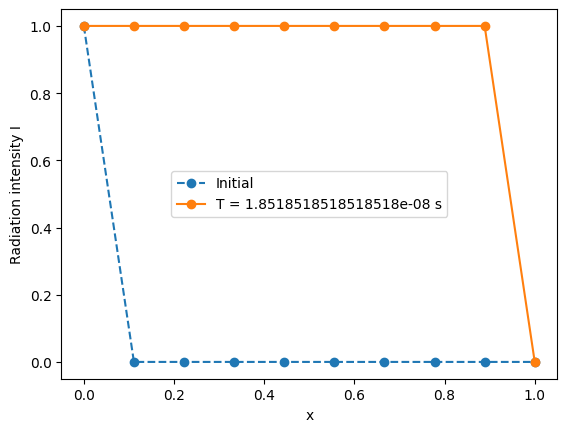

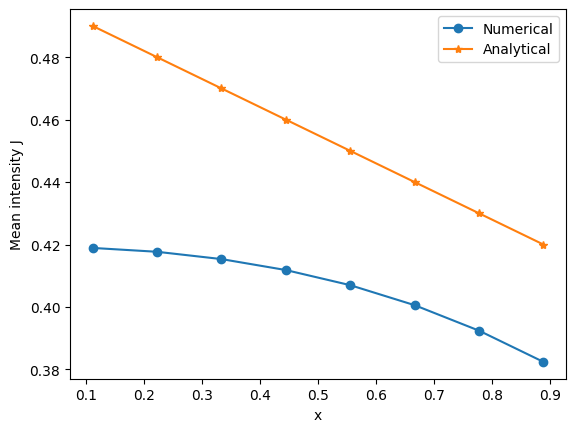

In [209]:
class RT_FD_problem:
    """
    Description : Solves a simplified 1-D time-dependent RT equation using the upwind finite difference method. Equation
    can be solved using both implicit and explicit solver.
    """
    def __init__(self, domain: list, n: list, T: float, dt: float, bc_left: float, bc_right: float, x_initial=None, CFL=None, timesteps=None, 
                 c=3e8, soln_hist=False, tt_gmres_options="config_files/1D_RT/gmres_opt.txt") -> None:
        """
        domain -> Spatial domain
        n -> List of integers of length 3 denoting the number of elements in x, theta, and phi.
        T -> Final time
        dt -> Time step size
        bc -> State value at boudary assuming dirichlets boundary condition
        x0 -> Initial solution in the domain
        c -> Speed of light which is set to 3e8 by default
        """

        self.domain = domain
        self.discretization = [None]*3
        self.dx = (domain[1] - domain[0])/(n[0]-1)
        if not(CFL is None): dt = CFL*self.dx/c
        self.dt = dt
        if not(timesteps is None): T = dt*timesteps
        self.T = T
        self.bc_left = bc_left
        self.bc_right = bc_right
        self.soln_hist = soln_hist
        self.c = c
        
        self.discretization[0] = np.linspace(domain[0], domain[1], n[0])
        self.discretization[1] = np.linspace(0, np.pi, n[1])
        self.discretization[2] = np.linspace(0, 2*np.pi, n[2])[:-1]
        self.dtheta = np.pi/(n[1]-1)
        self.dphi = 2*np.pi/(n[2]-1)
        n[2] = n[2] - 1
        k = c*dt/self.dx
        self.n = n
        
        if x_initial is None:
            x_initial = [np.zeros((1, n[0]-2, 1))]+[np.ones((1, ns, 1)) for ns in n[1:]]
            # x_initial[0][0, 0, 0] = bc_left

        self.x_initial = x_initial

        # Build upwinding operator
        sintheta = np.sin(self.discretization[1])
        cosphi = np.cos(self.discretization[2])        

        div1d_plus = divergence1d(n[0]-2, self.dx, 'fd') * (c*dt)
        div1d_minus = divergence1d(n[0]-2, self.dx, 'bd') * (c*dt)

        # Initialzie CP factor matrices and boundary condition array 
        CP_mat = [None]*3; b = [None]*3
        
        CP_mat[0] = np.zeros(((n[0]-2)**2, 2))
        CP_mat[0][:, 0] = div1d_plus.flatten()
        CP_mat[0][:, 1] = div1d_minus.flatten()
        b[0] = np.zeros(((n[0]-2), 2))
        b[0][-1, 0] = bc_right*k
        b[0][0, 1] = -bc_left*k

        CP_mat[1] = np.zeros(((n[1])**2, 2))
        CP_mat[1][:, 0] = np.diag(sintheta).flatten()
        CP_mat[1][:, 1] = np.diag(sintheta).flatten()
        b[1] = np.zeros((n[1], 2))
        b[1][:, 0] = sintheta
        b[1][:, 1] = sintheta
        # b[1][:, 0] = np.ones((n[1]))
        # b[1][:, 1] = np.ones((n[1]))

        CP_mat[2] = np.zeros(((n[2])**2, 2))
        b[2] = np.zeros((n[2], 2))
        mask = cosphi > 0
        tmp = cosphi.copy()
        # tmp = np.ones((n[2]))
        tmp[mask] = 0
        CP_mat[2][:, 0] = np.diag(tmp).flatten()
        b[2][:, 0] = tmp
        
        mask = cosphi < 0
        tmp = cosphi.copy()
        # tmp = np.ones((n[2]))
        tmp[mask] = 0
        CP_mat[2][:, 1] = np.diag(tmp).flatten()
        b[2][:, 1] = tmp
        
        # Convert to TT
        self.opt = cp_to_tt([1]*2, CP_mat)
        self.b = cp_to_tt([1]*2, b)

        # Create identity tensor in TT format
        tmp = [None]*3
        tmp[0] = (np.eye(n[0]-2).flatten())[np.newaxis, :, np.newaxis]
        tmp[1] = (np.eye(n[1]).flatten())[np.newaxis, :, np.newaxis]
        tmp[2] = (np.eye(n[2]).flatten())[np.newaxis, :, np.newaxis]
        self.I_tt = tmp
    

        # GMRES options
        self.gmres_options = {}
        with open(tt_gmres_options, 'r') as file:
            for line in file:
                key, value = line.strip().split('=')
                self.gmres_options[key] = ast.literal_eval(value)


    def solve(self, option='implicit'):
        if self.soln_hist:
            hist_storage = []
        n = self.n
        if option == 'explicit':
            A = [s.reshape((s.shape[0], n[i]-2, n[i]-2, -1)) for i, s in enumerate(self.opt[0:1])] + [s.reshape((
                s.shape[0], n[i+1], n[i+1], -1)) for i, s in enumerate(self.opt[1:])]
            currsoln = self.x_initial
            for i in range(int(self.T/self.dt)):
                tmp = tt_matvec(A, currsoln)
                tmp = tt_add(tmp, self.b)
                tmp[0] = -tmp[0]
                currsoln = tt_add(currsoln, tmp)
                print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
                currsoln, _ = tt_rounding(currsoln)
                if self.soln_hist: hist_storage.append(currsoln)
        
        elif option == 'implicit':
            currsoln = self.x_initial
            tmp = [s.reshape((s.shape[0], n[i]-2, n[i]-2, -1)) for i, s in enumerate(tt_rounding_gram_svd_rlr(tt_add(self.opt, self.I_tt))[0][0:1])] + [s.reshape((
                s.shape[0], n[i+1], n[i+1], -1)) for i, s in enumerate(tt_rounding_gram_svd_rlr(tt_add(self.opt, self.I_tt))[0][1:])]
            for i in range(int(self.T/self.dt)):
                rhs = (self.b).copy()
                rhs[0] = -rhs[0]
                rhs = tt_rounding_gram_svd_rlr(tt_add(currsoln, rhs))[0]
                currsoln, _ = tt_gmres(tmp, rhs, None, **self.gmres_options)
                print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
                if self.soln_hist: hist_storage.append(currsoln)
        
        self.currsoln = currsoln
        if self.soln_hist: self.hist_storage = hist_storage
        return currsoln
    
    def x_variation(self, ttcores, theta_index, phi_index):
        return np.einsum('ij,jk,kl->i', ttcores[0][0], ttcores[1][:, theta_index, :], ttcores[2][:, phi_index, :])

    
    def plot_final_solution(self, theta_index: int, phi_index: int):
        fig, axs = plt.subplots()
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], marker="o", label="Initial", linestyle='--')
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Radiation intensity I")
        axs.legend()
        # axs.set_title("(", u_index, v_index, ")")

        return fig
    
    def plot_solution_variation(self, theta_index: int, phi_index: int, plot_type='contour'):
        taxis = np.linspace(0, self.T, int(self.T/self.dt)+1)
        sol = np.zeros((len(taxis), self.n[0]))
        sol[0, 0] = self.bc_left; sol[0, -1] = self.bc_right
        for i in range(len(self.hist_storage)):
            curr = self.hist_storage[i]
            tmp = (curr[0][0, ...] @ curr[1][:, theta_index, :] @ curr[2][:, phi_index, :])[:, 0]
            sol[i+1, :] = [self.bc_left]+list(tmp)+[self.bc_right]
        X, Y = np.meshgrid(self.discretization[0], taxis)
        if plot_type=='surface': 
            fig = plt.figure()
            axs = fig.add_subplot(111, projection='3d')
            cp = axs.plot_surface(X, Y, sol, cmap='coolwarm', edgecolor='none')
        elif plot_type=='contour': 
            fig, axs = plt.subplots()
            cp = axs.contourf(X, Y, sol, levels=50, cmap='viridis')
        fig.colorbar(cp, ax=axs)
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Time (s)")
        # axs.set_title('Contour Plot')

        return fig

    def plot_J(self, plot_fig=True):
        I = self.currsoln.copy()
        sh = I[0].shape
        tmp = I[0]
        I[0] = np.zeros((sh[0], sh[1]+2, sh[-1]))
        I[0][:, 1:-1, :] = tmp
        sintheta = np.ones((self.n[1]))
        cosphi = np.ones((self.n[2]))
        # sintheta = np.sin(self.discretization[1])
        # cosphi = np.cos(self.discretization[2])
        Ib = [np.zeros((1, sh[1]+2, 1)), sintheta[np.newaxis, :, np.newaxis], cosphi[np.newaxis, :, np.newaxis]]
        Ib[0][0, 0, 0] = self.bc_left; Ib[0][0, -1, 0] = self.bc_right
        I = tt_add(I, Ib)
        
        sintheta = np.sin(self.discretization[1])
        # costheta = np.cos(self.discretization[2])
        dtheta = sintheta*np.array([self.dtheta/2]+[self.dtheta]*(self.n[1]-2)+[self.dtheta/2])
        dphi = np.array([self.dphi/2]+[self.dphi]*(self.n[2]-2)+[self.dphi/2])
        I[1] = np.einsum('ijk,j->ik', I[1], dtheta)
        I[2] = np.einsum('ijk,j->i', I[2], dphi)
        self.E = (I[0][0] @ I[1] @ I[2])/self.c
        self.J = self.E*self.c/(4*np.pi)

        if plot_fig:
            plt.figure()
            intt = np.linspace(self.domain[0], self.domain[1], self.n[0])[1:-1]
            plt.plot(intt, self.J[1:-1], marker='o', label="Numerical")
            plt.plot(intt, 0.5 * (1 - intt/(prob.c*prob.T)), marker='*', label="Analytical") 
            plt.xlabel(r"x")
            plt.ylabel(r"Mean intensity J")
            plt.legend()


                
prob = RT_FD_problem(domain=[0, 1], n=[10, 15, 20], T=(10/3)*1e-9, dt=(1/6)*1e-9, bc_left=1, bc_right=0, CFL=1, timesteps=50, x_initial=None, soln_hist=True)
# # print([s.shape for s in prob.b])
print("CFL number = ", prob.c*prob.dt/prob.dx)
soln1 = prob.solve('explicit')
# # soln2 = prob.solve('implicit')
fig = prob.plot_final_solution(7, 0)
prob.plot_J(True)

In [210]:
[s.shape for s in prob.opt]

[(1, 64, 2), (2, 225, 2), (2, 361, 1)]

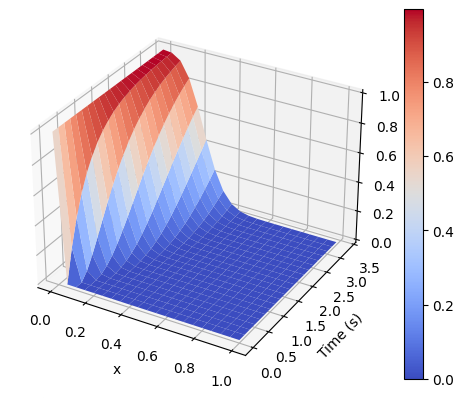

In [68]:
fig = prob.plot_solution_variation(7, 0, 'surface')

In [69]:
def RT_profiler():
    prob = RT_FD_problem(domain=[-1, 1], n=[50, 20, 20], T=(20/3)*1e-9, dt=(1)*1e-9, bc_left=1, bc_right=0, x_initial=None, soln_hist=True)
    # soln1 = prob.solve('explicit')
    soln2 = prob.solve('implicit')
# profile_f(RT_profiler, "Results/RT_prof.prof", False, True)
# profile_f(RT_profiler, "Results/RT_prof_gram.prof", False, True)

##### 1-D Explicit Finite-Volume method using the Asymptotic preserving Flux

In [76]:
class RT_1D_APF:
    """
    Description : Solves a simplified 1-D time-dependent RT equation using an FVM solver that incorporates a modified HLL flux (Asymptotic preserving) 
    """
    def __init__(self, domain: list, n: list, T: float, dt: float, bc_left: float, bc_right: float, alpha_a: np.array, alpha_s: np.array, CFL=None, timesteps=None, 
                 a_r=1, c_v=718, x_initial=None, c=3e8, soln_hist=False, tau_threshold=1e-3, beta=4, rounding_tol=1e-6, tt_gmres_options="config_files/1D_RT/gmres_opt.txt") -> None:
        """
        domain -> Spatial domain
        n -> List of integers of length 3 denoting the number of interior cell points in x and elements in theta, and phi.
        T -> Final time
        dt -> Time step size
        bc -> State value at boudary assuming dirichlets boundary condition
        x0 -> Initial solution in the domain
        c -> Speed of light which is set to 3e8 by default
        """
        self.domain = domain
        self.discretization = [None]*3
        self.dx = (domain[1] - domain[0])/(n[0])
        if not(CFL is None): dt = CFL*self.dx/c
        self.dt = dt
        if not(timesteps is None): T = dt*timesteps
        self.T = T
        self.bc_left = bc_left
        self.bc_right = bc_right
        self.soln_hist = soln_hist
        self.c = c
        self.tau_threshold = tau_threshold
        self.beta = beta
        self.alpha_a = alpha_a
        self.alpha_s = alpha_s
        self.a_r = a_r
        self.c_v = c_v
        self.rho = np.ones((n[0]))
        self.rounding_tol = rounding_tol

        self.discretization[0] = np.linspace(domain[0]+self.dx/2, domain[1]-self.dx/2, n[0])
        self.discretization[1] = np.linspace(0, np.pi, n[1])
        self.discretization[2] = np.linspace(0, 2*np.pi, n[2])[:-1]
        self.dtheta = np.pi/(n[1]-1)
        self.dphi = 2*np.pi/(n[2]-1)
        n[2] = n[2] - 1
        self.n = n
        
        if x_initial is None:
            x_initial = [np.zeros((1, n[0], 1))]+[np.ones((1, ns, 1)) for ns in n[1:]]
            # x_initial[0][0, 0, 0] = bc_left

        self.x_initial = x_initial
        self.currsoln = x_initial
        self.Temp = np.zeros((n[0])) # Need to setup proper intial conditions for temperature
        
        alpha_a = np.array([alpha_a[0]]+list(alpha_a)+[alpha_a[-1]]); alpha_s = np.array([alpha_s[0]]+list(alpha_s)+[alpha_s[-1]]) # Ghost cell approach
        alpha_sum = alpha_a + alpha_s
        self.tau = (2*beta*self.dx)/(1/(alpha_sum[:-1]) + 1/(alpha_sum[1:]))
        sintheta = np.sin(self.discretization[1])
        cosphi = np.cos(self.discretization[2])
        
        # Mask all the spatial locations according to the value of tau at that spatial location
        tau_mask_greater = self.tau >= tau_threshold
        tau_mask_lesser = self.tau < tau_threshold

        SR = []
        SR.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SR.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        SR.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SR.append(-self.tau)

        SL = []
        SL.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SL.append(-self.tau)
        SL.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SL.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        
        SR = np.array(SR); SL = np.array(SL)
        
        exprR = (SR - SR*SL)/(SR - SL)
        exprL = (SL - SR*SL)/(SR - SL)
        exprL =  np.nan_to_num(exprL, posinf=0, neginf=0); exprR =  np.nan_to_num(exprR, posinf=0, neginf=0)
        
        exprR[::2, ~tau_mask_greater] = 0
        exprR[1::2, ~tau_mask_lesser] = 0
        exprL[::2, ~tau_mask_greater] = 0
        exprL[1::2, ~tau_mask_lesser] = 0
        
        print(exprR)
        op = [np.zeros((n[0], n[0])) for _ in range(4)]
        diag = np.arange(n[0])

        # Ghost cell approach for boundary conditions 
        self.b = [None]*3
        self.b[0] = np.zeros((n[0], 4))
        self.b[1] = np.array([sintheta]*4).T
        self.b[2] = np.array([cosphi]*4).T
        for i in range(4):
            # Ghost cell approach
            op[i][diag, diag] = exprL[i, :-1] + exprR[i, 1:]
            self.b[0][0, i] = -exprR[i, 0]*bc_left; self.b[0][-1, i] = -exprL[i, -1]*bc_right
            op[i][diag[:-1], diag[1:]] = -exprL[i, 1:-1]
            op[i][diag[1:], diag[:-1]] = -exprR[i, 1:-1]
            # op[i] = np.kron(op[i], np.eye(n[0])) + np.kron(np.eye(n[0]), op[i])

            
            # # Non-ghost cell approach
            # op[i][diag[1:-1], diag[1:-1]] = exprL[i, :-1] + exprR[i, 1:]
            # op[i][0, 0] = exprR[i, 0]; op[i][-1, -1] = exprL[i, -1]
            # op[i][diag[:-1], diag[1:]] = -exprL[i, :]
            # op[i][diag[1:], diag[:-1]] = -exprR[i, :]

                
        # Mask all the angular locations according to the value of cos(phi)
        phi_mask_greater = np.cos(self.discretization[2]) >= 0
        cosphi_pos = cosphi.copy()
        cosphi_pos[~phi_mask_greater] = 0
        cosphi_neg = cosphi.copy()
        cosphi_neg[phi_mask_greater] = 0

        # Ghost cell approach for boundary (... continued)
        self.b[2][:, :2][~phi_mask_greater.T] = 0
        self.b[2][:, 2:][phi_mask_greater.T] = 0
        self.b = cp_to_tt([1]*4, self.b)

    
        space_op = np.array([s.flatten() for s in op]).T
        theta_op = np.array([np.diag(sintheta).flatten()]*4).T
        phi_op = np.array([np.diag(cosphi_pos).flatten()]*2 + [np.diag(cosphi_neg).flatten()]*2).T
        
        self.tt_op = cp_to_tt([1]*4, [space_op, theta_op, phi_op])

        # # Boundary conditions for non-ghost cell approach
        # self.b = [None]*3
        # self.b[0] = np.zeros((n[0]))
        # self.b[0][0] = -bc_left; self.b[0][-1] = bc_right
        # self.b[0] = self.b[0][np.newaxis, :, np.newaxis]

        # self.b[1] = sintheta[np.newaxis, :, np.newaxis]
        # self.b[2] = cosphi[np.newaxis, :, np.newaxis]
        
        
        # # Set very small values to zero
        # for i in range(3):
        #     self.b[i][np.abs(self.b[i]) < 1e-13] = 0
        #     self.tt_op[i][np.abs(self.tt_op[i]) < 1e-13] = 0   


    def newton_raphson(self, f, fprime, x0, tol=1e-6, maxiter=1000):
        currx = x0
        func = f(currx)
        k = 0
        while func.any() > tol and k < maxiter:
            deri = fprime(currx)
            # delx = np.linalg.solve(np.diag(deri), -func)
            delx = -func/deri
            currx += delx
            func = f(currx)
            k += 1
        return currx


    def flux_solver(self, source=False, dt=None, prt=False):
        if dt is None: dt = self.dt
        k = lambda dt: self.c*dt/self.dx
        if self.soln_hist: hist_storage = []
        currsoln = self.currsoln
        tmp = [s.reshape((s.shape[0], self.n[i], self.n[i], s.shape[-1])) for i, s in enumerate(self.tt_op)]
        tmp[0] = k(dt)*tmp[0]
        b = (self.b).copy()
        b[0] = k(dt) * b[0]

        if source: counter = 1
        else: counter = int(self.T/self.dt)
    
        for i in range(counter):
            tmpsoln = tt_add(tt_matvec(tmp, currsoln), b)
            tmpsoln[0] = -tmpsoln[0]
            currsoln = tt_add(currsoln, tmpsoln)
            currsoln = tt_rounding_gram_svd_rlr(currsoln, eps=self.rounding_tol)[0]
            if prt: print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
            if self.soln_hist: hist_storage.append(currsoln)
        
        self.currsoln = currsoln
        self.hist_storage = hist_storage
        # print([s.shape for s in tt_op])
        return currsoln


    def source_solver(self, dt=None):
        if dt is None: dt = self.dt
        currsoln = self.currsoln.copy()
        currTemp = self.Temp.copy()
        currJ = self.J.copy()

        # Evaluate constants
        chi_t = 1/(1/(self.c*dt) + (self.alpha_a + self.alpha_s))
        chi_a = 1/(1/(self.c*dt) + (self.alpha_a))
        zeta = self.alpha_a/(self.c_v * self.rho)

        # Solve for T
        tmp = zeta*chi_a
        f = lambda t: self.a_r*tmp*np.power(t, 4) + t + (-tmp*(4*np.pi/self.c)*currJ - currTemp)
        fprime = lambda t: 4*self.a_r*tmp*np.power(t, 3) + 1
        currTemp = self.newton_raphson(f, fprime, currTemp)

        # Get J
        currJ = chi_a * (currJ/(self.c * self.dt) + self.c * self.a_r/(4*np.pi) * self.alpha_a * np.power(currTemp, 4))

        # Get updated I
        tmp = chi_t * (self.c * self.a_r/(4*np.pi) * self.alpha_a * np.power(currTemp, 4) + self.alpha_s * currJ)
        tmp = [tmp[np.newaxis, :, np.newaxis], np.ones((self.n[1])), np.ones((self.n[2]))]
        currsoln[0] = currsoln[0] * (chi_t/(self.c * dt))[np.newaxis, :, np.newaxis]
        self.Temp = currTemp
        self.J = currJ
        self.currsoln = currsoln
    
    
    def solver(self):
        # Setup initial conditions
        self.J = self.get_J(self.currsoln.copy())
        
        # Start timestepping
        for i in range(int(self.T/self.dt)):
            self.flux_solver(source=True, dt=self.dt/2)
            self.source_solver(dt=self.dt)
            self.flux_solver(source=True, dt=self.dt/2)
            print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(self.currsoln))


    def x_variation(self, ttcores, theta_index, phi_index):
        return np.einsum('ij,jk,kl->i', ttcores[0][0], ttcores[1][:, theta_index, :], ttcores[2][:, phi_index, :])
    

    def plot_final_solution(self, theta_index: int, phi_index: int):
        fig, axs = plt.subplots()
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], label="Initial", linestyle='--')
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], marker="o", label="Initial")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Radiation intensity I")
        axs.legend()
        # axs.set_title("(", u_index, v_index, ")")

        return fig
    

    def plot_solution_variation(self, theta_index: int, phi_index: int, plot_type='contour'):
        taxis = np.linspace(0, self.T, int(self.T/self.dt)+1)
        sol = np.zeros((len(taxis), self.n[0]+2))
        sol[0, 0] = self.bc_left; sol[0, -1] = self.bc_right
        for i in range(len(self.hist_storage)):
            curr = self.hist_storage[i]
            tmp = (curr[0][0, ...] @ curr[1][:, theta_index, :] @ curr[2][:, phi_index, :])[:, 0]
            sol[i+1, :] = [self.bc_left]+list(tmp)+[self.bc_right]
        X, Y = np.meshgrid(self.domain[0:1]+list(self.discretization[0])+self.domain[-1:], taxis)
        if plot_type=='surface': 
            fig = plt.figure()
            axs = fig.add_subplot(111, projection='3d')
            cp = axs.plot_surface(X, Y, sol, cmap='coolwarm', edgecolor='none')
        elif plot_type=='contour': 
            fig, axs = plt.subplots()
            cp = axs.contourf(X, Y, sol, levels=50, cmap='viridis')
        fig.colorbar(cp, ax=axs)
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Time (s)")
        # axs.set_title('Contour Plot')

        return fig
    
    def get_J(self, I):
        sintheta = np.sin(self.discretization[1])
        dtheta = sintheta*np.array([self.dtheta/2]+[self.dtheta]*(self.n[1]-2)+[self.dtheta/2])
        dphi = np.array([self.dphi/2]+[self.dphi]*(self.n[2]-2)+[self.dphi/2])
        I[1] = np.einsum('ijk,j->ik', I[1], dtheta)
        I[2] = np.einsum('ijk,j->i', I[2], dphi)
        J = (I[0][0] @ I[1] @ I[2])/(4*np.pi)
        return J
    
    def plot_J(self, plot_fig=True):
        I = self.currsoln.copy()
        # sh = I[0].shape
        # tmp = I[0]
        # I[0] = np.zeros((sh[0], sh[1]+2, sh[-1]))
        # I[0][:, 1:-1, :] = tmp
        # sintheta = np.ones((self.n[1]))
        # cosphi = np.ones((self.n[2]))
        # Ib = [np.zeros((1, sh[1]+2, 1)), sintheta[np.newaxis, :, np.newaxis], cosphi[np.newaxis, :, np.newaxis]]
        # Ib[0][0, 0, 0] = self.bc_left; Ib[0][0, -1, 0] = self.bc_right
        # I = tt_add(I, Ib)
        J = self.get_J(I)
        E = J*(4*np.pi)/self.c

        if plot_fig:
            plt.figure()
            intt = np.concatenate(([self.domain[0]], self.discretization[0], [self.domain[1]]))
            anasoln = 0.5 * (1 - intt/(self.c*self.T))
            anasoln[intt > self.c*self.T] = 0
            plt.plot(intt[1:-1], J, marker='o', label="Numerical")
            plt.plot(intt[1:-1], anasoln[1:-1], label="Analytical") 
            plt.xlabel(r"x")
            plt.ylabel(r"Mean intensity J")
            plt.legend()


n = [4, 5, 95]
prob2 = RT_1D_APF(domain=[0, 1], n=n, T=(25/48)*1e-9, dt=(1/48)*1e-9, bc_left=1, bc_right=0, 
                  alpha_a=1e-8*np.ones(n[0]), alpha_s=1e-8*np.ones(n[0]), soln_hist=True, CFL=0.8, timesteps=1, rounding_tol=1e-5)
# print("CFL number = ", prob2.c*prob2.dt/prob2.dx)
# # prob2.flux_solver(prt=False)
# prob2.solver()
# fig = prob2.plot_final_solution(7, 0)
# prob2.plot_J()
# # print([s.shape for s in prob2.tt_op])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.30872238e-24 3.30872238e-24 3.30872238e-24 3.30872238e-24
  3.30872238e-24]]


##### 2-D Explicit Finite-Volume method using the Asymptotic preserving Flux

TypeError: unsupported operand type(s) for *: 'int' and 'function'

CFL number =  0.5000000000000001
1  Time passed : 3.3333333333333337e-10 s 		 Solution ranks :  [1, 2, 2, 1]
2  Time passed : 6.666666666666667e-10 s 		 Solution ranks :  [1, 4, 2, 1]
3  Time passed : 1e-09 s 		 Solution ranks :  [1, 4, 2, 1]
4  Time passed : 1.3333333333333335e-09 s 		 Solution ranks :  [1, 4, 2, 1]
5  Time passed : 1.666666666666667e-09 s 		 Solution ranks :  [1, 4, 2, 1]


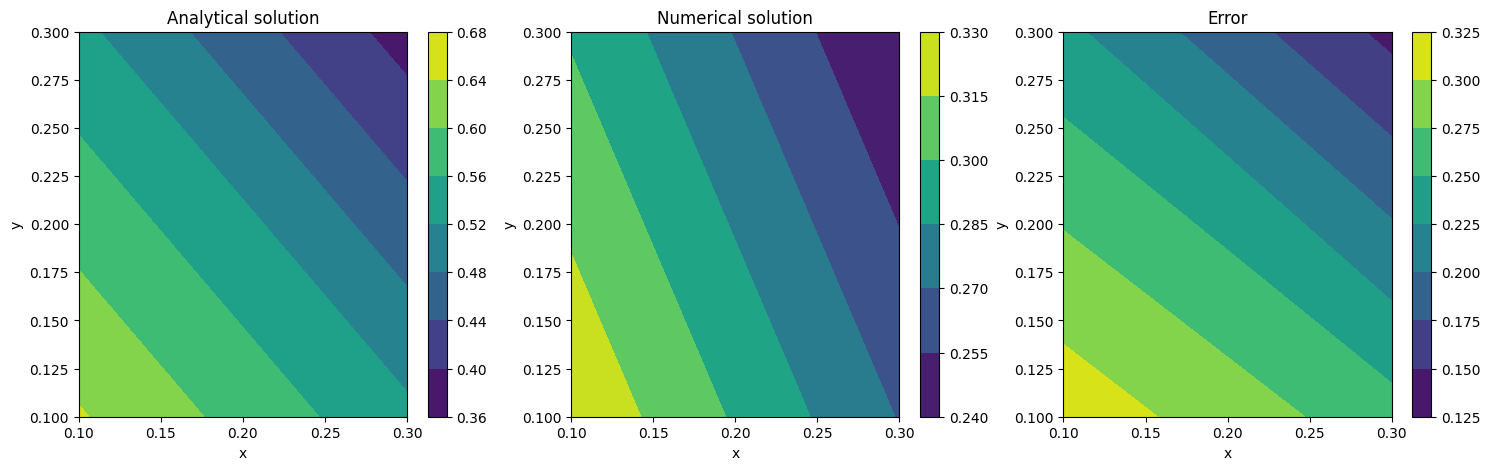

In [713]:
# Only updated problem setup, flux_solver, analytical soln, x_variation
class RT_2D_APF:
    """
    Description : Solves a simplified 1-D time-dependent RT equation using an FVM solver that incorporates a modified HLL flux (Asymptotic preserving) 
    """
    def __init__(self, domain: list, n: list, T: float, dt: float, bc_left: float, bc_right: float, alpha_a: np.array, alpha_s: np.array, 
                 alpha_threshold=1e-8, CFL=None, timesteps=None, a_r=1, c_v=718, Temp=0, x_initial=None, c=3e8, soln_hist=False, tau_threshold=1e-3, 
                 beta=4, record_ranks=True, rounding_eps=1e-3, tt_gmres_options="config_files/1D_RT/gmres_opt.txt") -> None:
        """
        domain -> Spatial domain
        n -> List of integers of length 3 denoting the number of interior cell points in x and elements in theta, and phi.
        T -> Final time
        dt -> Time step size
        bc -> State value at boudary assuming dirichlets boundary condition
        x0 -> Initial solution in the domain
        c -> Speed of light which is set to 3e8 by default
        """
        self.domain = domain
        self.discretization = [None]*3
        self.dx = (domain[1] - domain[0])/(n[0])
        if not(CFL is None): dt = CFL*self.dx/c
        self.dt = dt
        if not(timesteps is None): T = dt*timesteps
        self.T = T
        self.bc_left = bc_left
        self.bc_right = bc_right
        self.soln_hist = soln_hist
        self.c = c
        self.tau_threshold = tau_threshold
        self.beta = beta
        self.alpha_a = alpha_a
        self.alpha_s = alpha_s
        self.a_r = a_r
        self.c_v = c_v
        self.rounding_eps = rounding_eps
        self.rho = np.ones((n[0]**2))
        self.record_ranks = record_ranks

        self.discretization[0] = np.linspace(domain[0]+self.dx/2, domain[1]-self.dx/2, n[0])
        self.discretization[1] = np.linspace(0, np.pi, n[1])
        self.discretization[2] = np.linspace(0, 2*np.pi, n[2])[:-1]
        self.dtheta = np.pi/(n[1]-1)
        self.dphi = 2*np.pi/(n[2]-1)
        n[2] = n[2] - 1
        self.n = n
        
        if x_initial is None:
            x_initial = [np.zeros((1, n[0]**2, 1))]+[np.zeros((1, ns, 1)) for ns in n[1:]]
            # x_initial[0][0, 0, 0] = bc_left

        self.x_initial = x_initial
        self.currsoln = x_initial
        self.Temp = Temp*np.ones((n[0]**2)) # Need to setup proper intial conditions for temperature
        
        alpha_a = np.maximum(alpha_a, alpha_threshold*np.ones_like(alpha_a)); alpha_s = np.maximum(alpha_s, alpha_threshold*np.ones_like(alpha_s))
        alpha_a = np.array([alpha_a[0]]+list(alpha_a)+[alpha_a[-1]]); alpha_s = np.array([alpha_s[0]]+list(alpha_s)+[alpha_s[-1]]) # Ghost cell approach
        alpha_sum = alpha_a + alpha_s
        self.tau = (2*beta*self.dx)/(1/(alpha_sum[:-1]) + 1/(alpha_sum[1:]))
        sintheta = np.sin(self.discretization[1])
        cosphi = np.cos(self.discretization[2])
        sinphi = np.sin(self.discretization[2])
        
        # Mask all the spatial locations according to the value of tau at that spatial location
        tau_mask_greater = self.tau >= tau_threshold
        tau_mask_lesser = self.tau < tau_threshold

        SR = []
        SR.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SR.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        SR.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SR.append(-self.tau)

        SL = []
        SL.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SL.append(-self.tau)
        SL.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SL.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        
        SR = np.array(SR); SL = np.array(SL)
        
        exprR = (SR - SR*SL)/(SR - SL)
        exprL = (SL - SR*SL)/(SR - SL)
        exprL =  np.nan_to_num(exprL, posinf=0, neginf=0); exprR =  np.nan_to_num(exprR, posinf=0, neginf=0)
        
        exprR[::2, ~tau_mask_greater] = 0
        exprR[1::2, ~tau_mask_lesser] = 0
        exprL[::2, ~tau_mask_greater] = 0
        exprL[1::2, ~tau_mask_lesser] = 0
        
    
        opx = [np.zeros((n[0], n[0])) for _ in range(4)]
        opy = [np.zeros((n[0], n[0])) for _ in range(4)]
        diag = np.arange(n[0]**2)

        # Ghost cell approach for boundary conditions 
        self.bx = [None]*3
        self.bx[0] = np.zeros((n[0]**2, 4))
        self.bx[1] = np.array([sintheta]*4).T
        self.bx[2] = np.array([cosphi]*4).T

        self.by = [None]*3
        self.by[0] = np.zeros((n[0]**2, 4))
        self.by[1] = np.array([sintheta]*4).T
        self.by[2] = np.array([sinphi]*4).T

        for i in range(4):
            # Ghost cell approach
            tmp = np.zeros((n[0]))
            tmp[0] = -exprR[i, 0]*bc_left; tmp[-1] = -exprL[i, -1]*bc_right
            self.bx[0][:, i] = np.kron(tmp, np.ones_like(tmp))
            self.by[0][:, i] = np.kron(np.ones_like(tmp), tmp) 
            
            # opx[i][diag, diag] = exprL[i, :-1] + exprR[i, 1:] # Replacing this code with a more efficient version
            # opx[i][diag[:-1], diag[1:]] = -exprL[i, 1:-1]
            # opx[i][diag[1:], diag[:-1]] = -exprR[i, 1:-1]
            # opx[i] = np.kron(opx[i], np.eye(n[0]))
            tmp = np.zeros((n[0]**2, n[0]**2)) # Efficient version
            tmp[diag, diag] = np.kron(np.ones((n[0])), exprL[i, :-1] + exprR[i, 1:])
            tmp[diag[:-1], diag[1:]] = np.kron(np.ones((n[0])), np.concatenate((-exprL[i, 1:-1], [0])))[:-1]
            tmp[diag[1:], diag[:-1]] = np.kron(np.ones((n[0])), np.concatenate((-exprR[i, 1:-1], [0])))[:-1]
            opy[i] = tmp
            
            tmp = np.zeros((n[0]**2, n[0]**2))
            tmp[diag, diag] = np.kron(exprL[i, :-1] + exprR[i, 1:], np.ones((n[0])))
            tmp[diag[:-n[0]], diag[n[0]:]] = np.kron(-exprL[i, 1:-1], np.ones((n[0])))
            tmp[diag[n[0]:], diag[:-n[0]]] = np.kron(-exprR[i, 1:-1], np.ones((n[0])))
            opx[i] = tmp
            
            
            # # Non-ghost cell approach
            # op[i][diag[1:-1], diag[1:-1]] = exprL[i, :-1] + exprR[i, 1:]
            # op[i][0, 0] = exprR[i, 0]; op[i][-1, -1] = exprL[i, -1]
            # op[i][diag[:-1], diag[1:]] = -exprL[i, :]
            # op[i][diag[1:], diag[:-1]] = -exprR[i, :]

                
        # Mask all the angular locations according to the value of cos(phi)
        phi_mask_greater = cosphi >= 0
        cosphi_pos = cosphi.copy()
        cosphi_pos[~phi_mask_greater] = 0
        cosphi_neg = cosphi.copy()
        cosphi_neg[phi_mask_greater] = 0

        # Ghost cell approach for boundary (... continued)
        self.bx[2][:, :2][~phi_mask_greater.T] = 0
        self.bx[2][:, 2:][phi_mask_greater.T] = 0
        self.bx = cp_to_tt([1]*4, self.bx)

        # Mask all the angular locations according to the value of sin(phi)
        phi_mask_greater = sinphi >= 0
        sinphi_pos = sinphi.copy()
        sinphi_pos[~phi_mask_greater] = 0
        sinphi_neg = sinphi.copy()
        sinphi_neg[phi_mask_greater] = 0

        # Ghost cell approach for boundary (... continued)
        self.by[2][:, :2][~phi_mask_greater.T] = 0
        self.by[2][:, 2:][phi_mask_greater.T] = 0
        self.by = cp_to_tt([1]*4, self.by)

        self.b = tt_rounding(tt_add(self.bx, self.by))[0]


        space_op = np.array([s.flatten() for s in opx]).T
        theta_op = np.array([np.diag(sintheta).flatten()]*4).T
        phi_op = np.array([np.diag(cosphi_pos).flatten()]*2 + [np.diag(cosphi_neg).flatten()]*2).T
        self.tt_opx = cp_to_tt([1]*4, [space_op, theta_op, phi_op])

        space_op = np.array([s.flatten() for s in opy]).T
        theta_op = np.array([np.diag(sintheta).flatten()]*4).T
        phi_op = np.array([np.diag(sinphi_pos).flatten()]*2 + [np.diag(sinphi_neg).flatten()]*2).T
        self.tt_opy = cp_to_tt([1]*4, [space_op, theta_op, phi_op])
        
        self.tt_op = tt_rounding_gram_svd_rlr(tt_add(self.tt_opx, self.tt_opy))[0]
        
        # # Boundary conditions for non-ghost cell approach
        # self.b = [None]*3
        # self.b[0] = np.zeros((n[0]))
        # self.b[0][0] = -bc_left; self.b[0][-1] = bc_right
        # self.b[0] = self.b[0][np.newaxis, :, np.newaxis]

        # self.b[1] = sintheta[np.newaxis, :, np.newaxis]
        # self.b[2] = cosphi[np.newaxis, :, np.newaxis]   

        # Set very small values to zero
        for i in range(3):
            self.b[i][np.abs(self.b[i]) < 1e-13] = 0
            self.tt_op[i][np.abs(self.tt_op[i]) < 1e-13] = 0


    def newton_raphson(self, f, fprime, x0, tol=1e-6, maxiter=1000):
        currx = x0
        func = f(currx)
        k = 0
        while func.any() > tol and k < maxiter:
            deri = fprime(currx)
            # delx = np.linalg.solve(np.diag(deri), -func)
            delx = -func/deri
            currx += delx
            func = f(currx)
            k += 1
        return currx


    def flux_solver(self, source=False, dt=None, prt=False):
        rank_hist = []
        if dt is None: dt = self.dt
        k = lambda dt: self.c*dt/self.dx
        if self.soln_hist: hist_storage = []
        currsoln = self.currsoln
        tmp = [self.tt_op[0].reshape((self.tt_op[0].shape[0], self.n[0]**2, self.n[0]**2, -1))]+[s.reshape(
            (s.shape[0], self.n[i+1], self.n[i+1], -1)) for i, s in enumerate(self.tt_op[1:])]
        tmp[0] = k(dt)*tmp[0]
        b = (self.b).copy()
        b[0] = k(dt) * b[0]

        if source: counter = 1
        else: counter = int(self.T/self.dt)
    
        for i in range(counter):
            tmpsoln = tt_add(tt_matvec(tmp, currsoln), b)
            tmpsoln[0] = -tmpsoln[0]
            currsoln = tt_add(currsoln, tmpsoln)
            currsoln = tt_rounding_gram_svd_rlr(currsoln, eps=self.rounding_eps)[0]
            if self.record_ranks: rank_hist.append(get_tt_rank(currsoln))
            if prt: print(f"{i+1}  Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
            if self.soln_hist: hist_storage.append(currsoln)
        
        self.currsoln = currsoln
        self.hist_storage = hist_storage
        self.rank_hist = rank_hist
        # print([s.shape for s in tt_op])
        return currsoln


    def source_solver(self, dt=None):
        if dt is None: dt = self.dt
        currsoln = self.currsoln.copy()
        currTemp = self.Temp.copy()
        currJ = self.J.copy()

        # Extending alpha to 2-D (Only accurate for a uniform alpha field)
        alpha_a = np.array(list(self.alpha_a)*self.n[0])
        alpha_s = np.array(list(self.alpha_s)*self.n[0])
        
        # Evaluate constants
        chi_t = 1/(1/(self.c*dt) + (alpha_a + alpha_s))
        chi_a = 1/(1/(self.c*dt) + (alpha_a))
        zeta = alpha_a/(self.c_v * self.rho)
        
        # Solve for T
        tmp = zeta*chi_a
        f = lambda t: self.a_r*tmp*np.power(t, 4) + t + (-tmp*(4*np.pi/self.c)*currJ - currTemp)
        fprime = lambda t: 4*self.a_r*tmp*np.power(t, 3) + 1
        currTemp = self.newton_raphson(f, fprime, currTemp)
        
        # Get J
        currJ = chi_a * (currJ/(self.c * self.dt) + self.c * self.a_r/(4*np.pi) * alpha_a * np.power(currTemp, 4))
        
        # Get updated I
        tmp = chi_t * (self.c * self.a_r/(4*np.pi) * alpha_a * np.power(currTemp, 4) + alpha_s * currJ)
        tmp = [tmp[np.newaxis, :, np.newaxis], np.ones((1, self.n[1], 1)), np.ones((1, self.n[2], 1))]
        currsoln[0] = currsoln[0] * (chi_t/(self.c * dt))[np.newaxis, :, np.newaxis]
        currsoln = tt_add(currsoln, tmp)
        self.Temp = currTemp
        self.J = currJ
        self.currsoln = currsoln
    
    
    def solver(self):
        # Setup initial conditions
        self.J = self.get_J(self.currsoln.copy())
        
        # Start timestepping
        for i in range(int(self.T/self.dt)):
            self.flux_solver(source=True, dt=self.dt/2)
            self.source_solver(dt=self.dt)
            self.flux_solver(source=True, dt=self.dt/2)
            print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(self.currsoln))


    def x_variation(self, ttcores, theta_index, phi_index):
        return np.einsum('ij,jk,kl->i', ttcores[0][0], ttcores[1][:, theta_index, :], ttcores[2][:, phi_index, :])

    
    def analytic_soln(self, t=None, c=None):
        if t is None: t = self.T
        if c is None: c = self.c
        ct = c * t
        def calc(x, y):
            n_x = np.arccos(np.minimum(np.abs(y/np.sqrt(np.maximum(ct**2 - x**2, 0))), 1))
            n_y = np.arccos(np.minimum(np.abs(x/np.sqrt(np.maximum(ct**2 - y**2, 0))), 1))

            J_l = np.zeros_like(x)
            J_b = np.zeros_like(y)
            # Element-wise comparison using NumPy's where
            J_l = np.where(x < ct,
                           0.5 - (np.pi-n_x)*x/(2*np.pi*ct) - np.arcsin(x*np.sin(n_x)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_l)

            J_b = np.where(y < ct,
                           0.5 - (np.pi-n_y)*y/(2*np.pi*ct) - np.arcsin(y*np.sin(n_y)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_b)

            # Sum J_l and J_b element-wise
            return (J_l + J_b)

        return calc

    

    def plot_final_solution(self, theta_index: int, phi_index: int):
        fig, axs = plt.subplots()
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], label="Initial", linestyle='--')
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], marker="o", label="Initial")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Radiation intensity I")
        axs.legend()
        # axs.set_title("(", u_index, v_index, ")")

        return fig
    
    
    def get_J(self, I):
        sintheta = np.sin(self.discretization[1])
        dtheta = sintheta*np.array([self.dtheta/2]+[self.dtheta]*(self.n[1]-2)+[self.dtheta/2])
        dphi = np.array([self.dphi/2]+[self.dphi]*(self.n[2]-2)+[self.dphi/2])
        I[1] = np.einsum('ijk,j->ik', I[1], dtheta)
        I[2] = np.einsum('ijk,j->i', I[2], dphi)
        J = (I[0][0] @ I[1] @ I[2])/(4*np.pi)
        return J
    

    def plot_ranks(self):
        plt.figure()
        rkhist = np.array(self.rank_hist)
        plt.plot(range(rkhist.shape[0]), rkhist[:, 1], label=r"R1")
        plt.plot(range(rkhist.shape[0]), rkhist[:, 2], label=r"R2")
        plt.xlabel("Timesteps")
        plt.ylabel("ranks")
        plt.legend()
    
    def plot_J(self, plot_fig=True, threshold=1e-6):
        I = self.currsoln.copy()
        # sh = I[0].shape
        # tmp = I[0]
        # I[0] = np.zeros((sh[0], sh[1]+2, sh[-1]))
        # I[0][:, 1:-1, :] = tmp
        # sintheta = np.ones((self.n[1]))
        # cosphi = np.ones((self.n[2]))
        # Ib = [np.zeros((1, sh[1]+2, 1)), sintheta[np.newaxis, :, np.newaxis], cosphi[np.newaxis, :, np.newaxis]]
        # Ib[0][0, 0, 0] = self.bc_left; Ib[0][0, -1, 0] = self.bc_right
        # I = tt_add(I, Ib)
        J = self.get_J(I)
        J[np.abs(J) < threshold] = 0
        # J = self.J
        E = J*(4*np.pi)/self.c

        if plot_fig:
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            intt = np.concatenate(([self.domain[0]], self.discretization[0], [self.domain[1]]))
            x_max = np.where(intt[1:-1] >= (self.domain[1] - self.c*self.T))[0][0]
            X, Y = np.meshgrid(intt[1:-1][:x_max], intt[1:-1][:x_max])
            ana = self.analytic_soln()(X, Y)
           
            c1 = axs[0].contourf(X, Y, ana)
            axs[0].set_xlabel(r"x")
            axs[0].set_ylabel(r"y")
            axs[0].set_title(r"Analytical solution")
            fig.colorbar(c1, ax=axs[0], orientation='vertical')

            c2 = axs[1].contourf(X, Y, J.reshape((n[0], n[0]))[:x_max, :x_max]) 
            axs[1].set_xlabel(r"x")
            axs[1].set_ylabel(r"y")
            axs[1].set_title(r"Numerical solution")
            fig.colorbar(c2, ax=axs[1], orientation='vertical')

            c3 = axs[2].contourf(X, Y, (ana - J.reshape((n[0], n[0]))[:x_max, :x_max])) 
            axs[2].set_xlabel(r"x")
            axs[2].set_ylabel(r"y")
            axs[2].set_title(r"Error")
            fig.colorbar(c3, ax=axs[2], orientation='vertical')
            
            

n = [5, 5, 5]
prob3 = RT_2D_APF(domain=[0, 1], n=n, T=(2)*1e-9, dt=(1/48)*1e-9, bc_left=1, bc_right=0, 
                  alpha_a=0*np.ones(n[0]), alpha_s=0*np.ones(n[0]), soln_hist=True, CFL=0.5, 
                  timesteps=5, c=3e8, rounding_eps=1e-3, record_ranks=True, a_r=1, c_v=718, Temp=1)
print("CFL number = ", prob3.c*prob3.T)
soln = prob3.flux_solver(prt=True)
# prob3.solver()
# # fig = prob3.plot_final_solution(50, 0)
prob3.plot_J()
# # [s.shape for s in prob3.tt_op]
# profile_f(lambda: prob32.flux_solver(prt=True), "Results/2D_RT.prof")

C:\Users\Aditya\AppData\Local\Temp\ipykernel_17816\1979560725.py:82: RuntimeWarning: invalid value encountered in divide
  exprR = (SR - SR*SL)/(SR - SL)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_17816\1979560725.py:83: RuntimeWarning: invalid value encountered in divide
  exprL = (SL - SR*SL)/(SR - SL)


CFL number =  0.390625
1  Time passed : 2.6041666666666667e-11 s 		 Solution ranks :  [1, 2, 2, 2, 1]
2  Time passed : 5.2083333333333334e-11 s 		 Solution ranks :  [1, 4, 7, 7, 1]
3  Time passed : 7.8125e-11 s 		 Solution ranks :  [1, 6, 14, 10, 1]
4  Time passed : 1.0416666666666667e-10 s 		 Solution ranks :  [1, 7, 17, 11, 1]
5  Time passed : 1.3020833333333334e-10 s 		 Solution ranks :  [1, 7, 20, 13, 1]
6  Time passed : 1.5625e-10 s 		 Solution ranks :  [1, 7, 23, 13, 1]
7  Time passed : 1.8229166666666667e-10 s 		 Solution ranks :  [1, 8, 25, 14, 1]
8  Time passed : 2.0833333333333334e-10 s 		 Solution ranks :  [1, 8, 27, 14, 1]
9  Time passed : 2.3437500000000003e-10 s 		 Solution ranks :  [1, 9, 30, 15, 1]
10  Time passed : 2.6041666666666667e-10 s 		 Solution ranks :  [1, 9, 32, 16, 1]
11  Time passed : 2.864583333333333e-10 s 		 Solution ranks :  [1, 9, 34, 17, 1]
12  Time passed : 3.125e-10 s 		 Solution ranks :  [1, 10, 36, 17, 1]
13  Time passed : 3.385416666666667e-10 s 	

C:\Users\Aditya\AppData\Local\Temp\ipykernel_17816\1979560725.py:280: RuntimeWarning: divide by zero encountered in divide
  n_x = np.arccos(np.minimum(np.abs(y/np.sqrt(np.maximum(ct**2 - x**2, 0))), 1))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_17816\1979560725.py:281: RuntimeWarning: divide by zero encountered in divide
  n_y = np.arccos(np.minimum(np.abs(x/np.sqrt(np.maximum(ct**2 - y**2, 0))), 1))


Average error = 0.000186


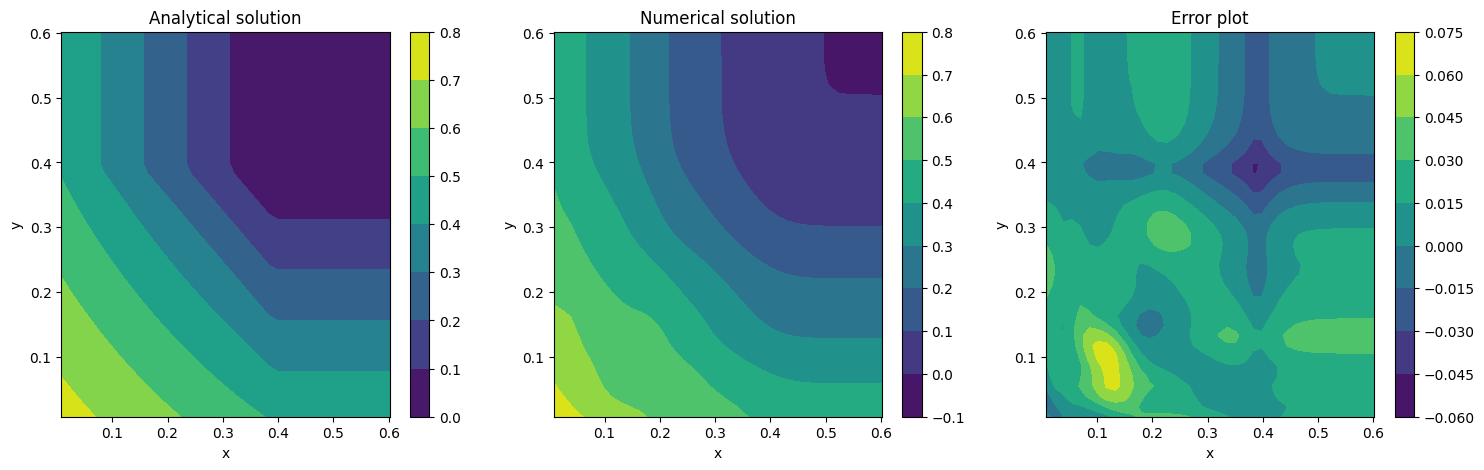

In [790]:
# Only updated problem setup, flux_solver, analytical soln, x_variation
class RT_2D_APF:
    """
    Description : Solves a simplified 1-D time-dependent RT equation using an FVM solver that incorporates a modified HLL flux (Asymptotic preserving) 
    """
    def __init__(self, domain: list, n: list, T: float, dt: float, bc_left: float, bc_right: float, alpha_a: np.array, alpha_s: np.array, 
                 alpha_threshold=1e-8, CFL=None, timesteps=None, a_r=1, c_v=718, x_initial=None, c=3e8, soln_hist=False, tau_threshold=1e-3, 
                 beta=4, rounding_eps=1e-14, record_ranks=True, tt_gmres_options="config_files/1D_RT/gmres_opt.txt") -> None:
        """
        domain -> Spatial domain
        n -> List of integers of length 3 denoting the number of interior cell points in x/y and elements in theta, and phi.
        T -> Final time
        dt -> Time step size
        bc -> State value at boudary assuming dirichlets boundary condition
        x0 -> Initial solution in the domain
        c -> Speed of light which is set to 3e8 by default
        """
        self.domain = domain
        self.discretization = [None]*3
        self.dx = (domain[1] - domain[0])/(n[0])
        if not(CFL is None): dt = CFL*self.dx/c
        self.dt = dt
        if not(timesteps is None): T = dt*timesteps
        self.T = T
        self.bc_left = bc_left
        self.bc_right = bc_right
        self.soln_hist = soln_hist
        self.c = c
        self.tau_threshold = tau_threshold
        self.beta = beta
        self.alpha_a = alpha_a
        self.alpha_s = alpha_s
        self.a_r = a_r
        self.c_v = c_v
        self.rounding_eps = rounding_eps
        self.record_ranks = record_ranks
        self.rho = np.ones((n[0]))

        self.discretization[0] = np.linspace(domain[0]+self.dx/2, domain[1]-self.dx/2, n[0])
        self.discretization[1] = np.linspace(0, np.pi, n[1])
        self.discretization[2] = np.linspace(0, 2*np.pi, n[2])[:-1]
        self.dtheta = np.pi/(n[1]-1)
        self.dphi = 2*np.pi/(n[2]-1)
        n[2] = n[2] - 1
        self.n = n
        
        if x_initial is None:
            x_initial = [np.zeros((1, n[0], 1)) for _ in range(2)]+[np.zeros((1, ns, 1)) for ns in n[1:]]
            # x_initial[0][0, 0, 0] = bc_left

        self.x_initial = x_initial
        self.currsoln = x_initial
        self.Temp = np.zeros((n[0])) # Need to setup proper intial conditions for temperature
        
        # (4.2.3 2(a))
        alpha_a = np.maximum(alpha_a, alpha_threshold*np.ones_like(alpha_a)); alpha_s = np.maximum(alpha_s, alpha_threshold*np.ones_like(alpha_s))
        alpha_a = np.array([alpha_a[0]]+list(alpha_a)+[alpha_a[-1]]); alpha_s = np.array([alpha_s[0]]+list(alpha_s)+[alpha_s[-1]]) # Ghost cell approach
        alpha_sum = alpha_a + alpha_s
        self.tau = (2*beta*self.dx)/(1/(alpha_sum[:-1]) + 1/(alpha_sum[1:]))
        sintheta = np.sin(self.discretization[1])
        cosphi = np.cos(self.discretization[2])
        sinphi = np.sin(self.discretization[2])
        
        # Mask all the spatial locations according to the value of tau at that spatial location
        tau_mask_greater = self.tau >= tau_threshold
        tau_mask_lesser = self.tau < tau_threshold

        SR = []
        SR.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SR.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        SR.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SR.append(-self.tau)

        SL = []
        SL.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SL.append(-self.tau)
        SL.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SL.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        
        SR = np.array(SR); SL = np.array(SL)
        
        exprR = (SR - SR*SL)/(SR - SL)
        exprL = (SL - SR*SL)/(SR - SL)

        # (4.2.3 2(b))
        exprL =  np.nan_to_num(exprL, posinf=0, neginf=0); exprR =  np.nan_to_num(exprR, posinf=0, neginf=0)
        
        exprR[::2, ~tau_mask_greater] = 0
        exprR[1::2, ~tau_mask_lesser] = 0
        exprL[::2, ~tau_mask_greater] = 0
        exprL[1::2, ~tau_mask_lesser] = 0
        
    
        op = [np.zeros((n[0], n[0])) for _ in range(4)]
        diag = np.arange(n[0])

        # Ghost cell approach for boundary conditions 
        self.bx = [None]*4
        self.bx[0] = np.zeros((n[0], 4))
        self.bx[1] = np.ones((n[0], 4))
        self.bx[2] = np.array([sintheta]*4).T
        self.bx[3] = np.array([cosphi]*4).T

        self.by = [None]*4
        self.by[0] = np.ones((n[0], 4))
        self.by[1] = np.zeros((n[0], 4))
        self.by[2] = np.array([sintheta]*4).T
        self.by[3] = np.array([sinphi]*4).T

        for i in range(4):
            # Ghost cell approach
            tmp = np.zeros((n[0]))
            tmp[0] = -exprR[i, 0]*bc_left; tmp[-1] = -exprL[i, -1]*bc_right
            self.bx[0][:, i] = tmp.copy()
            self.by[1][:, i] = tmp.copy()
            
            tmp = np.zeros((n[0], n[0])) 
            tmp[diag, diag] = exprL[i, :-1] + exprR[i, 1:]
            tmp[diag[:-1], diag[1:]] = -exprL[i, 1:-1]
            tmp[diag[1:], diag[:-1]] = -exprR[i, 1:-1]
            op[i] = tmp.copy()
        
            # # Non-ghost cell approach
            # op[i][diag[1:-1], diag[1:-1]] = exprL[i, :-1] + exprR[i, 1:]
            # op[i][0, 0] = exprR[i, 0]; op[i][-1, -1] = exprL[i, -1]
            # op[i][diag[:-1], diag[1:]] = -exprL[i, :]
            # op[i][diag[1:], diag[:-1]] = -exprR[i, :]

                
        # Mask all the angular locations according to the value of cos(phi)
        phi_mask_greater = cosphi >= 0
        cosphi_pos = cosphi.copy()
        cosphi_pos[~phi_mask_greater] = 0
        cosphi_neg = cosphi.copy()
        cosphi_neg[phi_mask_greater] = 0

        # Ghost cell approach for boundary (... continued)
        self.bx[3][:, :2][~phi_mask_greater.T] = 0
        self.bx[3][:, 2:][phi_mask_greater.T] = 0
        self.bx = cp_to_tt([1]*4, self.bx)

        # Mask all the angular locations according to the value of sin(phi)
        phi_mask_greater = sinphi >= 0
        sinphi_pos = sinphi.copy()
        sinphi_pos[~phi_mask_greater] = 0
        sinphi_neg = sinphi.copy()
        sinphi_neg[phi_mask_greater] = 0

        # Ghost cell approach for boundary (... continued)
        self.by[3][:, :2][~phi_mask_greater.T] = 0
        self.by[3][:, 2:][phi_mask_greater.T] = 0
        self.by = cp_to_tt([1]*4, self.by)

        self.b = tt_rounding(tt_add(self.bx, self.by))[0]


        space_op = np.array([s.flatten() for s in op]).T
        I_op = np.array([np.eye(n[0]).flatten()]*4).T

        theta_op = np.array([np.diag(sintheta).flatten()]*4).T
        phi_op = np.array([np.diag(cosphi_pos).flatten()]*2 + [np.diag(cosphi_neg).flatten()]*2).T
        self.tt_opx = cp_to_tt([1]*4, [space_op.copy(), I_op.copy(), theta_op.copy(), phi_op].copy())

        theta_op = np.array([np.diag(sintheta).flatten()]*4).T
        phi_op = np.array([np.diag(sinphi_pos).flatten()]*2 + [np.diag(sinphi_neg).flatten()]*2).T
        self.tt_opy = cp_to_tt([1]*4, [I_op.copy(), space_op.copy(), theta_op.copy(), phi_op.copy()])

        self.tt_op = tt_rounding(tt_add(self.tt_opx, self.tt_opy))[0]

        # # Boundary conditions for non-ghost cell approach
        # self.b = [None]*3
        # self.b[0] = np.zeros((n[0]))
        # self.b[0][0] = -bc_left; self.b[0][-1] = bc_right
        # self.b[0] = self.b[0][np.newaxis, :, np.newaxis]

        # self.b[1] = sintheta[np.newaxis, :, np.newaxis]
        # self.b[2] = cosphi[np.newaxis, :, np.newaxis]   


        # Set very small values to zero
        for i in range(4):
            self.b[i][np.abs(self.b[i]) < 1e-13] = 0
            self.tt_op[i][np.abs(self.tt_op[i]) < 1e-13] = 0        


    def newton_raphson(self, f, fprime, x0, tol=1e-6, maxiter=1000):
        currx = x0
        func = f(currx)
        k = 0
        while func.any() > tol and k < maxiter:
            deri = fprime(currx)
            # delx = np.linalg.solve(np.diag(deri), -func)
            delx = -func/deri
            currx += delx
            func = f(currx)
            k += 1
        return currx


    def flux_solver(self, source=False, dt=None, prt=False):
        rank_hist = []
        if dt is None: dt = self.dt
        k = lambda dt: self.c*dt/self.dx
        if self.soln_hist: hist_storage = []
        currsoln = self.currsoln
        tmp = [self.tt_op[i].reshape((self.tt_op[i].shape[0], self.n[0], self.n[0], -1)) for i in range(2)]+[s.reshape(
            (s.shape[0], self.n[i+1], self.n[i+1], -1)) for i, s in enumerate(self.tt_op[2:])]
        tmp[0] = k(dt)*tmp[0]
        b = (self.b).copy()
        b[0] = k(dt) * b[0]

        if source: counter = 1
        else: counter = int(self.T/self.dt)
        for i in range(counter):
            tmpsoln = tt_add(tt_matvec(tmp, currsoln), b)
            tmpsoln[0] = -tmpsoln[0]
            currsoln = tt_add(currsoln, tmpsoln)
            currsoln = tt_rounding_gram_svd_rlr(currsoln, eps=self.rounding_eps)[0]
            if self.record_ranks: rank_hist.append(get_tt_rank(currsoln))
            if prt: print(f"{i+1}  Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
            if self.soln_hist: hist_storage.append(currsoln)
        
        self.currsoln = currsoln
        self.hist_storage = hist_storage
        self.rank_hist = rank_hist
        # print([s.shape for s in tt_op])
        return currsoln


    def source_solver(self, dt=None):
        if dt is None: dt = self.dt
        currsoln = self.currsoln.copy()
        currTemp = self.Temp.copy()
        currJ = self.J.copy()

        # Evaluate constants
        chi_t = 1/(1/(self.c*dt) + (self.alpha_a + self.alpha_s))
        chi_a = 1/(1/(self.c*dt) + (self.alpha_a))
        zeta = self.alpha_a/(self.c_v * self.rho)

        # Solve for T
        tmp = zeta*chi_a
        f = lambda t: self.a_r*tmp*np.power(t, 4) + t + (-tmp*(4*np.pi/self.c)*currJ - currTemp)
        fprime = lambda t: 4*self.a_r*tmp*np.power(t, 3) + 1
        currTemp = self.newton_raphson(f, fprime, currTemp)

        # Get J
        currJ = chi_a * (currJ/(self.c * self.dt) + self.c * self.a_r/(4*np.pi) * self.alpha_a * np.power(currTemp, 4))

        # Get updated I
        tmp = chi_t * (self.c * self.a_r/(4*np.pi) * self.alpha_a * np.power(currTemp, 4) + self.alpha_s * currJ)
        tmp = [tmp[np.newaxis, :, np.newaxis], np.ones((self.n[1])), np.ones((self.n[2]))]
        currsoln[0] = currsoln[0] * (chi_t/(self.c * dt))[np.newaxis, :, np.newaxis]
        self.Temp = currTemp
        self.J = currJ
        self.currsoln = currsoln
    
    
    def solver(self):
        # Setup initial conditions
        self.J = self.get_J(self.currsoln.copy())
        
        # Start timestepping
        for i in range(int(self.T/self.dt)):
            self.flux_solver(source=True, dt=self.dt/2)
            self.source_solver(dt=self.dt)
            self.flux_solver(source=True, dt=self.dt/2)
            print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(self.currsoln))


    def x_variation(self, ttcores, theta_index, phi_index):
        return np.einsum('ij,jkl,lm,mn->ik', ttcores[0][0], ttcores[1][:, theta_index, :], ttcores[2][:, phi_index, :])

    
    def analytic_soln(self, t=None, c=None):
        if t is None: t = self.T
        if c is None: c = self.c
        ct = c * t
        def calc(x, y):
            n_x = np.arccos(np.minimum(np.abs(y/np.sqrt(np.maximum(ct**2 - x**2, 0))), 1))
            n_y = np.arccos(np.minimum(np.abs(x/np.sqrt(np.maximum(ct**2 - y**2, 0))), 1))

            J_l = np.zeros_like(x)
            J_b = np.zeros_like(y)
            # Element-wise comparison using NumPy's where
            J_l = np.where(x < ct,
                           0.5 - (np.pi-n_x)*x/(2*np.pi*ct) - np.arcsin(x*np.sin(n_x)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_l)

            J_b = np.where(y < ct,
                           0.5 - (np.pi-n_y)*y/(2*np.pi*ct) - np.arcsin(y*np.sin(n_y)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_b)

            # Sum J_l and J_b element-wise
            return (J_l + J_b)

        return calc

    

    def plot_final_solution(self, theta_index: int, phi_index: int):
        fig, axs = plt.subplots()
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], label="Initial", linestyle='--')
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], marker="o", label="Initial")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Radiation intensity I")
        axs.legend()
        # axs.set_title("(", u_index, v_index, ")")

        return fig
    
    
    
    def get_J(self, I):
        sintheta = np.sin(self.discretization[1])
        dtheta = sintheta*np.array([self.dtheta/2]+[self.dtheta]*(self.n[1]-2)+[self.dtheta/2])
        dphi = np.array([self.dphi/2]+[self.dphi]*(self.n[2]-2)+[self.dphi/2])
        I[2] = np.einsum('ijk,j->ik', I[2], dtheta)
        I[3] = np.einsum('ijk,j->i', I[3], dphi)
        J = (I[0][0] @ (I[1].reshape((-1, I[1].shape[-1])) @ I[2] @ I[3]).reshape((-1, self.n[0])))/(4*np.pi)
        J[np.abs(J) < 1e-13] = 0
        return J
    
    def plot_ranks(self):
        plt.figure()
        rkhist = np.array(self.rank_hist)
        plt.plot(range(rkhist.shape[0]), rkhist[:, 1], label=r"R1")
        plt.plot(range(rkhist.shape[0]), rkhist[:, 2], label=r"R2")
        plt.plot(range(rkhist.shape[0]), rkhist[:, 3], label=r"R3")
        plt.xlabel("Timesteps")
        plt.ylabel("ranks")
        plt.legend()
    
    def plot_J(self, plot_fig=True, threshold=1e-6):
        I = self.currsoln.copy()
        # sh = I[0].shape
        # tmp = I[0]
        # I[0] = np.zeros((sh[0], sh[1]+2, sh[-1]))
        # I[0][:, 1:-1, :] = tmp
        # sintheta = np.ones((self.n[1]))
        # cosphi = np.ones((self.n[2]))
        # Ib = [np.zeros((1, sh[1]+2, 1)), sintheta[np.newaxis, :, np.newaxis], cosphi[np.newaxis, :, np.newaxis]]
        # Ib[0][0, 0, 0] = self.bc_left; Ib[0][0, -1, 0] = self.bc_right
        # I = tt_add(I, Ib)
        J = self.get_J(I)
        J[np.abs(J) < threshold] = 0
        E = J*(4*np.pi)/self.c

        if plot_fig:
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            intt = np.concatenate(([self.domain[0]], self.discretization[0], [self.domain[1]]))
            x_max = np.where(intt[1:-1] >= (self.domain[1] - self.c*self.T))[0][0]
            X, Y = np.meshgrid(intt[1:-1][:x_max], intt[1:-1][:x_max])
            ana = self.analytic_soln()(X, Y)
           
            c1 = axs[0].contourf(X, Y, ana)
            axs[0].set_xlabel(r"x")
            axs[0].set_ylabel(r"y")
            axs[0].set_title(r"Analytical solution")
            fig.colorbar(c1, ax=axs[0], orientation='vertical')

            c2 = axs[1].contourf(X, Y, J[:x_max, :x_max]) 
            axs[1].set_xlabel(r"x")
            axs[1].set_ylabel(r"y")
            axs[1].set_title(r"Numerical solution")
            fig.colorbar(c2, ax=axs[1], orientation='vertical')


            Err = (ana - J[:x_max, :x_max])
            c3 = axs[2].contourf(X, Y, Err) 
            axs[2].set_xlabel(r"x")
            axs[2].set_ylabel(r"y")
            axs[2].set_title("Error plot")
            fig.colorbar(c3, ax=axs[2], orientation='vertical')

            print(f"Average error = {np.linalg.norm(Err)/self.n[0]**2:.3g}")
            
            

n = [64, 100, 99]
prob32 = RT_2D_APF(domain=[0, 1], n=n, T=(2)*1e-9, dt=(1/48)*1e-9, bc_left=1, bc_right=0, 
                  alpha_a=np.zeros(n[0]), alpha_s=np.zeros(n[0]), soln_hist=True, CFL=0.5, timesteps=50, c=3e8, rounding_eps=1e-3)
print("CFL number = ", prob32.c*prob32.T)
soln = prob32.flux_solver(prt=True)
# prob3.solver()
# # fig = prob3.plot_final_solution(50, 0)
prob32.plot_J()
# prob32.plot_ranks()
# # [s.shape for s in prob3.tt_op]
# profile_f(lambda: prob32.flux_solver(prt=True), "Results/2D_RT.prof")

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.30872238e-24 -3.30872238e-24 -3.30872238e-24 -3.30872238e-24
  -3.30872238e-24]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00]]
CFL number =  0.125
1  Time passed : 4.166666666666667e-10 s 		 Solution ranks :  [1, 2, 2, 1]


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27252\2525257665.py:296: RuntimeWarning: divide by zero encountered in divide
  n_x = np.arccos(np.minimum(np.abs(y/np.sqrt(np.maximum(ct**2 - x**2, 0))), 1))
C:\Users\Aditya\AppData\Local\Temp\ipykernel_27252\2525257665.py:297: RuntimeWarning: divide by zero encountered in divide
  n_y = np.arccos(np.minimum(np.abs(x/np.sqrt(np.maximum(ct**2 - y**2, 0))), 1))


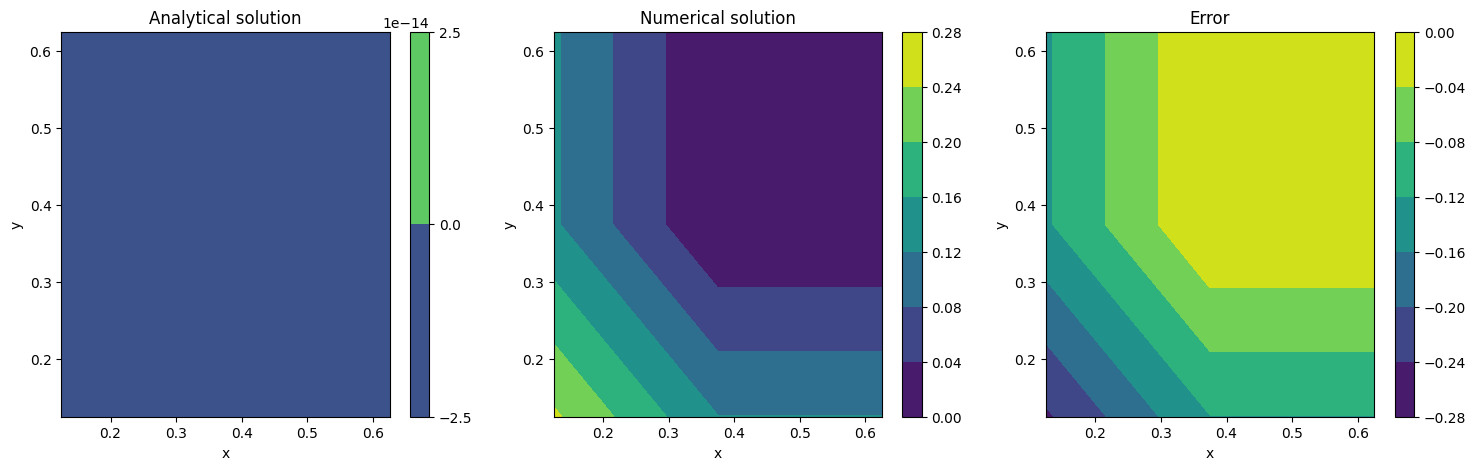

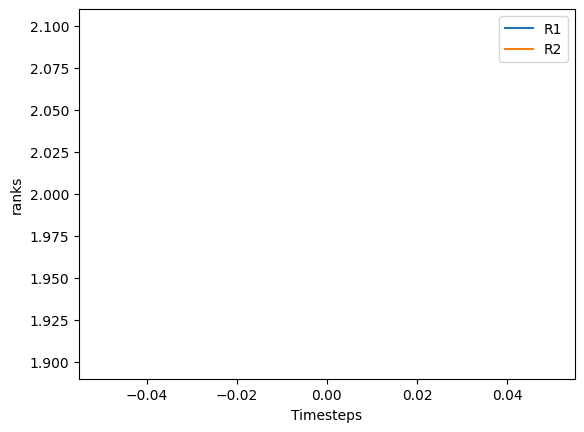

In [90]:
# Only updated problem setup, flux_solver, analytical soln, x_variation
class RT_2D_APF_efficient:
    """
    Description : Solves a simplified 1-D time-dependent RT equation using an FVM solver that incorporates a modified HLL flux (Asymptotic preserving) 
    """
    def __init__(self, domain: list, n: list, T: float, dt: float, bc_left: float, bc_right: float, alpha_a: np.array, alpha_s: np.array, 
                 alpha_threshold=1e-8, CFL=None, timesteps=None, a_r=1, c_v=718, Temp=0, x_initial=None, c=3e8, soln_hist=False, tau_threshold=1e-3, 
                 beta=4, record_ranks=True, rounding_eps=1e-3, tt_gmres_options="config_files/1D_RT/gmres_opt.txt") -> None:
        """
        domain -> Spatial domain
        n -> List of integers of length 3 denoting the number of interior cell points in x and elements in theta, and phi.
        T -> Final time
        dt -> Time step size
        bc -> State value at boudary assuming dirichlets boundary condition
        x0 -> Initial solution in the domain
        c -> Speed of light which is set to 3e8 by default
        """
        self.domain = domain
        self.discretization = [None]*3
        self.dx = (domain[1] - domain[0])/(n[0])
        if not(CFL is None): dt = CFL*self.dx/c
        self.dt = dt
        if not(timesteps is None): T = dt*timesteps
        self.T = T
        self.bc_left = bc_left
        self.bc_right = bc_right
        self.soln_hist = soln_hist
        self.c = c
        self.tau_threshold = tau_threshold
        self.beta = beta
        self.alpha_a = alpha_a
        self.alpha_s = alpha_s
        self.a_r = a_r
        self.c_v = c_v
        self.rounding_eps = rounding_eps
        self.rho = np.ones((n[0]**2))
        self.record_ranks = record_ranks

        self.discretization[0] = np.linspace(domain[0]+self.dx/2, domain[1]-self.dx/2, n[0])
        self.discretization[1] = np.linspace(0, np.pi, n[1])
        self.discretization[2] = np.linspace(0, 2*np.pi, n[2])[:-1]
        self.dtheta = np.pi/(n[1]-1)
        self.dphi = 2*np.pi/(n[2]-1)
        n[2] = n[2] - 1
        self.n = n
        
        if x_initial is None:
            x_initial = [np.zeros((1, n[0]**2, 1))]+[np.zeros((1, ns, 1)) for ns in n[1:]]
            # x_initial[0][0, 0, 0] = bc_left

        self.x_initial = x_initial
        self.currsoln = x_initial
        self.Temp = Temp*np.ones((n[0]**2)) # Need to setup proper intial conditions for temperature
        

        # Set up wavespeed expressions
        alpha_a = np.maximum(alpha_a, alpha_threshold*np.ones_like(alpha_a)); alpha_s = np.maximum(alpha_s, alpha_threshold*np.ones_like(alpha_s))
        alpha_a = np.array([alpha_a[0]]+list(alpha_a)+[alpha_a[-1]]); alpha_s = np.array([alpha_s[0]]+list(alpha_s)+[alpha_s[-1]]) # Ghost cell approach
        alpha_sum = alpha_a + alpha_s
        self.tau = (2*beta*self.dx)/(1/(alpha_sum[:-1]) + 1/(alpha_sum[1:]))
        
        sintheta = np.sin(self.discretization[1])
        cosphi = np.cos(self.discretization[2])
        sinphi = np.sin(self.discretization[2])
        
        # Mask all the spatial locations according to the value of tau at that spatial location
        tau_mask_greater = self.tau >= tau_threshold
        tau_mask_lesser = self.tau < tau_threshold

        SR = []
        SR.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SR.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        SR.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SR.append(-self.tau)

        SL = []
        SL.append(-np.sqrt((1 - np.exp(-np.power(self.tau, 4)))/np.square(self.tau)))
        SL.append(-self.tau)
        SL.append(np.sqrt((1 - np.exp(-np.square(self.tau)))/np.square(self.tau)))
        SL.append(np.sqrt(1 - 0.5*np.square(self.tau)))
        
        SR = np.array(SR); SL = np.array(SL)
        
        exprR = (SR - SR*SL)/(SR - SL)
        exprL = (SL - SR*SL)/(SR - SL)
        exprL =  np.nan_to_num(exprL, posinf=0, neginf=0); exprR =  np.nan_to_num(exprR, posinf=0, neginf=0)
        
        exprR[::2, ~tau_mask_greater] = 0
        exprR[1::2, ~tau_mask_lesser] = 0
        exprL[::2, ~tau_mask_greater] = 0
        exprL[1::2, ~tau_mask_lesser] = 0
        print(exprL)
        
        self.op = np.zeros((4, 3, n[0])) # 4 conditions wrt tau and angle, 3 for tridiagonal operator (sub-diag [0], diag [1], and super-diag [2]), n[0] points
        
        # Ghost cell approach for boundary conditions 
        self.bx = [None]*3
        self.bx[0] = np.zeros((n[0]**2, 4))
        self.bx[1] = np.array([sintheta]*4).T
        self.bx[2] = np.array([cosphi]*4).T

        self.by = [None]*3
        self.by[0] = np.zeros((n[0]**2, 4))
        self.by[1] = np.array([sintheta]*4).T
        self.by[2] = np.array([sinphi]*4).T

        for i in range(4):
            # Ghost cell approach
            tmp = np.zeros((n[0]))
            tmp[0] = -exprR[i, 0]*bc_left; tmp[-1] = -exprL[i, -1]*bc_right
            self.bx[0][:, i] = np.kron(tmp, np.ones_like(tmp))
            self.by[0][:, i] = np.kron(np.ones_like(tmp), tmp) 
            
            self.op[i, 1, :] = exprL[i, :-1] + exprR[i, 1:] # Diag
            self.op[i, 2, 1:] = -exprL[i, 1:-1] # Super-diag
            self.op[i, 0, :-1] = -exprR[i, 1:-1] # Sub-diag
            
                
        # Mask all the angular locations according to the value of cos(phi)
        cosphi_mask_greater = cosphi >= 0
        
        # Ghost cell approach for boundary (... continued)
        self.bx[2][:, :2][~cosphi_mask_greater.T] = 0
        self.bx[2][:, 2:][cosphi_mask_greater.T] = 0
        self.bx = cp_to_tt([1]*4, self.bx)

        # Mask all the angular locations according to the value of sin(phi)
        sinphi_mask_greater = sinphi >= 0
        
        # Ghost cell approach for boundary (... continued)
        self.by[2][:, :2][~sinphi_mask_greater.T] = 0
        self.by[2][:, 2:][sinphi_mask_greater.T] = 0
        self.by = cp_to_tt([1]*4, self.by)

        self.b = tt_rounding(tt_add(self.bx, self.by))[0]


        self.sintheta = sintheta
        self.cosphi = cosphi
        self.cosphi_mask_greater = cosphi_mask_greater
        self.sinphi = sinphi
        self.sinphi_mask_greater = sinphi_mask_greater

        
    def apply_ttop(self, tt_vec, dt=None):
        """
        Applies the TT operator efficiently on tt_vec. In our solver, the 
        tt_vec is simply going to be the solution at a certain timestep
        """
        if dt is None: dt = self.dt
        k = lambda dt: self.c*dt/self.dx
        b = (self.b).copy()
        b[0] = k(dt) * b[0]

        # Apply to angular cores
        sh = [list(s.shape) for s in tt_vec]
        sintheta_vec = (self.sintheta[:, np.newaxis] * tt_vec[1].transpose([1, 0, -1]).reshape((
            self.n[1], -1))).reshape((sh[1][1], sh[1][0], -1)).transpose([1, 0, -1])
        sintheta_vec = k(dt) * sintheta_vec

        cosphi_vec = (self.cosphi[:, np.newaxis] * tt_vec[2].transpose([1, 0, -1]).reshape((
            self.n[2], -1))).reshape((sh[2][1], sh[2][0], -1)).transpose([1, 0, -1])
        sinphi_vec = (self.sinphi[:, np.newaxis] * tt_vec[2].transpose([1, 0, -1]).reshape((
            self.n[2], -1))).reshape((sh[2][1], sh[2][0], -1)).transpose([1, 0, -1])
        
        cosphipos_vec = cosphi_vec.copy()
        cosphipos_vec[:, ~self.cosphi_mask_greater, :] = 0
        cosphineg_vec = cosphi_vec.copy()
        cosphineg_vec[:, self.cosphi_mask_greater, :] = 0
        sinphipos_vec = sinphi_vec.copy()
        sinphipos_vec[:, ~self.sinphi_mask_greater, :] = 0
        sinphineg_vec = sinphi_vec.copy()
        sinphineg_vec[:, self.sinphi_mask_greater, :] = 0

        # Apply to spatial core
        for i in range(4):
            tmpx = self.op[i, :, :][..., np.newaxis] * tt_vec[0].reshape((self.n[0], -1))
            tmpx[0, 1:, :] = tmpx[0, :-1, :]; tmpx[0, 0, :] = 0
            tmpx[2, :-1, :] = tmpx[2, 1:, :]; tmpx[2, -1, :] = 0
            tmpx = (np.sum(tmpx, axis=0)).reshape(sh[0])

            tmpy = self.op[i, :, :][..., np.newaxis] * tt_vec[0].reshape((self.n[0], self.n[0], -1)).transpose([1, 0, -1]).reshape((self.n[0], -1))
            tmpy[0, 1:, :] = tmpy[0, :-1, :]; tmpy[0, 0, :] = 0
            tmpy[2, :-1, :] = tmpy[2, 1:, :]; tmpy[2, -1, :] = 0
            tmpy = (np.sum(tmpy, axis=0)).reshape((self.n[0], self.n[0], -1)).transpose([1, 0, -1]).reshape(sh[0])

            if i == 0 or i == 1:
                tmp_ttcore = tt_add([tmpx, sintheta_vec, cosphipos_vec], [tmpy, sintheta_vec, sinphipos_vec])
                if i == 0:  tt_res = tmp_ttcore
                else: tt_res = tt_add(tt_res, tmp_ttcore)
            
            elif i == 2 or i == 3:
                tmp_ttcore = tt_add([tmpx, sintheta_vec, cosphineg_vec], [tmpy, sintheta_vec, sinphineg_vec])
                tt_res = tt_add(tt_res, tmp_ttcore)

        tt_res = tt_rounding_gram_svd_rlr(tt_add(tt_res, b), eps=self.rounding_eps)[0]

        return tt_res

            


    def newton_raphson(self, f, fprime, x0, tol=1e-6, maxiter=1000):
        currx = x0
        func = f(currx)
        k = 0
        while func.any() > tol and k < maxiter:
            deri = fprime(currx)
            # delx = np.linalg.solve(np.diag(deri), -func)
            delx = -func/deri
            currx += delx
            func = f(currx)
            k += 1
        return currx


    def flux_solver(self, source=False, dt=None, prt=False):
        rank_hist = []
        if self.soln_hist: hist_storage = []
        currsoln = self.currsoln
        
        if source: counter = 1
        else: counter = int(self.T/self.dt)
    
        for i in range(counter):
            tmpsoln = self.apply_ttop(currsoln, dt)
            tmpsoln[0] = -tmpsoln[0]
            currsoln = tt_add(currsoln, tmpsoln)
            currsoln = tt_rounding_gram_svd_rlr(currsoln, eps=self.rounding_eps)[0]
            if self.record_ranks: rank_hist.append(get_tt_rank(currsoln))
            if prt: print(f"{i+1}  Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(currsoln))
            if self.soln_hist: hist_storage.append(currsoln)
        
        self.currsoln = currsoln
        self.hist_storage = hist_storage
        self.rank_hist = rank_hist
        # print([s.shape for s in tt_op])
        return currsoln


    def source_solver(self, dt=None):
        if dt is None: dt = self.dt
        currsoln = self.currsoln.copy()
        currTemp = self.Temp.copy()
        currJ = self.J.copy()

        # Extending alpha to 2-D (Only accurate for a uniform alpha field)
        alpha_a = np.array(list(self.alpha_a)*self.n[0])
        alpha_s = np.array(list(self.alpha_s)*self.n[0])
        
        # Evaluate constants
        chi_t = 1/(1/(self.c*dt) + (alpha_a + alpha_s))
        chi_a = 1/(1/(self.c*dt) + (alpha_a))
        zeta = alpha_a/(self.c_v * self.rho)
        
        # Solve for T
        tmp = zeta*chi_a
        f = lambda t: self.a_r*tmp*np.power(t, 4) + t + (-tmp*(4*np.pi/self.c)*currJ - currTemp)
        fprime = lambda t: 4*self.a_r*tmp*np.power(t, 3) + 1
        currTemp = self.newton_raphson(f, fprime, currTemp)
        
        # Get J
        currJ = chi_a * (currJ/(self.c * self.dt) + self.c * self.a_r/(4*np.pi) * alpha_a * np.power(currTemp, 4))
        
        # Get updated I
        tmp = chi_t * (self.c * self.a_r/(4*np.pi) * alpha_a * np.power(currTemp, 4) + alpha_s * currJ)
        tmp = [tmp[np.newaxis, :, np.newaxis], np.ones((1, self.n[1], 1)), np.ones((1, self.n[2], 1))]
        currsoln[0] = currsoln[0] * (chi_t/(self.c * dt))[np.newaxis, :, np.newaxis]
        currsoln = tt_add(currsoln, tmp)
        self.Temp = currTemp
        self.J = currJ
        self.currsoln = currsoln
    
    
    def solver(self):
        # Setup initial conditions
        self.J = self.get_J(self.currsoln.copy())
        
        # Start timestepping
        for i in range(int(self.T/self.dt)):
            self.flux_solver(source=True, dt=self.dt/2)
            self.source_solver(dt=self.dt)
            self.flux_solver(source=True, dt=self.dt/2)
            print(f"Time passed : {(i+1)*self.dt} s \t\t Solution ranks : ", get_tt_rank(self.currsoln))


    def x_variation(self, ttcores, theta_index, phi_index):
        return np.einsum('ij,jk,kl->i', ttcores[0][0], ttcores[1][:, theta_index, :], ttcores[2][:, phi_index, :])

    
    def analytic_soln(self, t=None, c=None):
        if t is None: t = self.T
        if c is None: c = self.c
        ct = c * t
        def calc(x, y):
            n_x = np.arccos(np.minimum(np.abs(y/np.sqrt(np.maximum(ct**2 - x**2, 0))), 1))
            n_y = np.arccos(np.minimum(np.abs(x/np.sqrt(np.maximum(ct**2 - y**2, 0))), 1))

            J_l = np.zeros_like(x)
            J_b = np.zeros_like(y)
            # Element-wise comparison using NumPy's where
            J_l = np.where(x < ct,
                           0.5 - (np.pi-n_x)*x/(2*np.pi*ct) - np.arcsin(x*np.sin(n_x)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_l)

            J_b = np.where(y < ct,
                           0.5 - (np.pi-n_y)*y/(2*np.pi*ct) - np.arcsin(y*np.sin(n_y)/np.sqrt(x**2 + y**2))/(2*np.pi),
                           J_b)

            # Sum J_l and J_b element-wise
            return (J_l + J_b)

        return calc

    

    def plot_final_solution(self, theta_index: int, phi_index: int):
        fig, axs = plt.subplots()
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], label="Initial", linestyle='--')
        axs.plot(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.x_initial, theta_index, phi_index))+[self.bc_right], marker="o", label="Initial")
        # axs.scatter(np.linspace(self.domain[0], self.domain[1], self.n[0]+2), [self.bc_left]+list(self.x_variation(self.currsoln, theta_index, phi_index))+[self.bc_right], marker="o", label=f"T = {self.T} s")
        axs.set_xlabel(r"x")
        axs.set_ylabel(r"Radiation intensity I")
        axs.legend()
        # axs.set_title("(", u_index, v_index, ")")

        return fig
    
    
    def get_J(self, I):
        sintheta = np.sin(self.discretization[1])
        dtheta = sintheta*np.array([self.dtheta/2]+[self.dtheta]*(self.n[1]-2)+[self.dtheta/2])
        dphi = np.array([self.dphi/2]+[self.dphi]*(self.n[2]-2)+[self.dphi/2])
        I[1] = np.einsum('ijk,j->ik', I[1], dtheta)
        I[2] = np.einsum('ijk,j->i', I[2], dphi)
        J = (I[0][0] @ I[1] @ I[2])/(4*np.pi)
        return J
    

    def plot_ranks(self):
        plt.figure()
        rkhist = np.array(self.rank_hist)
        plt.plot(range(rkhist.shape[0]), rkhist[:, 1], label=r"R1")
        plt.plot(range(rkhist.shape[0]), rkhist[:, 2], label=r"R2")
        plt.xlabel("Timesteps")
        plt.ylabel("ranks")
        plt.legend()
    
    def plot_J(self, plot_fig=True, threshold=1e-6):
        I = self.currsoln.copy()
        # sh = I[0].shape
        # tmp = I[0]
        # I[0] = np.zeros((sh[0], sh[1]+2, sh[-1]))
        # I[0][:, 1:-1, :] = tmp
        # sintheta = np.ones((self.n[1]))
        # cosphi = np.ones((self.n[2]))
        # Ib = [np.zeros((1, sh[1]+2, 1)), sintheta[np.newaxis, :, np.newaxis], cosphi[np.newaxis, :, np.newaxis]]
        # Ib[0][0, 0, 0] = self.bc_left; Ib[0][0, -1, 0] = self.bc_right
        # I = tt_add(I, Ib)
        J = self.get_J(I)
        J[np.abs(J) < threshold] = 0
        # J = self.J
        E = J*(4*np.pi)/self.c

        if plot_fig:
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            intt = np.concatenate(([self.domain[0]], self.discretization[0], [self.domain[1]]))
            x_max = np.where(intt[1:-1] >= (self.domain[1] - self.c*self.T))[0][0]
            X, Y = np.meshgrid(intt[1:-1][:x_max], intt[1:-1][:x_max])
            ana = self.analytic_soln()(X, Y)
           
            c1 = axs[0].contourf(X, Y, ana)
            axs[0].set_xlabel(r"x")
            axs[0].set_ylabel(r"y")
            axs[0].set_title(r"Analytical solution")
            fig.colorbar(c1, ax=axs[0], orientation='vertical')

            c2 = axs[1].contourf(X, Y, J.reshape((n[0], n[0]))[:x_max, :x_max]) 
            axs[1].set_xlabel(r"x")
            axs[1].set_ylabel(r"y")
            axs[1].set_title(r"Numerical solution")
            fig.colorbar(c2, ax=axs[1], orientation='vertical')

            c3 = axs[2].contourf(X, Y, (ana - J.reshape((n[0], n[0]))[:x_max, :x_max])) 
            axs[2].set_xlabel(r"x")
            axs[2].set_ylabel(r"y")
            axs[2].set_title(r"Error")
            fig.colorbar(c3, ax=axs[2], orientation='vertical')
            
            

n = [4, 99, 100]
prob3eff = RT_2D_APF_efficient(domain=[0, 1], n=n, T=(2)*1e-9, dt=(1/48)*1e-9, bc_left=1, bc_right=0, 
                  alpha_a=0*np.ones(n[0]), alpha_s=0*np.ones(n[0]), soln_hist=True, CFL=0.5, 
                  timesteps=1, c=3e8, rounding_eps=2.5e-3, record_ranks=True, a_r=1, c_v=718, Temp=1)
print("CFL number = ", prob3eff.c*prob3eff.T)
soln = prob3eff.flux_solver(prt=True)
# prob3.solver()
# fig = prob3.plot_final_solution(50, 0)
prob3eff.plot_J()
prob3eff.plot_ranks()
# # [s.shape for s in prob3.tt_op]
# profile_f(lambda: prob3eff.flux_solver(prt=True), "Results/2D_RT_eff.prof")

In [86]:
s = np.random.randn(9, 1)
ss = np.random.randn(9, 65, 3)
print((s*ss).shape)

ValueError: operands could not be broadcast together with shapes (9,1) (9,65,3) 

# Mat-Vec approximation using DMRG

In [745]:
class matvec_approx:
    """
    Approximate Matrix-Vector product Ax by a vector z by formulating it as a minimization problem.
    To do:
    - Test


    """
    def __init__(self, A, x, z=None):
        self.A = A
        self.x = x
        self.d = len(x)
        self.Ra = get_tt_rank(A)
        self.Rx = get_tt_rank(x)
        if z == None:
            self.z = rand_tt([s.shape[1] for s in x], list(np.multiply(self.Ra, self.Rx)))
        else:
            self.z = z

    def v_collapse(self, a, b, c):
        """
        top to bottom contraction of TT cores of a, b, c
        """
        sb = b.shape
        sc = c.shape
        tmp = b.transpose([1, 0, 3, 2]).reshape((-1, sb[2])) @ c.transpose([1, 0, 2]).reshape((sc[1], -1))
        if a is None:
            return tmp.reshape((sb[1], sb[0], sb[3], sc[0], sc[2])).transpose([1, 3, 0, 2, 4])
        else:
            sa = a.shape
            tmp = a.transpose([0, 2, 1]).reshape((-1, sa[1])) @ tmp.reshape((sb[1], -1))
            return tmp.reshape([sa[0], sa[-1], sb[0], sb[-1], sc[0], sc[-1]]).transpose([0, 2, 4, 1, 3, 5])


    def h_collapse(self, ls: list):
        """
        Left to right contraction of tensors 6-d tensors in ls
        """
        sls = [s.shape for s in ls]
        res = ls[0].reshape((np.prod(sls[0][:3]), -1))
        for i in range(1, len(ls)):
            res = res @ ls[i].reshape((np.prod(sls[i][:3]), -1))
        return res.reshape(sls[0][:3]+sls[-1][3:])

    def orthogonalize(self, cores: list, option='lr'):
        l = len(cores)
        if option == 'lr':
            for i in range(l):
                sh = cores[i].shape
                q, r = np.linalg.qr(cores[i].reshape(-1, sh[-1]))
                cores[i] = q.reshape(sh[0], sh[1], q.shape[-1])
                if i != l-1:
                    cores[i+1] = np.einsum('ij,jkl->ikl', r, cores[i+1])
        elif option == 'rl':
            for i in range(l-1, -1, -1):
                sh = cores[i].shape
                r, q = rq(cores[i].reshape(sh[0], -1))
                cores[i] = q.reshape(q.shape[0], sh[1], sh[2])
                if i != 0:
                    cores[i-1] = np.einsum('ijk,kl->ijl', cores[i-1], r)

        return cores, r

    def decimate(self, core, ogshl, ogshr, eps, option='lr'):
        """
        Breaks down the super core into its 2 subcores using svd
        and adapts the svd rank according to the error eps
        core: combined supercore W
        ogshl: Original left core shape
        ogshr: Original right core shape
        eps: SVD reconstruction error

        Returns: 2 subcores G_left, G_right
        """
        res = core.reshape((ogshl[0]*ogshl[1], ogshr[1]*ogshr[2]))
        u, s, vt = np.linalg.svd(res)
        rk = eps_to_rank(s, eps=eps)
        rk = min(res.shape[0], res.shape[1], rk)
        u = u[:, :rk]; s = s[:rk]; vt = vt[:rk, :]
        if option == 'lr':
            return u.reshape(ogshl[0], ogshl[1], rk), (np.diag(s)@vt).reshape(rk, ogshr[1], ogshr[2])
        elif option == 'rl':
            return (u@np.diag(s)).reshape(ogshl[0], ogshl[1], rk), (vt).reshape(rk, ogshr[1], ogshr[2])


    def forward_sweep(self, z, phirhs, svdtol=1e-5):
        philhs = []
        for i in range(self.d - 1):
            sh = z[i].shape; shp1 = z[i+1].shape

            # combine cores
            # W = np.einsum('ijk,klm->ijlm', z[i], z[i+1])
            W = (z[i].reshape((-1, sh[-1])) @ z[i+1].reshape((shp1[0], -1))).reshape(sh[:2]+shp1[1:])
            tmp1 = self.v_collapse(a=None, b=self.A[i], c=self.x[i])
            tmp2 = self.v_collapse(a=None, b=self.A[i+1], c=self.x[i+1])
            s1 = tmp1.shape; s2 = tmp2.shape
            tmp = (tmp1.reshape((s1[0]*s1[1]*s1[2], -1)) @ tmp2.reshape((s2[0]*s2[1], -1))).reshape(s1[:3] + s2[2:])
            if i == 0:
                srhs = phirhs[i].shape
                tmp = tmp[0, 0, ...]
                # W = np.einsum('ijkl,mkl->ijm', tmp, phirhs[i][..., 0, 0, 0])
                W = (tmp.reshape((s1[2]*s2[2], -1)) @ (phirhs[i][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((s1[0], s1[1], -1))
            elif i == (self.d - 2):
                slhs = philhs[-1].shape
                tmp = tmp[..., 0, 0]
                # W = np.einsum('ijk,jklm->ilm', philhs[-1][0, 0, 0, ...], tmp)
                W = (philhs[-1][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((-1, s1[2]*s2[2]))).reshape((-1, s1[2], s2[2]))
            else:
                slhs = philhs[-1].shape
                srhs = phirhs[i].shape
                # W = np.einsum('ijk,jklmno,pno->ilmp', philhs[-1][0, 0, 0, ...], tmp, phirhs[i][..., 0, 0, 0])
                W = (philhs[-1][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((s1[0]*s1[1], -1))).reshape((slhs[3]*s1[2]*s2[2], -1))
                W = (W @ (phirhs[i][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((slhs[3], s1[2], s2[2], -1))


            z[i], z[i+1] = self.decimate(W, sh, shp1, svdtol, 'lr')

            if i == 0:
                philhs.append(self.v_collapse(z[i], self.A[i], self.x[i]))
            else:
                if i == (self.d-2):
                    pass
                else:
                    philhs.append(self.h_collapse([philhs[-1], self.v_collapse(z[i], self.A[i], self.x[i])]))

        return philhs


    def backward_sweep(self, z, philhs, svdtol=1e-5):
        phirhs = []
        for i in range(self.d - 1, 0, -1):
            sh = z[i].shape; shm1 = z[i-1].shape

            # combine cores
            # W = np.einsum('ijk,klm->ijlm', z[i-1], z[i])
            W = (z[i-1].reshape((-1, shm1[-1])) @ z[i].reshape((sh[0], -1))).reshape(shm1[:2]+sh[1:])
            tmp1 = self.v_collapse(a=None, b=self.A[i-1], c=self.x[i-1])
            tmp2 = self.v_collapse(a=None, b=self.A[i], c=self.x[i])
            s1 = tmp1.shape; s2 = tmp2.shape
            tmp = (tmp1.reshape((s1[0]*s1[1]*s1[2], -1)) @ tmp2.reshape((s2[0]*s2[1], -1))).reshape(s1[:3] + s2[2:])
            if i == 1:
                srhs = phirhs[-1].shape
                tmp = tmp[0, 0, ...]
                # W = np.einsum('ijkl,mkl->ijm', tmp, phirhs[-1][..., 0, 0, 0])
                W = (tmp.reshape((s1[2]*s2[2], -1)) @ (phirhs[-1][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((s1[0], s1[1], -1))
            elif i == (self.d - 1):
                slhs = philhs[i-2].shape
                tmp = tmp[..., 0, 0]
                # W = np.einsum('ijk,jklm->ilm', philhs[i-2][0, 0, 0, ...], tmp)
                W = (philhs[i-2][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((-1, s1[2]*s2[2]))).reshape((-1, s1[2], s2[2]))
            else:
                srhs = phirhs[-1].shape
                slhs = philhs[i-2].shape
                # W = np.einsum('ijk,jklmno,pno->ilmp', philhs[i-2][0, 0, 0, ...], tmp, phirhs[-1][..., 0, 0, 0])
                W = (philhs[i-2][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((s1[0]*s1[1], -1))).reshape((slhs[3]*s1[2]*s2[2], -1))
                W = (W @ (phirhs[-1][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((slhs[3], s1[2], s2[2], -1))

            z[i-1], z[i] = self.decimate(W, shm1, sh, svdtol, 'rl')

            if i == self.d-1:
                phirhs.append(self.v_collapse(z[i], self.A[i], self.x[i]))
            else:
                if i == 1: pass
                else: phirhs.append(self.h_collapse([self.v_collapse(z[i], self.A[i], self.x[i]), phirhs[-1]]))

        return phirhs



    def approx_matvec(self, maxiter, svdtol=1e-5):
        """
        Evaluates the approximate matrix vector product in TT format using the DMRG algorithm
        """
        z = self.z
        k = 0
        while k < maxiter:
            if k == 0:
                # rl orthogonalization
                z[1:], r = self.orthogonalize(cores=z[1:], option='rl')
                # z[0] = np.einsum('ijk,kl->ijl', z[0], r)
                z[0] = (z[0].reshape((-1, z[0].shape[-1])) @ r).reshape(z[0].shape[:2]+(-1,))

                # Initial phirhs
                phirhs = []
                for i in range(self.d-1, 1, -1):
                    if i == self.d - 1:
                        phirhs.append(self.v_collapse(z[i], self.A[i], self.x[i]))
                    else:
                        phirhs.append(self.h_collapse([self.v_collapse(z[i], self.A[i], self.x[i]), phirhs[-1]]))
            phirhs = phirhs[::-1]

            # Forward sweep
            philhs = self.forward_sweep(z, phirhs, svdtol)

            # Backward sweep
            phirhs = self.backward_sweep(z, philhs, svdtol)

            k += 1

        self.z = z
        self.ranks = [1] + [s.shape[-1] for s in z]
        return z

In [ ]:
def v_collapseapp(a, b, c):
    """
    top to bottom contraction of TT cores of a, b, c
    """
    sb = b.shape
    sc = c.shape
    tmp = b.transpose([1, 0, 3, 2]).reshape((-1, sb[2])) @ c.transpose([1, 0, 2]).reshape((sc[1], -1))
    if a is None:
        return tmp.reshape((sb[1], sb[0], sb[3], sc[0], sc[2])).transpose([1, 3, 0, 2, 4])
    else:
        sa = a.shape
        tmp = a.transpose([0, 2, 1]).reshape((-1, sa[1])) @ tmp.reshape((sb[1], -1))
        return tmp.reshape([sa[0], sa[-1], sb[0], sb[-1], sc[0], sc[-1]]).transpose([0, 2, 4, 1, 3, 5])

def h_collapseapp(ls: list):
    """
    Left to right contraction of tensors 6-d tensors in ls
    """
    sls = [s.shape for s in ls]
    res = ls[0].reshape((np.prod(sls[0][:3]), -1))
    for i in range(1, len(ls)):
        res = res @ ls[i].reshape((np.prod(sls[i][:3]), -1))
    return res.reshape(sls[0][:3]+sls[-1][3:])

# def orthogonalize(cores: list, option='lr'):
#     l = len(cores)
#     if option == 'lr':
#         for i in range(l):
#             sh = cores[i].shape
#             q, r = np.linalg.qr(cores[i].reshape(-1, sh[-1]))
#             cores[i] = q.reshape(sh[0], sh[1], q.shape[-1])
#             if i != l-1:
#                 cores[i+1] = np.einsum('ij,jkl->ikl', r, cores[i+1])
#     elif option == 'rl':
#         for i in range(l-1, -1, -1):
#             sh = cores[i].shape
#             r, q = rq(cores[i].reshape(sh[0], -1))
#             cores[i] = q.reshape(q.shape[0], sh[1], sh[2])
#             if i != 0:
#                 cores[i-1] = np.einsum('ijk,kl->ijl', cores[i-1], r)
#     return cores, r

# def decimate(core, ogshl, ogshr, eps, option='lr'):
#     """
#     Breaks down the super core into its 2 subcores using svd
#     and adapts the svd rank according to the error eps
#     core: combined supercore W
#     ogshl: Original left core shape
#     ogshr: Original right core shape
#     eps: SVD reconstruction error
#     Returns: 2 subcores G_left, G_right
#     """
#     res = core.reshape((ogshl[0]*ogshl[1], ogshr[1]*ogshr[2]))
#     u, s, vt = np.linalg.svd(res)
#     rk = eps_to_rank(s, eps=eps)
#     rk = min(res.shape[0], res.shape[1], rk)
#     u = u[:, :rk]; s = s[:rk]; vt = vt[:rk, :]
#     if option == 'lr':
#         return u.reshape(ogshl[0], ogshl[1], rk), (np.diag(s)@vt).reshape(rk, ogshr[1], ogshr[2])
#     elif option == 'rl':
#         return (u@np.diag(s)).reshape(ogshl[0], ogshl[1], rk), (vt).reshape(rk, ogshr[1], ogshr[2])

def forward_sweepapp(A, x, z, phirhs, svdtol=1e-5):
    philhs = []
    d = len(x)
    for i in range(d - 1):
        sh = z[i].shape; shp1 = z[i+1].shape

        # combine cores
        # W = np.einsum('ijk,klm->ijlm', z[i], z[i+1])
        W = (z[i].reshape((-1, sh[-1])) @ z[i+1].reshape((shp1[0], -1))).reshape(sh[:2]+shp1[1:])
        tmp1 = v_collapseapp(a=None, b=A[i], c=x[i])
        tmp2 = v_collapseapp(a=None, b=A[i+1], c=x[i+1])
        s1 = tmp1.shape; s2 = tmp2.shape
        tmp = (tmp1.reshape((s1[0]*s1[1]*s1[2], -1)) @ tmp2.reshape((s2[0]*s2[1], -1))).reshape(s1[:3] + s2[2:])
        if i == 0:
            srhs = phirhs[i].shape
            tmp = tmp[0, 0, ...]
            # W = np.einsum('ijkl,mkl->ijm', tmp, phirhs[i][..., 0, 0, 0])
            W = (tmp.reshape((s1[2]*s2[2], -1)) @ (phirhs[i][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((s1[0], s1[1], -1))
        elif i == (d - 2):
            slhs = philhs[-1].shape
            tmp = tmp[..., 0, 0]
            # W = np.einsum('ijk,jklm->ilm', philhs[-1][0, 0, 0, ...], tmp)
            W = (philhs[-1][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((-1, s1[2]*s2[2]))).reshape((-1, s1[2], s2[2]))
        else:
            slhs = philhs[-1].shape
            srhs = phirhs[i].shape
            # W = np.einsum('ijk,jklmno,pno->ilmp', philhs[-1][0, 0, 0, ...], tmp, phirhs[i][..., 0, 0, 0])
            W = (philhs[-1][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((s1[0]*s1[1], -1))).reshape((slhs[3]*s1[2]*s2[2], -1))
            W = (W @ (phirhs[i][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((slhs[3], s1[2], s2[2], -1))

        z[i], z[i+1] = decimate(W, sh, shp1, svdtol, 'lr')

        if i == 0:
            philhs.append(v_collapseapp(z[i], A[i], x[i]))
        else:
            if i == (d-2):
                pass
            else:
                philhs.append(h_collapseapp([philhs[-1], v_collapseapp(z[i], A[i], x[i])]))

    return philhs

def backward_sweepapp(A, x, z, philhs, svdtol=1e-5):
    phirhs = []
    d = len(x)
    for i in range(d - 1, 0, -1):
        sh = z[i].shape; shm1 = z[i-1].shape

        # combine cores
        # W = np.einsum('ijk,klm->ijlm', z[i-1], z[i])
        W = (z[i-1].reshape((-1, shm1[-1])) @ z[i].reshape((sh[0], -1))).reshape(shm1[:2]+sh[1:])
        tmp1 = v_collapseapp(a=None, b=A[i-1], c=x[i-1])
        tmp2 = v_collapseapp(a=None, b=A[i], c=x[i])
        s1 = tmp1.shape; s2 = tmp2.shape
        tmp = (tmp1.reshape((s1[0]*s1[1]*s1[2], -1)) @ tmp2.reshape((s2[0]*s2[1], -1))).reshape(s1[:3] + s2[2:])
        if i == 1:
            srhs = phirhs[-1].shape
            tmp = tmp[0, 0, ...]
            # W = np.einsum('ijkl,mkl->ijm', tmp, phirhs[-1][..., 0, 0, 0])
            W = (tmp.reshape((s1[2]*s2[2], -1)) @ (phirhs[-1][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((s1[0], s1[1], -1))
        elif i == (d - 1):
            slhs = philhs[i-2].shape
            tmp = tmp[..., 0, 0]
            # W = np.einsum('ijk,jklm->ilm', philhs[i-2][0, 0, 0, ...], tmp)
            W = (philhs[i-2][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((-1, s1[2]*s2[2]))).reshape((-1, s1[2], s2[2]))
        else:
            srhs = phirhs[-1].shape
            slhs = philhs[i-2].shape
            # W = np.einsum('ijk,jklmno,pno->ilmp', philhs[i-2][0, 0, 0, ...], tmp, phirhs[-1][..., 0, 0, 0])
            W = (philhs[i-2][0, 0, 0, ...].reshape((slhs[3], -1)) @ tmp.reshape((s1[0]*s1[1], -1))).reshape((slhs[3]*s1[2]*s2[2], -1))
            W = (W @ (phirhs[-1][..., 0, 0, 0].reshape((srhs[0], -1))).T).reshape((slhs[3], s1[2], s2[2], -1))
        z[i-1], z[i] = decimate(W, shm1, sh, svdtol, 'rl')
        if i == d-1:
            phirhs.append(v_collapseapp(z[i], A[i], x[i]))
        else:
            if i == 1: pass
            else: phirhs.append(h_collapseapp([v_collapse(z[i], A[i], x[i]), phirhs[-1]]))

    return phirhs


def approximate_matvec(A, x, z, maxiter, svdtol=1e-5):
    """
    Evaluates the approximate matrix vector product in TT format using the DMRG algorithm
    """
    Ra = get_tt_rank(A)
    Rx = get_tt_rank(x)
    if z is None:
        z = rand_tt([s.shape[1] for s in x], list(get_tt_rank(x)))
    d = len(x)
    k = 0
    while k < maxiter:
        if k == 0:
            # rl orthogonalization
            z[1:], r = orthogonalize(cores=z[1:], option='rl')
            # z[0] = np.einsum('ijk,kl->ijl', z[0], r)
            z[0] = (z[0].reshape((-1, z[0].shape[-1])) @ r).reshape(z[0].shape[:2]+(-1,))
            # Initial phirhs
            phirhs = []
            for i in range(d-1, 1, -1):
                if i == d - 1:
                    phirhs.append(v_collapseapp(z[i], A[i], x[i]))
                else:
                    phirhs.append(h_collapseapp([v_collapseapp(z[i], A[i], x[i]), phirhs[-1]]))
        phirhs = phirhs[::-1]
        # Forward sweep
        philhs = forward_sweepapp(A, x, z, phirhs, svdtol)
        # Backward sweep
        phirhs = backward_sweepapp(A, x, z, philhs, svdtol)
        k += 1
    ranks = [1] + [s.shape[-1] for s in z]
    return z

In [ ]:
# Testing Matvec to see if it works
n = 256
vecx = np.random.randn(n)
matA = np.random.randn(n, n)
soln = matA @ vecx
xtt = vec_to_tt(vecx, [2 for _ in range(int(np.log2(n)))])
Att = mat_to_tt(matA, [2 for _ in range(int(np.log2(n)))], [2 for _ in range(int(np.log2(n)))])
x0tt = xtt.copy()

# pr = cProfile.Profile()
# pr.enable()
# # ytt = matvec_approx(Att, xtt, x0tt)
# # appmatvec = ytt.approx_matvec(maxiter=1, svdtol=0.1)
# pr.disable()

# # Save the profile data to the specified file
# pr.dump_stats('Results/approx_matvec.prof')


# # Matvec and rounding
# for _ in range(1):
#     appmatvec = tt_matvec(Att, xtt); appmatvec = tt_rounding(factors=appmatvec, rank=[1]+[10000 for _ in range(8)]+[1], eps=1e-14)[0]

# Approx. Matvec
# for _ in range(1):
#     ytt = matvec_approx(Att, xtt, x0tt); appmatvec = ytt.approx_matvec(maxiter=1, svdtol=0.1)

# profile_f(lambda: approximate_matvec(Att, xtt, z=None, maxiter=1, svdtol=0.1), 'Results/approx_matvec.prof', True)
profile_f(lambda: tt_rounding(tt_matvec(Att, xtt)), 'Results/matvec+rounding.prof', True)

# ttsoln = ttrec(appmatvec)
# print(np.linalg.norm(ttsoln.flatten() - soln))

         860 function calls in 1.265 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.265    1.265 2514330470.py:29(<lambda>)
        1    0.016    0.016    1.144    1.144 2017986916.py:1(tt_rounding)
        1    0.949    0.949    0.949    0.949 919894429.py:30(tt_dot)
       14    0.000    0.000    0.168    0.012 einsumfunc.py:1009(einsum)
       14    0.167    0.012    0.167    0.012 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.069    0.069    0.121    0.121 919894429.py:72(tt_matvec)
       81    0.052    0.001    0.052    0.001 {method 'reshape' of 'numpy.ndarray' objects}
       22    0.000    0.000    0.051    0.002 fromnumeric.py:53(_wrapfunc)
        8    0.000    0.000    0.051    0.006 fromnumeric.py:200(reshape)
        7    0.000    0.000    0.011    0.002 542214647.py:1(rq)
        7    0.009    0.001    0.010    0.001 linalg.py:789(qr)
        7    0

# Graph structure

[(1, 3, 10), (10, 3, 10), (10, 4, 10), (10, 5, 1)]
[(1, 3, 3), (3, 3, 9), (9, 4, 5), (5, 5, 1)]


# Testing...

In [ ]:
n = 6; k = 2
shape = [k for _ in range(n)]
# # TT-gmres test
A = np.random.randn(k**n, k**n); b = np.random.randn(k**n)
Att = mat_to_tt(A, shape, shape, rank=[1]+[100 for _ in range(n-1)]+[1])
btt = vec_to_tt(b, shape, rank=[1]+[100 for _ in range(n-1)]+[1])
# x0tt = vec_to_tt(x0, shape, rank=[1]+[100 for _ in range(n-1)]+[1])

x0tt = [np.random.randn(*(s.shape)) for s in btt]

x, res = tt_gmres(Att, btt, x0tt, maxiter=10, outeriter=200, rank=[1, 100, 100, 1], eps=1e-14)

tsoln = np.linalg.inv(A)@b

print(np.linalg.norm(tsoln - ttrec(x).reshape((-1))))

Iteration :  0 			Residual :  18.584176138873037
Iteration :  1 			Residual :  36.77171053305948
Iteration :  2 			Residual :  21.891211918158977
Iteration :  3 			Residual :  20.77089760759571
Iteration :  4 			Residual :  31.521804889921896
Iteration :  5 			Residual :  14.787963329294394
Iteration :  6 			Residual :  16.822279894706252
Iteration :  7 			Residual :  19.50542670177839
Iteration :  8 			Residual :  18.676405082549774
Iteration :  9 			Residual :  13.222902452103956
Iteration :  10 			Residual :  10.123716765336889
Iteration :  11 			Residual :  7.484543053788719
Iteration :  12 			Residual :  7.958864577322329
Iteration :  13 			Residual :  6.340462858922045
Iteration :  14 			Residual :  8.882629679225932
Iteration :  15 			Residual :  6.40307181812664
Iteration :  16 			Residual :  9.858694692331447
Iteration :  17 			Residual :  5.813849916085412
Iteration :  18 			Residual :  7.017396272718878
Iteration :  19 			Residual :  4.495209508668748
Iteration :  20 			Resi

In [ ]:
A = tl.tensor(X)
tl.tenalg.mode_dot(A, U, 0)

ValueError: shapes (50, 50) and (2, 3) not aligned in mode-0 multiplication: 50 (mode 0) != 3 (dim 1 of matrix)

In [ ]:
asd = np.array([3, 2])
asd2 = np.array([4, 1])
asd3 = np.array([2, 5])
np.multiply.outer(asd, asd2)

array([[12,  3],
       [ 8,  2]])

In [ ]:
# sds = np.random.randn(3, 2, 2)
# sdst = np.transpose(sds, axes=[0, 2, 1])
# sds1 = np.random.randn(3, 2, 2)

# # print(sds)
# # print(np.transpose(sds, axes=[0, 2, 1]))
# list(np.einsum('ijk,ikl->ijl', sds, sdst))

ls = [2, 4, 5]
ls.pop(2)
ls

asss = np.array([22, 1])
asss1 = np.array([[2, 1], [3, 1]])
np.divide(asss1, asss)

array([[0.09090909, 1.        ],
       [0.13636364, 1.        ]])

In [ ]:
asa = [np.array([[2, 1], [3, 1]]), np.array([[2, 1], [3, 1]]), np.array([[2, 1], [3, 1]])]
asa1 = [mat.T @ mat for mat in asa]
print(asa1)
multi(lambda x, y: x*y, asa1)

[array([[13,  5],
       [ 5,  2]]), array([[13,  5],
       [ 5,  2]]), array([[13,  5],
       [ 5,  2]])]


array([[2197,  125],
       [ 125,    8]])

In [ ]:

# Initialize a 3D array (3rd-order tensor) with zeros
dimension = 3
tensor = np.zeros((dimension, dimension, dimension))

# Values to set on the diagonal
diagonal_values = np.random.randn(dimension)

# Use advanced indexing to set the diagonal elements
indices = np.arange(dimension)
tensor[indices, indices, indices] = diagonal_values

unfold(tensor, 3)


array([[-0.91767944,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -2.58805236,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.12931649]])

In [ ]:
# np.einsum('pqr,ip,jq,kr->ijk', np.random.randn(5, 9, 16), np.random.randn(4, 5), np.random.randn(5, 9), np.random.randn(2, 16))
# tmp = np.random.randn(23, 43, 12, 12, 3, 4)
tmp = [1]*6
tmp[0] = np.random.randn(23)
tmp[1] = np.random.randn(3)
tmp[2] = np.random.randn(13)
tmp[3] = np.random.randn(34)
tmp[4] = np.random.randn(12)
tmp[5] = np.random.randn(8)
dim = len(tmp)
string = '...,' * dim
string = string[:-1]
string = string + '->...'
np.einsum(string, *tmp)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (23,)->(23,) (3,)->(3,) (13,)->(13,) (34,)->(34,) (12,)->(12,) (8,)->(8,) 

In [ ]:
arrays = [np.array([1, 2]), np.array([3, 4]), np.array([5, 6]), np.array([5, 6]), np.array([5, 6]), np.array([5, 6]), np.array([5, 6])]

# Create the einsum subscript string dynamically
subscripts = ','.join(chr(ord('i') + i) for i in range(len(arrays))) + '->' + ''.join(chr(ord('i') + i) for i in range(len(arrays)))
print(subscripts)
# Compute the generalized outer product
result = np.einsum(subscripts, *arrays)
print(result.shape)


i,j,k,l,m,n,o->ijklmno
(2, 2, 2, 2, 2, 2, 2)


In [ ]:
A = np.array([[2, 4], [6, 8]]); B = np.array([[1, 3], [5, 7]])
i, j = A.shape; k, l = B.shape
res = np.reshape(np.array([B]*(i*j)), (i, j, k, l))
res = res * A[:, :, np.newaxis, np.newaxis]
print(res)
print(np.reshape(res, (i*k, j*l)))

[[[[ 2  6]
   [10 14]]

  [[ 4 12]
   [20 28]]]


 [[[ 6 18]
   [30 42]]

  [[ 8 24]
   [40 56]]]]
[[ 2  6 10 14]
 [ 4 12 20 28]
 [ 6 18 30 42]
 [ 8 24 40 56]]


In [ ]:
k = 1
lkl = np.random.choice([0, 1], (3, 2, 3, 4))
for k in [1, 2, 3]:
    yl = lkl.reshape(np.product(np.shape(lkl)[:k]), np.product(np.shape(lkl)[k:]))
    print(yl.shape)
    print(np.linalg.matrix_rank(yl))

(3, 24)
3
(6, 12)
6
(18, 4)
4


In [ ]:
# Create a tensor
X = np.random.rand(7, 5, 5)

# Perform Tucker train decomposition
factors = tl.decomposition.tensor_train(X, rank=[1, 7, 6, 1])

print([mat.shape for mat in factors])

rec = np.einsum('abc,def,ghi->beh', *factors)
print(np.linalg.norm(X - tl.tt_to_tensor(factors)))


[(1, 7, 7), (7, 5, 5), (5, 5, 1)]
6.788752562548554e-14


In [ ]:
class A(object):
    def foo(self, x):
        print(f"executing foo({self}, {x})")

    @classmethod
    def class_foo(cls, x):
        print(f"executing class_foo({cls}, {x})")

    @staticmethod
    def static_foo(x):
        print(f"executing static_foo({x})")

a = A()

In [ ]:
A = np.array([[4, 5], [8, 10]])
u, s, v = np.linalg.svd(A)
l = (np.sqrt(np.cumsum(np.square(s[::-1])))[::-1])
print(np.argmax(l<=1e-4))

1


In [ ]:
a = np.random.randn(2, 2)
b = np.random.randn(2, 2)
a1 = np.random.randn(2, 2)
permutations = itertools.permutations([0, 1, 2, 3, 4, 5])
c = tl.tenalg.kronecker([a, b, a1])
for i in permutations:
    d = np.reshape(np.transpose(np.einsum('ij,kl,mn->ijklmn', a, b, a1), tuple(i)), (8, -1))
    if np.max(np.abs(c-d)) < 1e-6:
        print(i)


(4, 2, 0, 5, 3, 1)


In [ ]:
tmp1 = np.random.randn(1, 4, 3); tmp2 = np.random.randn(3, 9, 7); tmp3 = np.random.randn(7, 4, 1)
dd = ttrec([tmp1, tmp2, tmp3])
fc = ttsvd(dd, rank=[1, 3, 7, 1])
fc[0] = -fc[0]
ddrec = ttrec(fc)
print(np.linalg.norm(dd + ddrec))

4.7304979796453373e-14


In [ ]:
tmp0 = np.random.randn(10); tmp1 = np.random.randn(5, 10); tmp2 = np.random.randn(3, 10); tmp3 = np.random.randn(6, 10)
tenscp = cpreconstruction(tmp0, [tmp1, tmp2, tmp3])

# Using TT
diag = np.zeros([10]*3)
np.einsum('...iii->i', diag)[...] = tmp0
f2 = np.einsum('ijk,lj->ilk', diag, tmp2)
f1 = tmp1[np.newaxis, ...]; f3 = (tmp3.T)[..., np.newaxis]
tenstt = ttrec([f1, f2, f3])
print(np.linalg.norm(tenscp - tenstt))

5.578818915710759e-15


In [ ]:
tmp1 = np.random.randn(6, 3, 5); tmp2 = np.random.randn(3, 3, 6)
tmpres1 = np.zeros((18, 3, 30))
for i in range(3):
    tmpres1[:, i, :] = kronecker_prod(tmp1[:, i, :], tmp2[:, i, :])

tmpres2 = khatri_rao_prod(np.transpose(tmp1, [2, 0, 1]).reshape((-1, 3)), np.transpose(tmp2, [2, 0, 1]).reshape((-1, 3)))
tmpres2 = np.transpose(tmpres2.reshape((30, 18, 3)), [1, 2, 0])

# print(np.linalg.norm(tmpres1 - tmpres2))
print()

28.9328316798868 28.932831679886803
